# FSD50K dataset

Reference: https://zenodo.org/record/4060432#.YAEXaHYzZhE

### Parsing the JSON metafiles to a DataFrame

In [1]:
import pandas as pd
import numpy as np
import scipy
import librosa
import librosa.display
import IPython.display as ipd
import os
import json
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Creating path variables
root = 'fsd50k'
datapath = os.path.join(root, 'train')
dev_path = os.path.join(root, "collection_dev.csv")
eval_path = os.path.join(root, "collection_eval.csv")

# Audio properties
rate = 16000
n_fft = 2048
hop = 256
win_len = 2048
window = 'hann'

In [5]:
train_df = pd.read_csv(dev_path)
print(train_df.shape)
print(train_df['labels'].nunique())

eval_df = pd.read_csv(eval_path)
print(eval_df.shape)
print(eval_df['labels'].nunique())

eval_df.head()

(40966, 3)
1762
(10231, 3)
2779


,fname,labels,mids
0,37199,Electric_guitar,/m/02sgy
1,175151,Electric_guitar,/m/02sgy
2,253463,Electric_guitar,/m/02sgy
3,329838,Electric_guitar,/m/02sgy
4,1277,Electric_guitar,/m/02sgy


## Helper functions

In [3]:
def read_samples(sample_name, datapath=datapath):
    sr, sample = scipy.io.wavfile.read(os.path.join(datapath, sample_name + '.wav'))
    return sample/ np.iinfo(np.int16).max, sr

def read_samples_librosa(sample_name, datapath=datapath, rate=rate):
    sample, sr = librosa.load(os.path.join(datapath, sample_name + '.wav'), sr= rate, mono = True)
    return sample, sr

def griffinlim(mag, n_iter=30, hop=hop, win_len=win_len):
    return librosa.griffinlim(mag, n_iter= 30, 
                    hop_length=hop, win_length=win_len)   

def plot_spectrogram_from_samples(sample):
    sample = sample.astype(np.float)
    spec = librosa.stft(sample, n_fft=n_fft, 
                    hop_length = hop, win_length=win_len)

    fig = plt.figure(figsize=(15,5))
    # Plotting Log Mag
    mag = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
    ax1 = plt.subplot(1,2,1)
    librosa.display.specshow(mag, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')

In [57]:
# Visualizing all labels
pd.options.di'Walk_and_footsteps':[(422856, 0, 0.5)]splay.max_rows = 2000
train_df.groupby(['labels']).size()

labels
Accelerating_and_revving_and_vroom                                                                             46
Accordion                                                                                                      52
Acoustic_guitar                                                                                               378
Acoustic_guitar,Plucked_string_instrument                                                                       2
Acoustic_guitar,Strum                                                                                          79
Air_conditioning                                                                                               16
Air_conditioning,Fixed-wing_aircraft_and_airplane                                                               1
Air_horn_and_truck_horn                                                                                         1
Aircraft                                                                         

We mannually select the labels that could be helpful to train or test our model 

In [7]:
manual_labels = {'Air_conditioning':[(53798, 0, 4)], 
#                  'Aircraft':[(330816, 8, 11)],
                 'Bark':[(170015, 1.2, 2.2), (118963, 0, -1)], 
                 'Bathtub_(filling_or_washing)':[(67162, 0, 4),(24092, 0,4)], 
                 'Bell':[(79436, 0, 4),(32304, 0, 4)],
                 'Bicycle_bell':[(323130, 0,2),(323129, 0,2)],
                 'Bird':[(98450, 0 ,4), (127112, 0, 4)],
                 'Blender':[(71791, 0, 3)],
                 'Boiling':[(415893, 0, 4)],
#                  'Boom':[(215599, 0, 2)],
                 'Car,Engine_starting':[(2933, 0, 2), (162523, 1, 5)],
                 'Camera':[(270878, 0, 1)], # Could be better from phone
                 'Cash_register':[(402651,0,1)],
                 'Meow,Cat':[(211687, 0, 1)],
                 'Cellphone_buzz_and_vibrating_alert':[(215822, 0, 4)],
#                  'Chicken_and_rooster':[(99557, 0, 2)],
                 'Chop':[(211700, 0, 1)],
                 'Clock':[(22099, 0, 3)],
                 'Coin_(dropping)':[(63522, 0, 2), (174080,1,3)],
                 'Computer_keyboard':[(164658,0,4),(86820, 0,4)],
#                  'Coo':[(29607, 0,3)],
#                  'Croak':[(209609, 0, 4)],
                 'Cupboard_open_or_close':[(70336, 0, 1)],
                 'Drill':[(211615, 1 , 5)],
                 'Drip':[(111169, 0, 4), (274003, 0, 1)],
#                  'Drum,Percussion':[(225173,0, 1)],
#                  'Duck':[(31835, 0, 1)],
                 'Glass':[(65418, 0.5, 1)],
#                  'Goat':[(79868, 0, 1)],
#                  'Gong':[(222202, 0,4)],
#                  'Gunshot_and_gunfire':[(157801, 0, 2)],
                 'Hair_dryer':[(25912, 0 , 4)],
                 'Hammer':[(68612, 0, 1)],
#                  'Helicopter':[(181071, 0, 4)],
#                  'Horse':[(99222, 0, 1),(74830,0,4)],
                 'Keys_jangling':[(433669, 0, 4)],
                 'Microwave_oven':[(344637, 5, 9),(185883, 2, 6)],
#                  'Moo':[(233134, 0, 2)],
                 'Motorcycle':[(368211, 5, 9)],
#                  'Pig':[(66259, 0, 4)],
                 'Printer':[(268845, 0, 1)],
                 'Scissors':[(11560, 0, 1)],
#                  'Ship':[(261847, 0, 3)],
#                  'Skateboard':[(119946, 4, 6)],
                 'Tearing':[(201615, 0, 2)],
                 'Telephone':[(251894, 0, 1)],
                 'Toilet_flush':[(344720, 1 ,5)],
                 'Toothbrush':[(324701, 0, 2)],
                 'Train':[(184291, 0, 4)],
                 'Vacuum_cleaner':[(241265,0, 4)],
                 'Wood':[(98718,0, 1)],
                 'Zipper_(clothing)':[(51175, 0, 1)],
                 'Babbling':[(10191,0,1)],
                 'Walk_and_footsteps':[(422856, 0, 0.5)]
                }
human_labels = {'Babbling':[(10191,0,1)],
                'Human_voice':[()],
                'Speech':[()],
                'Walk_and_footsteps':[(422856, 0, 0.5)]}

print(len(manual_labels.keys()))

38


Parsing the dictionary to DataFrame format

In [5]:
df = pd.read_csv('fsd50k/fsd_304labels.csv')
df.head()

,fname,labels,mids,stage
0,64760,Electric_guitar,/m/02sgy,train
1,16399,Electric_guitar,/m/02sgy,train
2,16401,Electric_guitar,/m/02sgy,train
3,16402,Electric_guitar,/m/02sgy,train
4,16404,Electric_guitar,/m/02sgy,train


In [6]:
train_df['stage'] = 'train'
eval_df['stage'] = 'test'
df = pd.concat([train_df, eval_df])

In [23]:
df_template = {'fname':[], 'labels':[], 'start':[], 'end':[], 'stage':[]}
filtered_df = pd.DataFrame(df_template)
count = 0
for key_id, key in enumerate(list(manual_labels.keys())):
    for sample in manual_labels[key]:
        file_name, seg_start, seg_end = sample
        stage = df[df['fname'] == int(file_name)]['stage'].iloc[0]
        assert stage is not None
        filtered_df.loc[count] = (str(file_name), key, seg_start, seg_end, stage)
        count+=1

filtered_df.head()

,fname,labels,start,end,stage
0,53798,Air_conditioning,0.0,4.0,train
1,170015,Bark,1.2,2.2,train
2,118963,Bark,0.0,-1.0,train
3,67162,Bathtub_(filling_or_washing),0.0,4.0,train
4,24092,Bathtub_(filling_or_washing),0.0,4.0,train


In [26]:
filtered_df.to_csv('fsd_labels38_sample48.csv', index=False)

Checking some samples

In [645]:
key_idx = 51
key = list(manual_labels.keys())[key_idx]
train_df[train_df['labels'] == 'Walk_and_footsteps'].tail(20)

,fname,labels,mids
14678,422854,Walk_and_footsteps,/m/07pbtc8
14679,422856,Walk_and_footsteps,/m/07pbtc8
14681,156627,Walk_and_footsteps,/m/07pbtc8
14682,258004,Walk_and_footsteps,/m/07pbtc8
14683,365544,Walk_and_footsteps,/m/07pbtc8
14684,273384,Walk_and_footsteps,/m/07pbtc8
14685,324584,Walk_and_footsteps,/m/07pbtc8
14686,187381,Walk_and_footsteps,/m/07pbtc8
14687,404472,Walk_and_footsteps,/m/07pbtc8
14690,420931,Walk_and_footsteps,/m/07pbtc8


16000


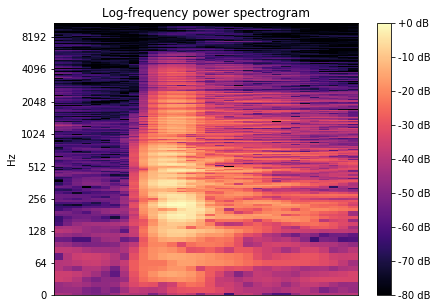

In [653]:
start_point = 0
# start_point = int(0.5*rate)
# end_point = -1
end_point = int(start_point + 0.5*rate)
samples ,rate = read_samples_librosa('422856', datapath)
samples =samples[start_point:end_point]
plot_spectrogram_from_samples(samples)
print(rate)
ipd.Audio(samples, rate=rate)

In [463]:
samples = samples.astype(np.float)
spec = librosa.stft(samples, n_fft=n_fft, 
                    hop_length = hop, win_length=win_len)
mag = np.abs(spec)

audio = griffinlim(mag)
ipd.Audio(audio, rate=rate)

Filtering labels by size

In [6]:
labels = train_df.groupby(['labels']).size()

labels = labels[labels>20]
print(len(labels))

pd.options.display.max_rows = 2000
print(labels)

new_train_df = train_df[train_df['labels'].isin(list(labels.index))]
print(new_train_df.shape)

new_eval_df = eval_df[eval_df['labels'].isin(list(labels.index))]
print(filtered_df.shape)

304
labels
Accelerating_and_revving_and_vroom                                        46
Accordion                                                                 52
Acoustic_guitar                                                          378
Acoustic_guitar,Strum                                                     79
Aircraft                                                                  33
Alarm                                                                    223
Alarm_clock                                                               43
Alto_saxophone                                                           215
Animal                                                                    87
Applause                                                                 230
Applause,Cheering                                                         54
Applause,Crowd                                                            39
Applause,Crowd,Cheering                                          

NameError: name 'filtered_df' is not defined

In [113]:
new_train_df['stage'] = 'train'
new_eval_df['stage'] = 'test'
new_df = pd.concat([new_train_df, new_eval_df])
print(new_df.shape)

train_df['stage'] = 'train'
eval_df['stage'] = 'test'
df = pd.concat([train_df, eval_df])
print(df.shape)

(42377, 4)
(51197, 4)


/home/mun/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mun/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [114]:
df.to_csv('fsd_original.csv', index=False)
new_df.to_csv('fsd_304labels.csv', index=False)

In [115]:
loaded = pd.read_csv('./fsd50k/fsd_304labels.csv')
loaded.head()

,fname,labels,mids,stage
0,64760,Electric_guitar,/m/02sgy,train
1,16399,Electric_guitar,/m/02sgy,train
2,16401,Electric_guitar,/m/02sgy,train
3,16402,Electric_guitar,/m/02sgy,train
4,16404,Electric_guitar,/m/02sgy,train


Change the sample rate of the data for speeding the training

In [15]:
for i, row in df.iterrows():
    fname = row['fname']
    folder = row['stage']
    datapath = os.path.join(root, folder,'{}.wav'.format(str(fname)))
    data, sr = librosa.load(datapath, sr=rate, mono = True)
    assert sr == 16000
    scipy.io.wavfile.write(datapath, rate, data)
    if i % 500==0:
        print('{}/{}'.format(i,len(df)))

fsd50k/train/64760.wav
0/51197
fsd50k/train/16399.wav
fsd50k/train/16401.wav
fsd50k/train/16402.wav
fsd50k/train/16404.wav
fsd50k/train/345111.wav
fsd50k/train/64761.wav
fsd50k/train/268259.wav
fsd50k/train/64762.wav
fsd50k/train/160826.wav
fsd50k/train/40515.wav
fsd50k/train/40516.wav
fsd50k/train/40517.wav
fsd50k/train/420945.wav
fsd50k/train/420946.wav
fsd50k/train/420947.wav
fsd50k/train/86100.wav
fsd50k/train/64741.wav
fsd50k/train/40523.wav
fsd50k/train/64743.wav
fsd50k/train/64744.wav
fsd50k/train/40525.wav
fsd50k/train/51319.wav
fsd50k/train/64746.wav
fsd50k/train/5318.wav
fsd50k/train/4258.wav
fsd50k/train/4259.wav
fsd50k/train/4260.wav
fsd50k/train/4261.wav
fsd50k/train/4262.wav
fsd50k/train/4263.wav
fsd50k/train/4264.wav
fsd50k/train/4265.wav
fsd50k/train/4266.wav
fsd50k/train/4267.wav
fsd50k/train/4268.wav
fsd50k/train/4269.wav
fsd50k/train/4270.wav
fsd50k/train/4272.wav
fsd50k/train/64757.wav
fsd50k/train/4276.wav
fsd50k/train/4277.wav
fsd50k/train/4278.wav
fsd50k/train/42

fsd50k/train/348813.wav
fsd50k/train/372378.wav
fsd50k/train/372383.wav
fsd50k/train/372384.wav
fsd50k/train/372385.wav
fsd50k/train/372386.wav
fsd50k/train/372387.wav
fsd50k/train/372388.wav
fsd50k/train/372389.wav
fsd50k/train/372390.wav
fsd50k/train/372392.wav
fsd50k/train/241337.wav
fsd50k/train/40438.wav
fsd50k/train/97224.wav
fsd50k/train/202245.wav
fsd50k/train/3651.wav
fsd50k/train/378579.wav
fsd50k/train/3652.wav
fsd50k/train/265983.wav
fsd50k/train/265984.wav
fsd50k/train/64709.wav
fsd50k/train/265986.wav
fsd50k/train/265988.wav
fsd50k/train/266025.wav
fsd50k/train/266026.wav
fsd50k/train/128818.wav
fsd50k/train/128819.wav
fsd50k/train/128820.wav
fsd50k/train/128821.wav
fsd50k/train/128822.wav
fsd50k/train/128823.wav
fsd50k/train/128824.wav
fsd50k/train/128825.wav
fsd50k/train/128826.wav
fsd50k/train/128827.wav
fsd50k/train/128828.wav
fsd50k/train/128829.wav
fsd50k/train/128830.wav
fsd50k/train/128831.wav
fsd50k/train/128832.wav
fsd50k/train/128833.wav
fsd50k/train/40464.wav


fsd50k/train/423343.wav
fsd50k/train/71090.wav
fsd50k/train/423344.wav
fsd50k/train/207293.wav
fsd50k/train/113095.wav
fsd50k/train/50631.wav
fsd50k/train/341407.wav
fsd50k/train/185812.wav
fsd50k/train/51669.wav
fsd50k/train/51671.wav
fsd50k/train/190945.wav
fsd50k/train/341414.wav
fsd50k/train/214510.wav
fsd50k/train/341415.wav
fsd50k/train/216565.wav
fsd50k/train/341416.wav
fsd50k/train/211447.wav
fsd50k/train/341417.wav
fsd50k/train/211453.wav
fsd50k/train/211454.wav
fsd50k/train/181757.wav
fsd50k/train/181758.wav
fsd50k/train/181759.wav
fsd50k/train/181760.wav
fsd50k/train/181761.wav
fsd50k/train/187144.wav
fsd50k/train/341419.wav
fsd50k/train/341420.wav
fsd50k/train/187146.wav
fsd50k/train/79373.wav
fsd50k/train/79375.wav
fsd50k/train/268824.wav
fsd50k/train/196124.wav
fsd50k/train/201251.wav
fsd50k/train/201252.wav
fsd50k/train/395824.wav
fsd50k/train/393777.wav
fsd50k/train/233011.wav
fsd50k/train/233013.wav
fsd50k/train/31295.wav
fsd50k/train/212544.wav
fsd50k/train/378270.wav

fsd50k/train/151359.wav
fsd50k/train/275558.wav
fsd50k/train/138465.wav
fsd50k/train/138468.wav
fsd50k/train/221639.wav
fsd50k/train/418706.wav
fsd50k/train/138277.wav
fsd50k/train/371200.wav
fsd50k/train/371201.wav
fsd50k/train/159745.wav
fsd50k/train/246275.wav
fsd50k/train/154627.wav
fsd50k/train/154629.wav
fsd50k/train/257030.wav
fsd50k/train/257031.wav
fsd50k/train/154628.wav
fsd50k/train/319497.wav
fsd50k/train/257033.wav
fsd50k/train/257034.wav
fsd50k/train/349188.wav
fsd50k/train/257028.wav
fsd50k/train/159750.wav
fsd50k/train/159753.wav
fsd50k/train/268809.wav
fsd50k/train/76817.wav
fsd50k/train/159754.wav
fsd50k/train/159755.wav
fsd50k/train/253973.wav
fsd50k/train/262679.wav
fsd50k/train/262680.wav
fsd50k/train/274460.wav
fsd50k/train/338973.wav
fsd50k/train/121886.wav
fsd50k/train/106014.wav
fsd50k/train/254508.wav
fsd50k/train/244782.wav
fsd50k/train/156209.wav
fsd50k/train/332850.wav
fsd50k/train/156212.wav
fsd50k/train/332853.wav
fsd50k/train/88121.wav
fsd50k/train/37023

fsd50k/train/242270.wav
fsd50k/train/89876.wav
fsd50k/train/242272.wav
fsd50k/train/397923.wav
fsd50k/train/366188.wav
fsd50k/train/275065.wav
fsd50k/train/255617.wav
fsd50k/train/255619.wav
fsd50k/train/255622.wav
fsd50k/train/255624.wav
fsd50k/train/212633.wav
fsd50k/train/174749.wav
fsd50k/train/255648.wav
fsd50k/train/408225.wav
fsd50k/train/242338.wav
fsd50k/train/242339.wav
fsd50k/train/242340.wav
fsd50k/train/242341.wav
fsd50k/train/255650.wav
fsd50k/train/255651.wav
fsd50k/train/255652.wav
fsd50k/train/242345.wav
fsd50k/train/255654.wav
fsd50k/train/255658.wav
fsd50k/train/255659.wav
fsd50k/train/255662.wav
fsd50k/train/255668.wav
fsd50k/train/242359.wav
fsd50k/train/242360.wav
fsd50k/train/242361.wav
fsd50k/train/242362.wav
fsd50k/train/242363.wav
fsd50k/train/47804.wav
fsd50k/train/242367.wav
fsd50k/train/186049.wav
fsd50k/train/114371.wav
fsd50k/train/114374.wav
fsd50k/train/242376.wav
fsd50k/train/242377.wav
fsd50k/train/368330.wav
fsd50k/train/89805.wav
fsd50k/train/242384

fsd50k/train/198473.wav
fsd50k/train/320330.wav
fsd50k/train/423242.wav
fsd50k/train/232779.wav
fsd50k/train/145228.wav
fsd50k/train/216397.wav
fsd50k/train/22864.wav
fsd50k/train/368977.wav
fsd50k/train/22866.wav
fsd50k/train/329041.wav
fsd50k/train/261460.wav
fsd50k/train/44880.wav
fsd50k/train/322391.wav
fsd50k/train/119639.wav
fsd50k/train/98649.wav
fsd50k/train/256861.wav
fsd50k/train/127840.wav
fsd50k/train/194914.wav
fsd50k/train/127842.wav
fsd50k/train/127844.wav
fsd50k/train/151911.wav
fsd50k/train/398700.wav
fsd50k/train/398703.wav
fsd50k/train/398704.wav
fsd50k/train/398705.wav
fsd50k/train/268658.wav
fsd50k/train/398706.wav
fsd50k/train/79220.wav
fsd50k/train/250741.wav
fsd50k/train/263030.wav
fsd50k/train/398708.wav
fsd50k/train/79221.wav
fsd50k/train/398712.wav
fsd50k/train/186746.wav
fsd50k/train/398714.wav
fsd50k/train/186748.wav
fsd50k/train/398715.wav
fsd50k/train/398716.wav
fsd50k/train/420223.wav
fsd50k/train/398718.wav
fsd50k/train/386433.wav
fsd50k/train/398719.wa

fsd50k/train/117127.wav
fsd50k/train/95662.wav
fsd50k/train/377264.wav
fsd50k/train/95665.wav
fsd50k/train/377265.wav
fsd50k/train/254386.wav
fsd50k/train/95668.wav
fsd50k/train/377266.wav
fsd50k/train/377268.wav
fsd50k/train/254389.wav
fsd50k/train/254390.wav
fsd50k/train/254391.wav
fsd50k/train/274872.wav
fsd50k/train/274871.wav
fsd50k/train/254394.wav
fsd50k/train/254395.wav
fsd50k/train/254393.wav
fsd50k/train/377270.wav
fsd50k/train/95672.wav
fsd50k/train/95675.wav
fsd50k/train/95676.wav
fsd50k/train/95677.wav
fsd50k/train/95679.wav
fsd50k/train/95680.wav
fsd50k/train/274889.wav
fsd50k/train/274890.wav
fsd50k/train/274891.wav
fsd50k/train/274892.wav
fsd50k/train/261588.wav
fsd50k/train/261589.wav
fsd50k/train/101857.wav
fsd50k/train/216567.wav
fsd50k/train/101889.wav
fsd50k/train/341507.wav
fsd50k/train/209413.wav
fsd50k/train/274866.wav
fsd50k/train/372236.wav
fsd50k/train/274869.wav
fsd50k/train/239136.wav
fsd50k/train/274978.wav
fsd50k/train/274980.wav
fsd50k/train/433700.wav
f

fsd50k/train/213153.wav
fsd50k/train/213154.wav
fsd50k/train/213156.wav
fsd50k/train/213158.wav
fsd50k/train/213159.wav
fsd50k/train/213160.wav
fsd50k/train/213161.wav
fsd50k/train/213162.wav
fsd50k/train/213163.wav
fsd50k/train/213164.wav
fsd50k/train/213165.wav
fsd50k/train/85168.wav
fsd50k/train/270515.wav
fsd50k/train/270516.wav
fsd50k/train/270517.wav
fsd50k/train/270518.wav
fsd50k/train/372919.wav
fsd50k/train/85184.wav
fsd50k/train/344265.wav
fsd50k/train/344266.wav
fsd50k/train/344267.wav
fsd50k/train/344268.wav
fsd50k/train/344269.wav
fsd50k/train/344270.wav
fsd50k/train/344271.wav
fsd50k/train/115916.wav
fsd50k/train/255182.wav
fsd50k/train/115922.wav
fsd50k/train/71897.wav
fsd50k/train/216281.wav
fsd50k/train/216282.wav
fsd50k/train/426204.wav
fsd50k/train/426205.wav
fsd50k/train/216283.wav
fsd50k/train/216284.wav
fsd50k/train/216286.wav
fsd50k/train/216287.wav
fsd50k/train/216288.wav
fsd50k/train/216289.wav
fsd50k/train/199906.wav
fsd50k/train/216291.wav
fsd50k/train/216290

fsd50k/train/204777.wav
fsd50k/train/321143.wav
fsd50k/train/202093.wav
fsd50k/train/326422.wav
fsd50k/train/276938.wav
fsd50k/train/276939.wav
fsd50k/train/400385.wav
fsd50k/train/344067.wav
fsd50k/train/125956.wav
fsd50k/train/381963.wav
fsd50k/train/69649.wav
fsd50k/train/49177.wav
fsd50k/train/176159.wav
fsd50k/train/402464.wav
fsd50k/train/402465.wav
fsd50k/train/151589.wav
fsd50k/train/151590.wav
fsd50k/train/151591.wav
fsd50k/train/346152.wav
fsd50k/train/151594.wav
fsd50k/train/346154.wav
fsd50k/train/151596.wav
fsd50k/train/151597.wav
fsd50k/train/63538.wav
fsd50k/train/36920.wav
fsd50k/train/273466.wav
fsd50k/train/34876.wav
fsd50k/train/24644.wav
fsd50k/train/138309.wav
fsd50k/train/104525.wav
fsd50k/train/104527.wav
fsd50k/train/104529.wav
fsd50k/train/335954.wav
fsd50k/train/335955.wav
fsd50k/train/335956.wav
fsd50k/train/317525.wav
fsd50k/train/399449.wav
fsd50k/train/138332.wav
fsd50k/train/399453.wav
fsd50k/train/346211.wav
fsd50k/train/346212.wav
fsd50k/train/1125.wav


fsd50k/train/344063.wav
fsd50k/train/340299.wav
fsd50k/train/232513.wav
fsd50k/train/258138.wav
fsd50k/train/388490.wav
fsd50k/train/326196.wav
fsd50k/train/379916.wav
fsd50k/train/404072.wav
fsd50k/train/404073.wav
fsd50k/train/429232.wav
fsd50k/train/368145.wav
fsd50k/train/164307.wav
fsd50k/train/259974.wav
fsd50k/train/259975.wav
fsd50k/train/259976.wav
fsd50k/train/259977.wav
fsd50k/train/259978.wav
fsd50k/train/50857.wav
fsd50k/train/198869.wav
fsd50k/train/198871.wav
fsd50k/train/140222.wav
fsd50k/train/72197.wav
fsd50k/train/328458.wav
fsd50k/train/175410.wav
fsd50k/train/369246.wav
fsd50k/train/382005.wav
fsd50k/train/344723.wav
fsd50k/train/410467.wav
fsd50k/train/353596.wav
fsd50k/train/324332.wav
fsd50k/train/137030.wav
fsd50k/train/34854.wav
fsd50k/train/412038.wav
fsd50k/train/59001.wav
fsd50k/train/93771.wav
fsd50k/train/425881.wav
fsd50k/train/250506.wav
fsd50k/train/201285.wav
fsd50k/train/376477.wav
fsd50k/train/198776.wav
fsd50k/train/200426.wav
fsd50k/train/379288.w

fsd50k/train/97351.wav
fsd50k/train/316501.wav
fsd50k/train/316504.wav
fsd50k/train/97371.wav
fsd50k/train/181347.wav
fsd50k/train/416876.wav
fsd50k/train/236654.wav
fsd50k/train/175231.wav
fsd50k/train/175232.wav
fsd50k/train/175233.wav
fsd50k/train/175234.wav
fsd50k/train/318595.wav
fsd50k/train/265359.wav
fsd50k/train/349331.wav
fsd50k/train/371864.wav
fsd50k/train/177315.wav
fsd50k/train/44198.wav
fsd50k/train/416936.wav
fsd50k/train/72875.wav
fsd50k/train/93374.wav
fsd50k/train/93384.wav
fsd50k/train/406729.wav
fsd50k/train/50423.wav
fsd50k/train/195846.wav
fsd50k/train/29961.wav
fsd50k/train/109836.wav
fsd50k/train/60689.wav
fsd50k/train/388383.wav
3500/51197
fsd50k/train/109883.wav
fsd50k/train/27963.wav
fsd50k/train/27965.wav
fsd50k/train/27964.wav
fsd50k/train/27967.wav
fsd50k/train/257344.wav
fsd50k/train/27969.wav
fsd50k/train/27970.wav
fsd50k/train/429380.wav
fsd50k/train/11599.wav
fsd50k/train/3411.wav
fsd50k/train/341347.wav
fsd50k/train/42347.wav
fsd50k/train/400747.wav


fsd50k/train/33740.wav
fsd50k/train/33741.wav
fsd50k/train/33742.wav
fsd50k/train/33739.wav
fsd50k/train/340942.wav
fsd50k/train/33744.wav
fsd50k/train/33743.wav
fsd50k/train/99282.wav
fsd50k/train/33748.wav
fsd50k/train/33749.wav
fsd50k/train/33745.wav
fsd50k/train/33746.wav
fsd50k/train/33747.wav
fsd50k/train/33751.wav
fsd50k/train/33750.wav
fsd50k/train/33752.wav
fsd50k/train/404456.wav
fsd50k/train/199657.wav
fsd50k/train/324586.wav
fsd50k/train/132074.wav
fsd50k/train/156672.wav
fsd50k/train/336897.wav
fsd50k/train/336896.wav
fsd50k/train/277510.wav
fsd50k/train/58388.wav
fsd50k/train/128021.wav
fsd50k/train/322581.wav
fsd50k/train/48151.wav
fsd50k/train/322582.wav
fsd50k/train/216090.wav
fsd50k/train/37915.wav
fsd50k/train/271389.wav
fsd50k/train/117793.wav
fsd50k/train/62502.wav
fsd50k/train/121904.wav
fsd50k/train/121908.wav
fsd50k/train/361537.wav
fsd50k/train/76878.wav
fsd50k/train/197713.wav
fsd50k/train/418898.wav
fsd50k/train/111707.wav
fsd50k/train/365667.wav
fsd50k/train

fsd50k/train/412857.wav
fsd50k/train/412858.wav
fsd50k/train/32296.wav
fsd50k/train/70336.wav
fsd50k/train/70337.wav
fsd50k/train/70338.wav
fsd50k/train/70339.wav
fsd50k/train/96964.wav
fsd50k/train/70341.wav
fsd50k/train/70342.wav
fsd50k/train/266439.wav
fsd50k/train/70343.wav
fsd50k/train/70344.wav
fsd50k/train/70346.wav
fsd50k/train/32298.wav
fsd50k/train/70348.wav
fsd50k/train/70349.wav
fsd50k/train/70350.wav
fsd50k/train/70351.wav
fsd50k/train/370899.wav
fsd50k/train/408788.wav
fsd50k/train/70357.wav
fsd50k/train/164566.wav
fsd50k/train/412375.wav
fsd50k/train/164568.wav
fsd50k/train/164569.wav
fsd50k/train/412376.wav
fsd50k/train/70363.wav
fsd50k/train/164571.wav
fsd50k/train/70365.wav
fsd50k/train/70366.wav
fsd50k/train/237791.wav
fsd50k/train/214232.wav
fsd50k/train/370913.wav
fsd50k/train/70369.wav
fsd50k/train/70370.wav
fsd50k/train/370916.wav
fsd50k/train/70371.wav
fsd50k/train/70374.wav
fsd50k/train/370920.wav
fsd50k/train/70376.wav
fsd50k/train/363241.wav
fsd50k/train/7037

fsd50k/train/74661.wav
fsd50k/train/324521.wav
fsd50k/train/74665.wav
fsd50k/train/74660.wav
fsd50k/train/74663.wav
fsd50k/train/324516.wav
fsd50k/train/74662.wav
fsd50k/train/74666.wav
fsd50k/train/74667.wav
fsd50k/train/324524.wav
fsd50k/train/324523.wav
fsd50k/train/74669.wav
fsd50k/train/74671.wav
fsd50k/train/324528.wav
fsd50k/train/74674.wav
fsd50k/train/58286.wav
fsd50k/train/74672.wav
fsd50k/train/121783.wav
fsd50k/train/58298.wav
fsd50k/train/58312.wav
fsd50k/train/338891.wav
fsd50k/train/338894.wav
fsd50k/train/338896.wav
fsd50k/train/338897.wav
fsd50k/train/338898.wav
fsd50k/train/37849.wav
fsd50k/train/37850.wav
fsd50k/train/37851.wav
fsd50k/train/41950.wav
fsd50k/train/89089.wav
fsd50k/train/64516.wav
fsd50k/train/64517.wav
fsd50k/train/64519.wav
fsd50k/train/64520.wav
fsd50k/train/64521.wav
fsd50k/train/64522.wav
fsd50k/train/64523.wav
fsd50k/train/64524.wav
fsd50k/train/324621.wav
fsd50k/train/64525.wav
fsd50k/train/324623.wav
fsd50k/train/324622.wav
fsd50k/train/324620.

fsd50k/train/85032.wav
fsd50k/train/82988.wav
fsd50k/train/95277.wav
fsd50k/train/95281.wav
fsd50k/train/76850.wav
fsd50k/train/95284.wav
fsd50k/train/95286.wav
fsd50k/train/236598.wav
fsd50k/train/236605.wav
fsd50k/train/236606.wav
fsd50k/train/97344.wav
fsd50k/train/236612.wav
fsd50k/train/97349.wav
fsd50k/train/97350.wav
fsd50k/train/236615.wav
fsd50k/train/236614.wav
fsd50k/train/97355.wav
fsd50k/train/236622.wav
fsd50k/train/236624.wav
fsd50k/train/236626.wav
fsd50k/train/277593.wav
fsd50k/train/277594.wav
fsd50k/train/277595.wav
fsd50k/train/262237.wav
fsd50k/train/277596.wav
fsd50k/train/277598.wav
fsd50k/train/262240.wav
fsd50k/train/94314.wav
fsd50k/train/94315.wav
fsd50k/train/236657.wav
fsd50k/train/236660.wav
fsd50k/train/236663.wav
fsd50k/train/74883.wav
fsd50k/train/99459.wav
fsd50k/train/74885.wav
fsd50k/train/99464.wav
fsd50k/train/99467.wav
fsd50k/train/99469.wav
fsd50k/train/65687.wav
fsd50k/train/99479.wav
fsd50k/train/67739.wav
fsd50k/train/67740.wav
fsd50k/train/83

fsd50k/train/221711.wav
fsd50k/train/322062.wav
fsd50k/train/221714.wav
fsd50k/train/221717.wav
fsd50k/train/221718.wav
fsd50k/train/221719.wav
fsd50k/train/270360.wav
fsd50k/train/221721.wav
fsd50k/train/221722.wav
fsd50k/train/173080.wav
fsd50k/train/231452.wav
fsd50k/train/231453.wav
fsd50k/train/231454.wav
fsd50k/train/221724.wav
fsd50k/train/221725.wav
fsd50k/train/221726.wav
fsd50k/train/221727.wav
fsd50k/train/326175.wav
fsd50k/train/360484.wav
fsd50k/train/221732.wav
fsd50k/train/221733.wav
fsd50k/train/221734.wav
fsd50k/train/221735.wav
fsd50k/train/46624.wav
fsd50k/train/378402.wav
fsd50k/train/46629.wav
fsd50k/train/46632.wav
fsd50k/train/221741.wav
fsd50k/train/221742.wav
fsd50k/train/221745.wav
fsd50k/train/335930.wav
fsd50k/train/335931.wav
fsd50k/train/335932.wav
fsd50k/train/335934.wav
fsd50k/train/335935.wav
fsd50k/train/335936.wav
fsd50k/train/335937.wav
fsd50k/train/335938.wav
fsd50k/train/335939.wav
fsd50k/train/335940.wav
fsd50k/train/335941.wav
fsd50k/train/335942

fsd50k/train/266469.wav
fsd50k/train/110821.wav
fsd50k/train/266479.wav
fsd50k/train/2298.wav
fsd50k/train/106748.wav
fsd50k/train/8451.wav
fsd50k/train/315656.wav
fsd50k/train/219401.wav
fsd50k/train/8460.wav
fsd50k/train/147750.wav
fsd50k/train/8493.wav
fsd50k/train/188717.wav
fsd50k/train/96564.wav
fsd50k/train/340293.wav
fsd50k/train/352581.wav
fsd50k/train/352584.wav
fsd50k/train/352586.wav
fsd50k/train/104797.wav
fsd50k/train/84319.wav
fsd50k/train/47459.wav
fsd50k/train/84325.wav
fsd50k/train/47464.wav
fsd50k/train/8553.wav
fsd50k/train/8557.wav
fsd50k/train/149882.wav
fsd50k/train/55694.wav
fsd50k/train/4499.wav
fsd50k/train/55700.wav
fsd50k/train/55699.wav
fsd50k/train/63895.wav
fsd50k/train/12696.wav
fsd50k/train/55705.wav
fsd50k/train/8602.wav
fsd50k/train/180633.wav
fsd50k/train/100762.wav
fsd50k/train/55712.wav
fsd50k/train/55713.wav
fsd50k/train/55714.wav
fsd50k/train/55715.wav
fsd50k/train/33189.wav
fsd50k/train/55720.wav
fsd50k/train/55721.wav
fsd50k/train/84401.wav
fsd

fsd50k/train/173778.wav
fsd50k/train/173779.wav
fsd50k/train/173780.wav
fsd50k/train/173781.wav
fsd50k/train/11990.wav
fsd50k/train/173782.wav
fsd50k/train/173783.wav
fsd50k/train/173784.wav
fsd50k/train/11994.wav
fsd50k/train/65242.wav
fsd50k/train/24287.wav
fsd50k/train/12000.wav
fsd50k/train/24289.wav
fsd50k/train/12008.wav
fsd50k/train/173805.wav
fsd50k/train/12014.wav
fsd50k/train/28399.wav
fsd50k/train/173807.wav
fsd50k/train/28401.wav
fsd50k/train/173808.wav
fsd50k/train/173819.wav
fsd50k/train/157436.wav
fsd50k/train/75517.wav
fsd50k/train/12030.wav
fsd50k/train/75515.wav
fsd50k/train/173824.wav
fsd50k/train/157441.wav
fsd50k/train/173826.wav
fsd50k/train/12035.wav
fsd50k/train/173828.wav
fsd50k/train/173825.wav
fsd50k/train/173830.wav
fsd50k/train/157446.wav
fsd50k/train/173831.wav
fsd50k/train/157448.wav
fsd50k/train/157449.wav
fsd50k/train/12041.wav
fsd50k/train/173833.wav
fsd50k/train/173835.wav
fsd50k/train/12042.wav
fsd50k/train/157450.wav
fsd50k/train/98073.wav
fsd50k/tr

fsd50k/train/250725.wav
fsd50k/train/216936.wav
fsd50k/train/81260.wav
fsd50k/train/5997.wav
fsd50k/train/402801.wav
fsd50k/train/350578.wav
fsd50k/train/341874.wav
fsd50k/train/252276.wav
fsd50k/train/250229.wav
fsd50k/train/75642.wav
fsd50k/train/75643.wav
fsd50k/train/390849.wav
fsd50k/train/75646.wav
fsd50k/train/75647.wav
fsd50k/train/69509.wav
fsd50k/train/380806.wav
fsd50k/train/207251.wav
fsd50k/train/152980.wav
fsd50k/train/129427.wav
fsd50k/train/79253.wav
fsd50k/train/152983.wav
fsd50k/train/129429.wav
fsd50k/train/329116.wav
fsd50k/train/363935.wav
fsd50k/train/363937.wav
fsd50k/train/187816.wav
fsd50k/train/245674.wav
fsd50k/train/75693.wav
fsd50k/train/432056.wav
fsd50k/train/420293.wav
fsd50k/train/420294.wav
fsd50k/train/361414.wav
fsd50k/train/420296.wav
fsd50k/train/420297.wav
fsd50k/train/420298.wav
fsd50k/train/420299.wav
fsd50k/train/162252.wav
fsd50k/train/420300.wav
fsd50k/train/420302.wav
fsd50k/train/420301.wav
fsd50k/train/420304.wav
fsd50k/train/420305.wav
fs

fsd50k/train/236182.wav
fsd50k/train/236184.wav
fsd50k/train/236185.wav
fsd50k/train/236186.wav
fsd50k/train/236188.wav
fsd50k/train/236189.wav
fsd50k/train/144028.wav
fsd50k/train/236193.wav
fsd50k/train/85661.wav
fsd50k/train/236196.wav
fsd50k/train/236197.wav
fsd50k/train/85664.wav
fsd50k/train/236200.wav
fsd50k/train/236201.wav
fsd50k/train/236202.wav
fsd50k/train/236203.wav
fsd50k/train/236204.wav
fsd50k/train/155309.wav
fsd50k/train/236205.wav
fsd50k/train/155311.wav
fsd50k/train/155312.wav
fsd50k/train/236206.wav
fsd50k/train/236207.wav
fsd50k/train/236208.wav
fsd50k/train/155317.wav
fsd50k/train/236214.wav
fsd50k/train/236210.wav
fsd50k/train/183992.wav
fsd50k/train/236211.wav
fsd50k/train/236212.wav
fsd50k/train/236213.wav
fsd50k/train/107190.wav
fsd50k/train/236215.wav
fsd50k/train/236216.wav
fsd50k/train/236217.wav
fsd50k/train/236218.wav
fsd50k/train/236219.wav
fsd50k/train/236220.wav
fsd50k/train/236221.wav
fsd50k/train/236222.wav
fsd50k/train/50885.wav
fsd50k/train/236223

fsd50k/train/19087.wav
fsd50k/train/76440.wav
fsd50k/train/76443.wav
fsd50k/train/76445.wav
fsd50k/train/76446.wav
fsd50k/train/76447.wav
fsd50k/train/35488.wav
fsd50k/train/96933.wav
fsd50k/train/15025.wav
fsd50k/train/266935.wav
fsd50k/train/266936.wav
fsd50k/train/271038.wav
fsd50k/train/125635.wav
fsd50k/train/23236.wav
fsd50k/train/404165.wav
fsd50k/train/277194.wav
fsd50k/train/125649.wav
fsd50k/train/242405.wav
fsd50k/train/19176.wav
fsd50k/train/60143.wav
fsd50k/train/393968.wav
fsd50k/train/33521.wav
fsd50k/train/398080.wav
fsd50k/train/203520.wav
fsd50k/train/152338.wav
fsd50k/train/164651.wav
fsd50k/train/138029.wav
fsd50k/train/174894.wav
fsd50k/train/185134.wav
fsd50k/train/174896.wav
fsd50k/train/49986.wav
fsd50k/train/176965.wav
fsd50k/train/72520.wav
fsd50k/train/240469.wav
fsd50k/train/240476.wav
fsd50k/train/62304.wav
fsd50k/train/62305.wav
fsd50k/train/45922.wav
fsd50k/train/158570.wav
fsd50k/train/58234.wav
fsd50k/train/99198.wav
fsd50k/train/344968.wav
fsd50k/train

fsd50k/train/51094.wav
fsd50k/train/51095.wav
fsd50k/train/100248.wav
fsd50k/train/100249.wav
fsd50k/train/100246.wav
fsd50k/train/386973.wav
fsd50k/train/42917.wav
fsd50k/train/417709.wav
fsd50k/train/417710.wav
fsd50k/train/75694.wav
fsd50k/train/417712.wav
fsd50k/train/417713.wav
fsd50k/train/417714.wav
fsd50k/train/417716.wav
fsd50k/train/417718.wav
fsd50k/train/417719.wav
fsd50k/train/417720.wav
fsd50k/train/417721.wav
fsd50k/train/155580.wav
fsd50k/train/69574.wav
fsd50k/train/208843.wav
fsd50k/train/75726.wav
fsd50k/train/208850.wav
fsd50k/train/59346.wav
fsd50k/train/405461.wav
fsd50k/train/405462.wav
fsd50k/train/405463.wav
fsd50k/train/360409.wav
fsd50k/train/405467.wav
fsd50k/train/405473.wav
fsd50k/train/405474.wav
fsd50k/train/405475.wav
fsd50k/train/405477.wav
fsd50k/train/405478.wav
fsd50k/train/405479.wav
fsd50k/train/405480.wav
fsd50k/train/149384.wav
fsd50k/train/405482.wav
fsd50k/train/405483.wav
fsd50k/train/149385.wav
fsd50k/train/405485.wav
fsd50k/train/405486.wav

fsd50k/train/139028.wav
fsd50k/train/386842.wav
fsd50k/train/386845.wav
fsd50k/train/182051.wav
fsd50k/train/253734.wav
fsd50k/train/100144.wav
fsd50k/train/145206.wav
fsd50k/train/137034.wav
fsd50k/train/231245.wav
fsd50k/train/231247.wav
fsd50k/train/231248.wav
fsd50k/train/257873.wav
fsd50k/train/257874.wav
fsd50k/train/257875.wav
fsd50k/train/257876.wav
fsd50k/train/245602.wav
fsd50k/train/233318.wav
fsd50k/train/233321.wav
fsd50k/train/233322.wav
fsd50k/train/233323.wav
fsd50k/train/147317.wav
fsd50k/train/266105.wav
fsd50k/train/34708.wav
fsd50k/train/417686.wav
fsd50k/train/417688.wav
fsd50k/train/417689.wav
fsd50k/train/399266.wav
fsd50k/train/165795.wav
fsd50k/train/36815.wav
fsd50k/train/128979.wav
fsd50k/train/184275.wav
fsd50k/train/128981.wav
fsd50k/train/380886.wav
fsd50k/train/159703.wav
fsd50k/train/159704.wav
fsd50k/train/159705.wav
fsd50k/train/159706.wav
fsd50k/train/159708.wav
fsd50k/train/159710.wav
fsd50k/train/67556.wav
fsd50k/train/67557.wav
fsd50k/train/362471.

fsd50k/train/64240.wav
fsd50k/train/64241.wav
fsd50k/train/64242.wav
fsd50k/train/64243.wav
fsd50k/train/64244.wav
fsd50k/train/64245.wav
fsd50k/train/64246.wav
fsd50k/train/64247.wav
fsd50k/train/64248.wav
8000/51197
fsd50k/train/64249.wav
fsd50k/train/64250.wav
fsd50k/train/64252.wav
fsd50k/train/64253.wav
fsd50k/train/64254.wav
fsd50k/train/369407.wav
fsd50k/train/64255.wav
fsd50k/train/64256.wav
fsd50k/train/64257.wav
fsd50k/train/64258.wav
fsd50k/train/64260.wav
fsd50k/train/15109.wav
fsd50k/train/15108.wav
fsd50k/train/64259.wav
fsd50k/train/64262.wav
fsd50k/train/15111.wav
fsd50k/train/64261.wav
fsd50k/train/15110.wav
fsd50k/train/64266.wav
fsd50k/train/15117.wav
fsd50k/train/15115.wav
fsd50k/train/64268.wav
fsd50k/train/15120.wav
fsd50k/train/15121.wav
fsd50k/train/64267.wav
fsd50k/train/64271.wav
fsd50k/train/15119.wav
fsd50k/train/64272.wav
fsd50k/train/64274.wav
fsd50k/train/64276.wav
fsd50k/train/64278.wav
fsd50k/train/64279.wav
fsd50k/train/64281.wav
fsd50k/train/64282.wav

fsd50k/train/352667.wav
fsd50k/train/122272.wav
fsd50k/train/122274.wav
fsd50k/train/122275.wav
fsd50k/train/322469.wav
fsd50k/train/122277.wav
fsd50k/train/201946.wav
fsd50k/train/163558.wav
fsd50k/train/194279.wav
fsd50k/train/194280.wav
fsd50k/train/163561.wav
fsd50k/train/163562.wav
fsd50k/train/108797.wav
fsd50k/train/258016.wav
fsd50k/train/134067.wav
fsd50k/train/351711.wav
fsd50k/train/102434.wav
fsd50k/train/112211.wav
fsd50k/train/178137.wav
fsd50k/train/221359.wav
fsd50k/train/95749.wav
fsd50k/train/367622.wav
fsd50k/train/80401.wav
fsd50k/train/136727.wav
fsd50k/train/413219.wav
fsd50k/train/413220.wav
fsd50k/train/396325.wav
fsd50k/train/396326.wav
fsd50k/train/396327.wav
fsd50k/train/324533.wav
fsd50k/train/215593.wav
fsd50k/train/215594.wav
fsd50k/train/411691.wav
fsd50k/train/324534.wav
fsd50k/train/324535.wav
fsd50k/train/434228.wav
fsd50k/train/434230.wav
fsd50k/train/434231.wav
fsd50k/train/434232.wav
fsd50k/train/434233.wav
fsd50k/train/434234.wav
fsd50k/train/19973

fsd50k/train/383629.wav
fsd50k/train/323729.wav
fsd50k/train/323731.wav
fsd50k/train/109718.wav
fsd50k/train/70294.wav
fsd50k/train/377498.wav
fsd50k/train/180894.wav
fsd50k/train/351902.wav
fsd50k/train/351903.wav
fsd50k/train/351905.wav
fsd50k/train/203941.wav
fsd50k/train/257189.wav
fsd50k/train/203942.wav
fsd50k/train/203945.wav
fsd50k/train/408233.wav
fsd50k/train/203947.wav
fsd50k/train/351914.wav
fsd50k/train/275629.wav
fsd50k/train/186041.wav
fsd50k/train/10430.wav
fsd50k/train/10431.wav
fsd50k/train/10433.wav
fsd50k/train/10434.wav
fsd50k/train/177006.wav
fsd50k/train/10437.wav
fsd50k/train/10439.wav
fsd50k/train/10440.wav
fsd50k/train/10441.wav
fsd50k/train/10442.wav
fsd50k/train/112332.wav
fsd50k/train/10446.wav
fsd50k/train/377721.wav
fsd50k/train/10449.wav
fsd50k/train/10450.wav
fsd50k/train/10453.wav
fsd50k/train/10454.wav
fsd50k/train/10455.wav
fsd50k/train/212696.wav
fsd50k/train/10457.wav
fsd50k/train/125141.wav
fsd50k/train/139053.wav
fsd50k/train/430300.wav
fsd50k/tr

fsd50k/train/340651.wav
fsd50k/train/340652.wav
fsd50k/train/340653.wav
fsd50k/train/340654.wav
fsd50k/train/82606.wav
fsd50k/train/340658.wav
fsd50k/train/213685.wav
fsd50k/train/340668.wav
fsd50k/train/340669.wav
fsd50k/train/340670.wav
fsd50k/train/340671.wav
fsd50k/train/340675.wav
fsd50k/train/340676.wav
fsd50k/train/340677.wav
fsd50k/train/191171.wav
fsd50k/train/191172.wav
fsd50k/train/340680.wav
fsd50k/train/340681.wav
fsd50k/train/340682.wav
fsd50k/train/340683.wav
fsd50k/train/340684.wav
fsd50k/train/340685.wav
fsd50k/train/340686.wav
fsd50k/train/340687.wav
fsd50k/train/191175.wav
fsd50k/train/68301.wav
fsd50k/train/162514.wav
fsd50k/train/340693.wav
fsd50k/train/340696.wav
fsd50k/train/340699.wav
fsd50k/train/340700.wav
fsd50k/train/340701.wav
fsd50k/train/387807.wav
fsd50k/train/340704.wav
fsd50k/train/340705.wav
fsd50k/train/340707.wav
fsd50k/train/340708.wav
fsd50k/train/387812.wav
fsd50k/train/387813.wav
fsd50k/train/387814.wav
fsd50k/train/340712.wav
fsd50k/train/34071

fsd50k/train/345761.wav
fsd50k/train/138247.wav
fsd50k/train/2835.wav
fsd50k/train/331520.wav
fsd50k/train/380801.wav
fsd50k/train/322946.wav
fsd50k/train/34856.wav
fsd50k/train/215447.wav
fsd50k/train/203175.wav
fsd50k/train/263116.wav
fsd50k/train/327525.wav
fsd50k/train/327113.wav
fsd50k/train/251008.wav
fsd50k/train/353769.wav
fsd50k/train/353770.wav
fsd50k/train/170992.wav
fsd50k/train/133123.wav
fsd50k/train/349196.wav
fsd50k/train/381965.wav
fsd50k/train/381967.wav
fsd50k/train/132399.wav
fsd50k/train/250391.wav
fsd50k/train/265754.wav
fsd50k/train/85534.wav
fsd50k/train/80929.wav
fsd50k/train/352296.wav
fsd50k/train/175664.wav
fsd50k/train/133626.wav
fsd50k/train/415284.wav
fsd50k/train/144951.wav
fsd50k/train/415289.wav
fsd50k/train/349243.wav
fsd50k/train/349245.wav
fsd50k/train/104002.wav
fsd50k/train/104003.wav
fsd50k/train/54850.wav
fsd50k/train/104006.wav
fsd50k/train/12868.wav
fsd50k/train/190023.wav
fsd50k/train/190024.wav
fsd50k/train/190027.wav
fsd50k/train/364106.wav

fsd50k/train/247016.wav
fsd50k/train/247017.wav
fsd50k/train/247019.wav
fsd50k/train/247020.wav
fsd50k/train/247021.wav
fsd50k/train/247022.wav
fsd50k/train/247024.wav
fsd50k/train/247032.wav
fsd50k/train/247034.wav
fsd50k/train/247036.wav
fsd50k/train/355207.wav
fsd50k/train/247042.wav
fsd50k/train/247043.wav
fsd50k/train/355208.wav
fsd50k/train/247045.wav
fsd50k/train/247047.wav
fsd50k/train/247050.wav
fsd50k/train/247051.wav
fsd50k/train/247052.wav
fsd50k/train/247054.wav
fsd50k/train/247055.wav
fsd50k/train/25894.wav
fsd50k/train/355215.wav
fsd50k/train/25896.wav
fsd50k/train/355219.wav
fsd50k/train/355221.wav
fsd50k/train/355224.wav
fsd50k/train/355225.wav
fsd50k/train/355228.wav
fsd50k/train/148845.wav
fsd50k/train/355232.wav
fsd50k/train/355237.wav
fsd50k/train/355240.wav
fsd50k/train/355241.wav
fsd50k/train/355252.wav
fsd50k/train/355261.wav
fsd50k/train/355262.wav
fsd50k/train/355264.wav
fsd50k/train/355265.wav
fsd50k/train/355269.wav
fsd50k/train/355271.wav
fsd50k/train/35527

fsd50k/train/354759.wav
fsd50k/train/354761.wav
fsd50k/train/354766.wav
fsd50k/train/354770.wav
fsd50k/train/119360.wav
fsd50k/train/354772.wav
fsd50k/train/354774.wav
fsd50k/train/354776.wav
fsd50k/train/354780.wav
fsd50k/train/354781.wav
fsd50k/train/354782.wav
fsd50k/train/354783.wav
fsd50k/train/354786.wav
fsd50k/train/354788.wav
fsd50k/train/119364.wav
fsd50k/train/354792.wav
fsd50k/train/354794.wav
fsd50k/train/354800.wav
fsd50k/train/379378.wav
fsd50k/train/354807.wav
fsd50k/train/354815.wav
fsd50k/train/354816.wav
fsd50k/train/354817.wav
fsd50k/train/119370.wav
fsd50k/train/354821.wav
fsd50k/train/119371.wav
fsd50k/train/354828.wav
fsd50k/train/354833.wav
fsd50k/train/354834.wav
fsd50k/train/354836.wav
fsd50k/train/354837.wav
fsd50k/train/354838.wav
fsd50k/train/119374.wav
fsd50k/train/354841.wav
fsd50k/train/354845.wav
fsd50k/train/354847.wav
fsd50k/train/354848.wav
fsd50k/train/354849.wav
fsd50k/train/248354.wav
fsd50k/train/354850.wav
fsd50k/train/354851.wav
fsd50k/train/119

fsd50k/train/355210.wav
fsd50k/train/355211.wav
fsd50k/train/248720.wav
fsd50k/train/355212.wav
fsd50k/train/355213.wav
fsd50k/train/355214.wav
fsd50k/train/355216.wav
fsd50k/train/355217.wav
fsd50k/train/248726.wav
fsd50k/train/248727.wav
fsd50k/train/355218.wav
fsd50k/train/355220.wav
fsd50k/train/248730.wav
fsd50k/train/355222.wav
fsd50k/train/355223.wav
fsd50k/train/248733.wav
fsd50k/train/355226.wav
fsd50k/train/355227.wav
fsd50k/train/355229.wav
fsd50k/train/355230.wav
fsd50k/train/355231.wav
fsd50k/train/355233.wav
fsd50k/train/355234.wav
fsd50k/train/355235.wav
fsd50k/train/355236.wav
fsd50k/train/355238.wav
fsd50k/train/355239.wav
fsd50k/train/248745.wav
fsd50k/train/248746.wav
fsd50k/train/355242.wav
fsd50k/train/248748.wav
fsd50k/train/355243.wav
fsd50k/train/355245.wav
fsd50k/train/355247.wav
fsd50k/train/355244.wav
fsd50k/train/248753.wav
fsd50k/train/355249.wav
fsd50k/train/355246.wav
fsd50k/train/355248.wav
fsd50k/train/355253.wav
fsd50k/train/355254.wav
fsd50k/train/355

fsd50k/train/372691.wav
fsd50k/train/372694.wav
fsd50k/train/372695.wav
fsd50k/train/372692.wav
fsd50k/train/372697.wav
fsd50k/train/372693.wav
fsd50k/train/372696.wav
fsd50k/train/372700.wav
fsd50k/train/372699.wav
fsd50k/train/372698.wav
fsd50k/train/372703.wav
fsd50k/train/372701.wav
fsd50k/train/372702.wav
fsd50k/train/372704.wav
fsd50k/train/372705.wav
fsd50k/train/372706.wav
fsd50k/train/372707.wav
fsd50k/train/372708.wav
fsd50k/train/372709.wav
fsd50k/train/119673.wav
fsd50k/train/119674.wav
fsd50k/train/119679.wav
fsd50k/train/119681.wav
fsd50k/train/119682.wav
fsd50k/train/119688.wav
fsd50k/train/119690.wav
fsd50k/train/356441.wav
fsd50k/train/356442.wav
fsd50k/train/356444.wav
fsd50k/train/119693.wav
fsd50k/train/356447.wav
fsd50k/train/356448.wav
fsd50k/train/356449.wav
fsd50k/train/356450.wav
fsd50k/train/356451.wav
fsd50k/train/356455.wav
fsd50k/train/356456.wav
fsd50k/train/356457.wav
fsd50k/train/356460.wav
fsd50k/train/356463.wav
fsd50k/train/356464.wav
fsd50k/train/356

fsd50k/train/119337.wav
fsd50k/train/356906.wav
fsd50k/train/356907.wav
fsd50k/train/119338.wav
fsd50k/train/119340.wav
fsd50k/train/119341.wav
fsd50k/train/119343.wav
fsd50k/train/119344.wav
fsd50k/train/119336.wav
fsd50k/train/119339.wav
fsd50k/train/119342.wav
fsd50k/train/119345.wav
fsd50k/train/119349.wav
fsd50k/train/356918.wav
fsd50k/train/119346.wav
fsd50k/train/119347.wav
fsd50k/train/119353.wav
fsd50k/train/356922.wav
fsd50k/train/119355.wav
fsd50k/train/119348.wav
fsd50k/train/119350.wav
fsd50k/train/119351.wav
fsd50k/train/356927.wav
fsd50k/train/119359.wav
fsd50k/train/119352.wav
fsd50k/train/356930.wav
fsd50k/train/119362.wav
fsd50k/train/119356.wav
fsd50k/train/356933.wav
fsd50k/train/119357.wav
fsd50k/train/119358.wav
fsd50k/train/119367.wav
fsd50k/train/356937.wav
fsd50k/train/119361.wav
fsd50k/train/119363.wav
fsd50k/train/356940.wav
fsd50k/train/356941.wav
fsd50k/train/119365.wav
fsd50k/train/119366.wav
fsd50k/train/119368.wav
fsd50k/train/119369.wav
fsd50k/train/119

fsd50k/train/248614.wav
fsd50k/train/248618.wav
fsd50k/train/248619.wav
fsd50k/train/248622.wav
fsd50k/train/248624.wav
fsd50k/train/248625.wav
fsd50k/train/248626.wav
fsd50k/train/46683.wav
fsd50k/train/46684.wav
fsd50k/train/46685.wav
fsd50k/train/248628.wav
fsd50k/train/46686.wav
fsd50k/train/46687.wav
fsd50k/train/46689.wav
fsd50k/train/46690.wav
fsd50k/train/46691.wav
fsd50k/train/46692.wav
fsd50k/train/46693.wav
fsd50k/train/46694.wav
fsd50k/train/46695.wav
fsd50k/train/46696.wav
fsd50k/train/46697.wav
fsd50k/train/46698.wav
fsd50k/train/46699.wav
fsd50k/train/46700.wav
fsd50k/train/46701.wav
fsd50k/train/46702.wav
fsd50k/train/46703.wav
fsd50k/train/248632.wav
fsd50k/train/248638.wav
fsd50k/train/248644.wav
fsd50k/train/248646.wav
fsd50k/train/248647.wav
fsd50k/train/46786.wav
fsd50k/train/248648.wav
fsd50k/train/46787.wav
fsd50k/train/46788.wav
fsd50k/train/46789.wav
fsd50k/train/46790.wav
fsd50k/train/46791.wav
fsd50k/train/46793.wav
fsd50k/train/46792.wav
fsd50k/train/46794.w

fsd50k/train/154338.wav
fsd50k/train/154339.wav
fsd50k/train/154340.wav
fsd50k/train/154341.wav
fsd50k/train/154342.wav
fsd50k/train/154343.wav
fsd50k/train/154344.wav
fsd50k/train/154345.wav
fsd50k/train/154346.wav
fsd50k/train/154347.wav
fsd50k/train/154348.wav
fsd50k/train/154349.wav
fsd50k/train/154350.wav
fsd50k/train/154351.wav
fsd50k/train/154352.wav
fsd50k/train/154353.wav
fsd50k/train/72439.wav
fsd50k/train/72444.wav
fsd50k/train/72446.wav
fsd50k/train/72463.wav
fsd50k/train/72465.wav
fsd50k/train/359185.wav
fsd50k/train/72469.wav
fsd50k/train/359191.wav
fsd50k/train/359194.wav
fsd50k/train/359195.wav
fsd50k/train/72475.wav
fsd50k/train/359205.wav
fsd50k/train/72486.wav
fsd50k/train/359208.wav
fsd50k/train/72489.wav
fsd50k/train/359210.wav
fsd50k/train/359211.wav
fsd50k/train/359214.wav
fsd50k/train/72496.wav
fsd50k/train/359218.wav
fsd50k/train/359222.wav
fsd50k/train/72502.wav
fsd50k/train/72504.wav
fsd50k/train/359226.wav
fsd50k/train/359229.wav
fsd50k/train/359243.wav
fsd5

fsd50k/train/360220.wav
fsd50k/train/360224.wav
fsd50k/train/360229.wav
fsd50k/train/360231.wav
fsd50k/train/360234.wav
fsd50k/train/360236.wav
fsd50k/train/360239.wav
fsd50k/train/360246.wav
fsd50k/train/360250.wav
fsd50k/train/360251.wav
fsd50k/train/360253.wav
fsd50k/train/360255.wav
fsd50k/train/360256.wav
fsd50k/train/90018.wav
fsd50k/train/90019.wav
fsd50k/train/90020.wav
fsd50k/train/90021.wav
fsd50k/train/90022.wav
fsd50k/train/90023.wav
fsd50k/train/90024.wav
fsd50k/train/90025.wav
fsd50k/train/90026.wav
fsd50k/train/232451.wav
fsd50k/train/232452.wav
fsd50k/train/232453.wav
fsd50k/train/232454.wav
fsd50k/train/187911.wav
fsd50k/train/124936.wav
fsd50k/train/232456.wav
fsd50k/train/57867.wav
fsd50k/train/186382.wav
fsd50k/train/195605.wav
fsd50k/train/392227.wav
fsd50k/train/101162.wav
fsd50k/train/217664.wav
fsd50k/train/217665.wav
fsd50k/train/217667.wav
fsd50k/train/217669.wav
fsd50k/train/217671.wav
fsd50k/train/217673.wav
fsd50k/train/217677.wav
fsd50k/train/217678.wav
fs

fsd50k/train/373940.wav
fsd50k/train/373941.wav
fsd50k/train/69309.wav
fsd50k/train/224958.wav
fsd50k/train/419007.wav
fsd50k/train/419008.wav
fsd50k/train/419009.wav
fsd50k/train/92353.wav
fsd50k/train/419011.wav
fsd50k/train/419014.wav
fsd50k/train/345288.wav
fsd50k/train/419016.wav
fsd50k/train/47306.wav
fsd50k/train/20169.wav
fsd50k/train/323277.wav
fsd50k/train/20174.wav
fsd50k/train/323279.wav
fsd50k/train/141014.wav
fsd50k/train/91863.wav
fsd50k/train/225497.wav
fsd50k/train/227546.wav
fsd50k/train/228063.wav
fsd50k/train/24800.wav
fsd50k/train/230114.wav
fsd50k/train/143077.wav
fsd50k/train/158441.wav
fsd50k/train/230124.wav
fsd50k/train/369394.wav
12500/51197
fsd50k/train/173811.wav
fsd50k/train/24821.wav
fsd50k/train/24822.wav
fsd50k/train/24823.wav
fsd50k/train/24824.wav
fsd50k/train/225529.wav
fsd50k/train/24825.wav
fsd50k/train/228091.wav
fsd50k/train/373931.wav
fsd50k/train/141054.wav
fsd50k/train/24831.wav
fsd50k/train/50945.wav
fsd50k/train/24836.wav
fsd50k/train/4358.w

fsd50k/train/40289.wav
fsd50k/train/40290.wav
fsd50k/train/40294.wav
fsd50k/train/40296.wav
fsd50k/train/239981.wav
fsd50k/train/40301.wav
fsd50k/train/40305.wav
fsd50k/train/239986.wav
fsd50k/train/40306.wav
fsd50k/train/275891.wav
fsd50k/train/75228.wav
fsd50k/train/162918.wav
fsd50k/train/163308.wav
fsd50k/train/163309.wav
fsd50k/train/163311.wav
fsd50k/train/2545.wav
fsd50k/train/189943.wav
fsd50k/train/40195.wav
fsd50k/train/163321.wav
fsd50k/train/189946.wav
fsd50k/train/189947.wav
fsd50k/train/163322.wav
fsd50k/train/163325.wav
fsd50k/train/202244.wav
fsd50k/train/173645.wav
fsd50k/train/372322.wav
fsd50k/train/103015.wav
fsd50k/train/62088.wav
fsd50k/train/162953.wav
fsd50k/train/353457.wav
fsd50k/train/413355.wav
fsd50k/train/413359.wav
fsd50k/train/162960.wav
fsd50k/train/413412.wav
fsd50k/train/173801.wav
fsd50k/train/353473.wav
fsd50k/train/173804.wav
fsd50k/train/162976.wav
fsd50k/train/162977.wav
fsd50k/train/148237.wav
fsd50k/train/148238.wav
fsd50k/train/64674.wav
fsd50

fsd50k/train/187673.wav
fsd50k/train/198938.wav
fsd50k/train/198939.wav
fsd50k/train/35100.wav
fsd50k/train/35101.wav
fsd50k/train/35102.wav
fsd50k/train/35103.wav
fsd50k/train/35104.wav
fsd50k/train/35105.wav
fsd50k/train/182571.wav
fsd50k/train/182572.wav
fsd50k/train/75052.wav
fsd50k/train/75053.wav
fsd50k/train/75054.wav
fsd50k/train/75055.wav
fsd50k/train/58672.wav
fsd50k/train/75056.wav
fsd50k/train/81202.wav
fsd50k/train/75059.wav
fsd50k/train/75058.wav
fsd50k/train/75060.wav
fsd50k/train/75057.wav
fsd50k/train/58673.wav
fsd50k/train/36160.wav
fsd50k/train/241985.wav
fsd50k/train/36162.wav
fsd50k/train/30035.wav
fsd50k/train/30036.wav
fsd50k/train/30037.wav
fsd50k/train/30038.wav
fsd50k/train/393571.wav
fsd50k/train/166249.wav
fsd50k/train/185707.wav
fsd50k/train/60784.wav
fsd50k/train/242036.wav
fsd50k/train/60788.wav
fsd50k/train/60789.wav
fsd50k/train/218494.wav
fsd50k/train/221567.wav
fsd50k/train/221568.wav
fsd50k/train/57729.wav
fsd50k/train/72066.wav
fsd50k/train/274635.w

fsd50k/train/409741.wav
fsd50k/train/409742.wav
fsd50k/train/319642.wav
fsd50k/train/325801.wav
fsd50k/train/186540.wav
fsd50k/train/18615.wav
fsd50k/train/184519.wav
fsd50k/train/426206.wav
fsd50k/train/426207.wav
fsd50k/train/426208.wav
fsd50k/train/426209.wav
fsd50k/train/131309.wav
fsd50k/train/426225.wav
fsd50k/train/51450.wav
fsd50k/train/432436.wav
fsd50k/train/248116.wav
fsd50k/train/256308.wav
fsd50k/train/102709.wav
fsd50k/train/223550.wav
fsd50k/train/149830.wav
fsd50k/train/149831.wav
fsd50k/train/254307.wav
fsd50k/train/434537.wav
fsd50k/train/326008.wav
fsd50k/train/72061.wav
fsd50k/train/174461.wav
fsd50k/train/268680.wav
fsd50k/train/317833.wav
fsd50k/train/317834.wav
fsd50k/train/125325.wav
fsd50k/train/184724.wav
fsd50k/train/174493.wav
fsd50k/train/174494.wav
fsd50k/train/407545.wav
fsd50k/train/256419.wav
fsd50k/train/203173.wav
fsd50k/train/53669.wav
fsd50k/train/248236.wav
fsd50k/train/248237.wav
fsd50k/train/248241.wav
fsd50k/train/262582.wav
fsd50k/train/430523.

fsd50k/train/272334.wav
fsd50k/train/149459.wav
fsd50k/train/94179.wav
fsd50k/train/421879.wav
fsd50k/train/421881.wav
fsd50k/train/421882.wav
fsd50k/train/202748.wav
fsd50k/train/434145.wav
fsd50k/train/394383.wav
fsd50k/train/249809.wav
fsd50k/train/327377.wav
fsd50k/train/326055.wav
fsd50k/train/400874.wav
fsd50k/train/53294.wav
fsd50k/train/213802.wav
fsd50k/train/327120.wav
fsd50k/train/327121.wav
fsd50k/train/47618.wav
fsd50k/train/77316.wav
fsd50k/train/173063.wav
fsd50k/train/365076.wav
fsd50k/train/207383.wav
fsd50k/train/161303.wav
fsd50k/train/222749.wav
fsd50k/train/111138.wav
fsd50k/train/60963.wav
fsd50k/train/56868.wav
fsd50k/train/274989.wav
fsd50k/train/192046.wav
fsd50k/train/192047.wav
fsd50k/train/192048.wav
fsd50k/train/192049.wav
fsd50k/train/392242.wav
fsd50k/train/392243.wav
fsd50k/train/392244.wav
fsd50k/train/392245.wav
fsd50k/train/39989.wav
fsd50k/train/39990.wav
fsd50k/train/392246.wav
fsd50k/train/392247.wav
fsd50k/train/325199.wav
fsd50k/train/367196.wav


fsd50k/train/188762.wav
fsd50k/train/188763.wav
fsd50k/train/77168.wav
fsd50k/train/182694.wav
fsd50k/train/263602.wav
fsd50k/train/263603.wav
fsd50k/train/263604.wav
fsd50k/train/263605.wav
fsd50k/train/263607.wav
fsd50k/train/263608.wav
fsd50k/train/263609.wav
fsd50k/train/263610.wav
fsd50k/train/378309.wav
fsd50k/train/378320.wav
fsd50k/train/181716.wav
fsd50k/train/259547.wav
fsd50k/train/395745.wav
fsd50k/train/259553.wav
fsd50k/train/259556.wav
fsd50k/train/259559.wav
fsd50k/train/79369.wav
fsd50k/train/135698.wav
fsd50k/train/12823.wav
fsd50k/train/12824.wav
fsd50k/train/12825.wav
fsd50k/train/12826.wav
fsd50k/train/12828.wav
fsd50k/train/41509.wav
fsd50k/train/41510.wav
fsd50k/train/50735.wav
fsd50k/train/12857.wav
fsd50k/train/389690.wav
fsd50k/train/12862.wav
fsd50k/train/393790.wav
fsd50k/train/12864.wav
fsd50k/train/12865.wav
fsd50k/train/12870.wav
fsd50k/train/187985.wav
fsd50k/train/12894.wav
fsd50k/train/11878.wav
fsd50k/train/20079.wav
fsd50k/train/20080.wav
fsd50k/trai

fsd50k/train/269864.wav
fsd50k/train/351785.wav
fsd50k/train/262699.wav
fsd50k/train/156206.wav
fsd50k/train/271925.wav
fsd50k/train/209473.wav
fsd50k/train/209474.wav
fsd50k/train/209476.wav
fsd50k/train/266824.wav
fsd50k/train/67145.wav
fsd50k/train/213583.wav
fsd50k/train/348752.wav
fsd50k/train/345685.wav
fsd50k/train/85602.wav
fsd50k/train/85604.wav
fsd50k/train/201319.wav
fsd50k/train/166509.wav
fsd50k/train/166510.wav
fsd50k/train/259697.wav
fsd50k/train/405112.wav
fsd50k/train/405114.wav
fsd50k/train/91777.wav
fsd50k/train/427650.wav
fsd50k/train/106115.wav
fsd50k/train/90756.wav
fsd50k/train/26247.wav
fsd50k/train/352905.wav
fsd50k/train/343689.wav
fsd50k/train/164494.wav
fsd50k/train/275088.wav
fsd50k/train/377491.wav
fsd50k/train/70292.wav
fsd50k/train/85655.wav
fsd50k/train/106135.wav
fsd50k/train/186011.wav
fsd50k/train/368283.wav
fsd50k/train/365220.wav
fsd50k/train/151208.wav
fsd50k/train/151209.wav
fsd50k/train/202412.wav
fsd50k/train/9907.wav
fsd50k/train/204468.wav
fs

fsd50k/train/241644.wav
fsd50k/train/81001.wav
fsd50k/train/396280.wav
fsd50k/train/242184.wav
fsd50k/train/250539.wav
fsd50k/train/428164.wav
fsd50k/train/175417.wav
fsd50k/train/266600.wav
fsd50k/train/34859.wav
fsd50k/train/366329.wav
fsd50k/train/231444.wav
fsd50k/train/231447.wav
fsd50k/train/231448.wav
fsd50k/train/335896.wav
fsd50k/train/101414.wav
fsd50k/train/121901.wav
fsd50k/train/197166.wav
fsd50k/train/176687.wav
fsd50k/train/87600.wav
fsd50k/train/294451.wav
fsd50k/train/186935.wav
fsd50k/train/369723.wav
fsd50k/train/428606.wav
fsd50k/train/405062.wav
fsd50k/train/162891.wav
fsd50k/train/162895.wav
fsd50k/train/389712.wav
fsd50k/train/329809.wav
fsd50k/train/254553.wav
fsd50k/train/254555.wav
fsd50k/train/39010.wav
fsd50k/train/131171.wav
fsd50k/train/39011.wav
fsd50k/train/18025.wav
fsd50k/train/276080.wav
fsd50k/train/86150.wav
fsd50k/train/135816.wav
fsd50k/train/135818.wav
fsd50k/train/41106.wav
fsd50k/train/251547.wav
fsd50k/train/170656.wav
fsd50k/train/411817.wav


fsd50k/train/275697.wav
fsd50k/train/174721.wav
fsd50k/train/58497.wav
fsd50k/train/211203.wav
fsd50k/train/67605.wav
fsd50k/train/67352.wav
fsd50k/train/45210.wav
fsd50k/train/211102.wav
fsd50k/train/98336.wav
fsd50k/train/219553.wav
fsd50k/train/117280.wav
fsd50k/train/244774.wav
fsd50k/train/318633.wav
fsd50k/train/414763.wav
fsd50k/train/8364.wav
fsd50k/train/429112.wav
fsd50k/train/429113.wav
fsd50k/train/276539.wav
fsd50k/train/177470.wav
fsd50k/train/360767.wav
fsd50k/train/113218.wav
fsd50k/train/381636.wav
fsd50k/train/107591.wav
fsd50k/train/393037.wav
fsd50k/train/343130.wav
fsd50k/train/336606.wav
fsd50k/train/260831.wav
fsd50k/train/336607.wav
fsd50k/train/336608.wav
fsd50k/train/9444.wav
fsd50k/train/19301.wav
fsd50k/train/9445.wav
fsd50k/train/363623.wav
fsd50k/train/9446.wav
fsd50k/train/9447.wav
fsd50k/train/14060.wav
fsd50k/train/342898.wav
fsd50k/train/340084.wav
fsd50k/train/415862.wav
fsd50k/train/240887.wav
fsd50k/train/14078.wav
fsd50k/train/16384.wav
fsd50k/trai

fsd50k/train/256367.wav
fsd50k/train/256368.wav
fsd50k/train/256369.wav
fsd50k/train/256370.wav
fsd50k/train/379393.wav
fsd50k/train/379394.wav
fsd50k/train/379395.wav
fsd50k/train/381957.wav
fsd50k/train/46092.wav
fsd50k/train/372251.wav
fsd50k/train/332918.wav
fsd50k/train/258169.wav
fsd50k/train/262278.wav
fsd50k/train/382620.wav
fsd50k/train/353956.wav
fsd50k/train/202418.wav
fsd50k/train/324275.wav
fsd50k/train/410825.wav
fsd50k/train/201945.wav
fsd50k/train/208652.wav
fsd50k/train/67358.wav
fsd50k/train/67359.wav
fsd50k/train/377125.wav
fsd50k/train/377126.wav
fsd50k/train/273750.wav
fsd50k/train/87393.wav
fsd50k/train/201611.wav
fsd50k/train/34733.wav
fsd50k/train/326074.wav
fsd50k/train/93639.wav
fsd50k/train/261593.wav
fsd50k/train/324579.wav
fsd50k/train/336894.wav
fsd50k/train/393490.wav
fsd50k/train/393491.wav
fsd50k/train/393492.wav
fsd50k/train/386202.wav
fsd50k/train/386203.wav
fsd50k/train/386204.wav
fsd50k/train/386205.wav
fsd50k/train/386206.wav
fsd50k/train/386207.wa

fsd50k/train/374057.wav
fsd50k/train/247088.wav
fsd50k/train/374056.wav
fsd50k/train/374058.wav
fsd50k/train/374059.wav
fsd50k/train/247084.wav
fsd50k/train/374062.wav
fsd50k/train/247087.wav
fsd50k/train/247086.wav
fsd50k/train/374065.wav
fsd50k/train/374069.wav
fsd50k/train/247093.wav
fsd50k/train/374071.wav
fsd50k/train/247100.wav
fsd50k/train/247094.wav
fsd50k/train/357690.wav
fsd50k/train/374074.wav
fsd50k/train/247104.wav
fsd50k/train/247105.wav
fsd50k/train/247099.wav
fsd50k/train/374077.wav
fsd50k/train/247108.wav
fsd50k/train/374078.wav
fsd50k/train/374079.wav
fsd50k/train/247103.wav
fsd50k/train/247107.wav
fsd50k/train/374084.wav
fsd50k/train/247109.wav
fsd50k/train/349515.wav
fsd50k/train/247110.wav
fsd50k/train/247117.wav
fsd50k/train/247118.wav
fsd50k/train/374095.wav
fsd50k/train/374096.wav
fsd50k/train/247121.wav
fsd50k/train/247113.wav
fsd50k/train/374099.wav
fsd50k/train/247124.wav
fsd50k/train/357708.wav
fsd50k/train/374094.wav
fsd50k/train/247119.wav
fsd50k/train/374

fsd50k/train/374836.wav
fsd50k/train/374837.wav
fsd50k/train/374843.wav
fsd50k/train/374847.wav
fsd50k/train/374854.wav
fsd50k/train/374855.wav
fsd50k/train/374856.wav
fsd50k/train/374858.wav
fsd50k/train/374862.wav
fsd50k/train/374864.wav
fsd50k/train/374865.wav
fsd50k/train/374872.wav
fsd50k/train/374873.wav
fsd50k/train/374875.wav
fsd50k/train/374877.wav
fsd50k/train/374878.wav
fsd50k/train/374879.wav
fsd50k/train/374881.wav
fsd50k/train/374882.wav
fsd50k/train/374883.wav
fsd50k/train/374887.wav
fsd50k/train/374891.wav
fsd50k/train/374892.wav
fsd50k/train/374895.wav
fsd50k/train/374896.wav
fsd50k/train/374897.wav
fsd50k/train/374902.wav
fsd50k/train/374904.wav
fsd50k/train/374906.wav
fsd50k/train/374907.wav
fsd50k/train/374911.wav
fsd50k/train/256128.wav
fsd50k/train/374913.wav
fsd50k/train/374914.wav
fsd50k/train/374915.wav
fsd50k/train/374919.wav
fsd50k/train/374920.wav
fsd50k/train/374923.wav
fsd50k/train/374932.wav
fsd50k/train/374934.wav
fsd50k/train/374935.wav
fsd50k/train/374

fsd50k/train/336404.wav
fsd50k/train/336406.wav
fsd50k/train/336407.wav
fsd50k/train/336408.wav
fsd50k/train/336409.wav
fsd50k/train/336410.wav
fsd50k/train/336411.wav
fsd50k/train/336412.wav
fsd50k/train/336413.wav
fsd50k/train/336414.wav
fsd50k/train/336415.wav
fsd50k/train/234528.wav
fsd50k/train/336416.wav
fsd50k/train/336417.wav
fsd50k/train/336418.wav
fsd50k/train/336420.wav
fsd50k/train/336421.wav
fsd50k/train/336422.wav
fsd50k/train/68915.wav
fsd50k/train/20796.wav
fsd50k/train/273987.wav
fsd50k/train/273988.wav
fsd50k/train/257349.wav
fsd50k/train/273994.wav
fsd50k/train/273997.wav
fsd50k/train/273998.wav
fsd50k/train/273999.wav
fsd50k/train/274000.wav
fsd50k/train/274001.wav
fsd50k/train/274005.wav
fsd50k/train/46934.wav
fsd50k/train/274011.wav
fsd50k/train/216924.wav
fsd50k/train/112741.wav
fsd50k/train/274023.wav
fsd50k/train/16746.wav
fsd50k/train/16747.wav
fsd50k/train/16748.wav
fsd50k/train/12653.wav
fsd50k/train/16749.wav
fsd50k/train/387949.wav
fsd50k/train/16750.wav
f

fsd50k/train/22931.wav
fsd50k/train/332180.wav
fsd50k/train/22935.wav
fsd50k/train/22938.wav
fsd50k/train/115108.wav
fsd50k/train/182711.wav
fsd50k/train/336314.wav
fsd50k/train/274877.wav
fsd50k/train/319934.wav
fsd50k/train/338372.wav
fsd50k/train/379340.wav
fsd50k/train/365007.wav
fsd50k/train/426447.wav
fsd50k/train/96727.wav
fsd50k/train/96728.wav
fsd50k/train/37336.wav
fsd50k/train/37342.wav
fsd50k/train/33246.wav
fsd50k/train/203232.wav
fsd50k/train/37345.wav
fsd50k/train/37347.wav
fsd50k/train/37349.wav
fsd50k/train/37350.wav
fsd50k/train/37351.wav
fsd50k/train/37352.wav
fsd50k/train/37353.wav
fsd50k/train/37354.wav
fsd50k/train/37355.wav
17000/51197
fsd50k/train/37358.wav
fsd50k/train/37359.wav
fsd50k/train/37363.wav
fsd50k/train/37364.wav
fsd50k/train/399870.wav
fsd50k/train/391683.wav
fsd50k/train/391684.wav
fsd50k/train/391685.wav
fsd50k/train/391686.wav
fsd50k/train/391687.wav
fsd50k/train/391690.wav
fsd50k/train/391691.wav
fsd50k/train/391694.wav
fsd50k/train/70170.wav
fs

fsd50k/train/147077.wav
fsd50k/train/147085.wav
fsd50k/train/125594.wav
fsd50k/train/182442.wav
fsd50k/train/138922.wav
fsd50k/train/138928.wav
fsd50k/train/270009.wav
fsd50k/train/270010.wav
fsd50k/train/375493.wav
fsd50k/train/375496.wav
fsd50k/train/375497.wav
fsd50k/train/375499.wav
fsd50k/train/375509.wav
fsd50k/train/375511.wav
fsd50k/train/375514.wav
fsd50k/train/23551.wav
fsd50k/train/375518.wav
fsd50k/train/375519.wav
fsd50k/train/116965.wav
fsd50k/train/432869.wav
fsd50k/train/116967.wav
fsd50k/train/411365.wav
fsd50k/train/375528.wav
fsd50k/train/137452.wav
fsd50k/train/16255.wav
fsd50k/train/186615.wav
fsd50k/train/116985.wav
fsd50k/train/116987.wav
fsd50k/train/137468.wav
fsd50k/train/116993.wav
fsd50k/train/186629.wav
fsd50k/train/186630.wav
fsd50k/train/270085.wav
fsd50k/train/117001.wav
fsd50k/train/117003.wav
fsd50k/train/117006.wav
fsd50k/train/135950.wav
fsd50k/train/137999.wav
fsd50k/train/135951.wav
fsd50k/train/135952.wav
fsd50k/train/135953.wav
fsd50k/train/13595

fsd50k/train/238747.wav
fsd50k/train/116380.wav
fsd50k/train/116381.wav
fsd50k/train/116382.wav
fsd50k/train/116383.wav
fsd50k/train/238750.wav
fsd50k/train/238751.wav
fsd50k/train/116384.wav
fsd50k/train/238746.wav
fsd50k/train/116379.wav
fsd50k/train/272038.wav
fsd50k/train/255678.wav
fsd50k/train/255679.wav
fsd50k/train/255681.wav
fsd50k/train/255682.wav
fsd50k/train/255683.wav
fsd50k/train/255684.wav
fsd50k/train/255685.wav
fsd50k/train/261830.wav
fsd50k/train/255686.wav
fsd50k/train/255687.wav
fsd50k/train/255689.wav
fsd50k/train/255690.wav
fsd50k/train/255691.wav
fsd50k/train/255693.wav
fsd50k/train/255688.wav
fsd50k/train/120547.wav
fsd50k/train/120548.wav
fsd50k/train/120549.wav
fsd50k/train/120550.wav
fsd50k/train/120551.wav
fsd50k/train/120552.wav
fsd50k/train/264937.wav
fsd50k/train/116371.wav
fsd50k/train/169754.wav
fsd50k/train/133422.wav
fsd50k/train/387922.wav
fsd50k/train/353129.wav
fsd50k/train/250231.wav
fsd50k/train/2453.wav
fsd50k/train/367006.wav
fsd50k/train/33187

fsd50k/train/142052.wav
fsd50k/train/152298.wav
fsd50k/train/142067.wav
fsd50k/train/142069.wav
fsd50k/train/35592.wav
fsd50k/train/142092.wav
fsd50k/train/338700.wav
fsd50k/train/338701.wav
fsd50k/train/142099.wav
fsd50k/train/142100.wav
fsd50k/train/142102.wav
fsd50k/train/35607.wav
fsd50k/train/35613.wav
fsd50k/train/142113.wav
fsd50k/train/82728.wav
fsd50k/train/82730.wav
fsd50k/train/142125.wav
fsd50k/train/82735.wav
fsd50k/train/142131.wav
fsd50k/train/142135.wav
fsd50k/train/142138.wav
fsd50k/train/142143.wav
fsd50k/train/142149.wav
fsd50k/train/84807.wav
fsd50k/train/84819.wav
fsd50k/train/84820.wav
fsd50k/train/35669.wav
fsd50k/train/142167.wav
fsd50k/train/35672.wav
fsd50k/train/176992.wav
fsd50k/train/176993.wav
fsd50k/train/84835.wav
fsd50k/train/142184.wav
fsd50k/train/84842.wav
fsd50k/train/267117.wav
fsd50k/train/338806.wav
fsd50k/train/142200.wav
fsd50k/train/142201.wav
fsd50k/train/84859.wav
fsd50k/train/142205.wav
fsd50k/train/84863.wav
fsd50k/train/84864.wav
fsd50k/t

fsd50k/train/142943.wav
fsd50k/train/142947.wav
fsd50k/train/142953.wav
fsd50k/train/142957.wav
fsd50k/train/269935.wav
fsd50k/train/372337.wav
fsd50k/train/46709.wav
fsd50k/train/128630.wav
fsd50k/train/142976.wav
fsd50k/train/142982.wav
fsd50k/train/83593.wav
fsd50k/train/142986.wav
fsd50k/train/142987.wav
fsd50k/train/142989.wav
fsd50k/train/269971.wav
fsd50k/train/161427.wav
fsd50k/train/165523.wav
fsd50k/train/143004.wav
fsd50k/train/143006.wav
fsd50k/train/91810.wav
fsd50k/train/91818.wav
fsd50k/train/323246.wav
fsd50k/train/91823.wav
fsd50k/train/270003.wav
fsd50k/train/143031.wav
fsd50k/train/143038.wav
fsd50k/train/143039.wav
fsd50k/train/143042.wav
fsd50k/train/143047.wav
fsd50k/train/143056.wav
fsd50k/train/91859.wav
fsd50k/train/143060.wav
fsd50k/train/323284.wav
fsd50k/train/323286.wav
fsd50k/train/323291.wav
fsd50k/train/91870.wav
fsd50k/train/270054.wav
fsd50k/train/143090.wav
fsd50k/train/81651.wav
fsd50k/train/143091.wav
fsd50k/train/81653.wav
fsd50k/train/81654.wav
fs

fsd50k/train/32851.wav
fsd50k/train/22710.wav
fsd50k/train/326236.wav
fsd50k/train/195202.wav
fsd50k/train/239202.wav
fsd50k/train/239203.wav
fsd50k/train/239204.wav
fsd50k/train/239205.wav
fsd50k/train/243810.wav
fsd50k/train/241263.wav
fsd50k/train/318067.wav
fsd50k/train/2167.wav
fsd50k/train/98430.wav
fsd50k/train/98431.wav
fsd50k/train/98432.wav
fsd50k/train/98433.wav
fsd50k/train/98434.wav
fsd50k/train/98435.wav
fsd50k/train/239237.wav
fsd50k/train/239238.wav
fsd50k/train/98439.wav
fsd50k/train/267908.wav
fsd50k/train/267910.wav
fsd50k/train/98442.wav
fsd50k/train/98443.wav
fsd50k/train/98444.wav
fsd50k/train/239244.wav
fsd50k/train/98445.wav
fsd50k/train/383117.wav
fsd50k/train/340624.wav
fsd50k/train/32904.wav
fsd50k/train/136852.wav
fsd50k/train/136853.wav
fsd50k/train/340633.wav
fsd50k/train/340634.wav
fsd50k/train/136859.wav
fsd50k/train/340636.wav
fsd50k/train/213151.wav
fsd50k/train/379033.wav
fsd50k/train/340642.wav
fsd50k/train/340645.wav
fsd50k/train/340646.wav
fsd50k/t

fsd50k/train/316850.wav
fsd50k/train/37299.wav
fsd50k/train/37343.wav
fsd50k/train/37304.wav
fsd50k/train/196033.wav
fsd50k/train/27074.wav
fsd50k/train/196034.wav
fsd50k/train/236996.wav
fsd50k/train/344528.wav
fsd50k/train/58839.wav
fsd50k/train/37339.wav
fsd50k/train/37341.wav
fsd50k/train/123358.wav
fsd50k/train/123359.wav
fsd50k/train/123360.wav
fsd50k/train/37346.wav
fsd50k/train/37348.wav
fsd50k/train/74214.wav
fsd50k/train/37344.wav
fsd50k/train/74215.wav
fsd50k/train/74216.wav
fsd50k/train/37361.wav
fsd50k/train/50371.wav
fsd50k/train/186907.wav
fsd50k/train/427551.wav
fsd50k/train/325156.wav
fsd50k/train/320050.wav
fsd50k/train/73268.wav
fsd50k/train/73269.wav
fsd50k/train/73270.wav
fsd50k/train/73271.wav
fsd50k/train/73272.wav
fsd50k/train/77370.wav
fsd50k/train/105032.wav
fsd50k/train/120393.wav
fsd50k/train/128343.wav
fsd50k/train/73316.wav
fsd50k/train/27243.wav
fsd50k/train/27244.wav
fsd50k/train/27245.wav
fsd50k/train/27246.wav
fsd50k/train/57968.wav
fsd50k/train/18045.

fsd50k/train/166154.wav
fsd50k/train/209164.wav
fsd50k/train/166157.wav
fsd50k/train/89362.wav
fsd50k/train/168725.wav
fsd50k/train/175385.wav
fsd50k/train/59163.wav
fsd50k/train/175389.wav
fsd50k/train/239902.wav
fsd50k/train/61219.wav
fsd50k/train/399675.wav
fsd50k/train/219453.wav
fsd50k/train/241472.wav
fsd50k/train/149825.wav
fsd50k/train/222530.wav
fsd50k/train/222534.wav
fsd50k/train/222535.wav
fsd50k/train/343879.wav
fsd50k/train/168777.wav
fsd50k/train/222537.wav
fsd50k/train/21323.wav
fsd50k/train/21324.wav
fsd50k/train/253771.wav
fsd50k/train/139086.wav
fsd50k/train/139087.wav
fsd50k/train/387409.wav
fsd50k/train/222545.wav
fsd50k/train/169810.wav
fsd50k/train/252244.wav
fsd50k/train/169811.wav
fsd50k/train/343897.wav
fsd50k/train/42849.wav
fsd50k/train/76644.wav
fsd50k/train/381801.wav
fsd50k/train/381802.wav
fsd50k/train/381803.wav
fsd50k/train/345450.wav
fsd50k/train/381805.wav
fsd50k/train/241515.wav
fsd50k/train/343915.wav
fsd50k/train/343918.wav
fsd50k/train/222583.wav

fsd50k/train/21928.wav
fsd50k/train/112047.wav
fsd50k/train/28085.wav
fsd50k/train/423355.wav
fsd50k/train/423356.wav
fsd50k/train/423357.wav
fsd50k/train/423358.wav
fsd50k/train/17851.wav
fsd50k/train/150978.wav
fsd50k/train/116174.wav
fsd50k/train/116175.wav
fsd50k/train/116176.wav
fsd50k/train/71121.wav
fsd50k/train/388565.wav
fsd50k/train/388568.wav
fsd50k/train/388569.wav
fsd50k/train/126429.wav
fsd50k/train/28132.wav
fsd50k/train/146921.wav
fsd50k/train/28138.wav
fsd50k/train/323055.wav
fsd50k/train/323056.wav
fsd50k/train/323059.wav
fsd50k/train/108048.wav
fsd50k/train/398873.wav
fsd50k/train/71242.wav
fsd50k/train/69202.wav
fsd50k/train/126555.wav
fsd50k/train/7790.wav
fsd50k/train/134766.wav
fsd50k/train/50816.wav
fsd50k/train/200338.wav
fsd50k/train/245399.wav
fsd50k/train/245400.wav
fsd50k/train/278176.wav
fsd50k/train/112686.wav
fsd50k/train/347821.wav
fsd50k/train/112688.wav
fsd50k/train/44742.wav
fsd50k/train/321232.wav
fsd50k/train/149211.wav
fsd50k/train/32481.wav
fsd50

fsd50k/train/138719.wav
fsd50k/train/138722.wav
fsd50k/train/138723.wav
fsd50k/train/36325.wav
fsd50k/train/138726.wav
fsd50k/train/140531.wav
fsd50k/train/138727.wav
fsd50k/train/138728.wav
fsd50k/train/138700.wav
fsd50k/train/140532.wav
fsd50k/train/138731.wav
fsd50k/train/138735.wav
fsd50k/train/140533.wav
fsd50k/train/138737.wav
fsd50k/train/138739.wav
fsd50k/train/138702.wav
fsd50k/train/140534.wav
fsd50k/train/200181.wav
fsd50k/train/200182.wav
fsd50k/train/200183.wav
fsd50k/train/138742.wav
fsd50k/train/140535.wav
fsd50k/train/377340.wav
fsd50k/train/377341.wav
fsd50k/train/377342.wav
fsd50k/train/377343.wav
fsd50k/train/377344.wav
fsd50k/train/418301.wav
fsd50k/train/213504.wav
fsd50k/train/418302.wav
fsd50k/train/377348.wav
fsd50k/train/377349.wav
fsd50k/train/418303.wav
fsd50k/train/138750.wav
fsd50k/train/377352.wav
fsd50k/train/377353.wav
fsd50k/train/138753.wav
fsd50k/train/377355.wav
fsd50k/train/377356.wav
fsd50k/train/377357.wav
fsd50k/train/377358.wav
fsd50k/train/1387

fsd50k/train/254569.wav
fsd50k/train/254573.wav
fsd50k/train/254577.wav
fsd50k/train/102004.wav
fsd50k/train/102007.wav
fsd50k/train/254585.wav
fsd50k/train/102009.wav
fsd50k/train/177793.wav
fsd50k/train/102018.wav
fsd50k/train/2691.wav
fsd50k/train/177794.wav
fsd50k/train/254600.wav
fsd50k/train/254601.wav
fsd50k/train/177796.wav
fsd50k/train/254604.wav
fsd50k/train/254605.wav
fsd50k/train/254608.wav
fsd50k/train/69257.wav
fsd50k/train/2706.wav
fsd50k/train/254611.wav
fsd50k/train/254612.wav
fsd50k/train/323221.wav
fsd50k/train/323223.wav
fsd50k/train/323224.wav
fsd50k/train/254621.wav
fsd50k/train/2717.wav
fsd50k/train/240288.wav
fsd50k/train/323232.wav
fsd50k/train/254626.wav
fsd50k/train/86692.wav
fsd50k/train/254629.wav
fsd50k/train/21155.wav
fsd50k/train/254628.wav
fsd50k/train/254632.wav
fsd50k/train/254633.wav
fsd50k/train/254634.wav
fsd50k/train/323241.wav
fsd50k/train/254636.wav
fsd50k/train/263871.wav
fsd50k/train/323264.wav
fsd50k/train/323266.wav
fsd50k/train/20166.wav
fs

fsd50k/train/164039.wav
fsd50k/train/420554.wav
fsd50k/train/420556.wav
fsd50k/train/420557.wav
fsd50k/train/150225.wav
fsd50k/train/66787.wav
fsd50k/train/342253.wav
fsd50k/train/13552.wav
fsd50k/train/153329.wav
fsd50k/train/319218.wav
fsd50k/train/153331.wav
fsd50k/train/319220.wav
fsd50k/train/157941.wav
fsd50k/train/50933.wav
fsd50k/train/50932.wav
fsd50k/train/173310.wav
fsd50k/train/191234.wav
fsd50k/train/369927.wav
fsd50k/train/411912.wav
fsd50k/train/157963.wav
fsd50k/train/110351.wav
fsd50k/train/110352.wav
fsd50k/train/110353.wav
fsd50k/train/341781.wav
fsd50k/train/381208.wav
fsd50k/train/178457.wav
fsd50k/train/381216.wav
fsd50k/train/201507.wav
fsd50k/train/156969.wav
fsd50k/train/271145.wav
fsd50k/train/135473.wav
fsd50k/train/432434.wav
fsd50k/train/20787.wav
fsd50k/train/20788.wav
fsd50k/train/432437.wav
fsd50k/train/386870.wav
fsd50k/train/432439.wav
fsd50k/train/432440.wav
fsd50k/train/147769.wav
fsd50k/train/432441.wav
fsd50k/train/346429.wav
fsd50k/train/130368.wa

fsd50k/train/370895.wav
fsd50k/train/351442.wav
fsd50k/train/329939.wav
fsd50k/train/388309.wav
fsd50k/train/388310.wav
fsd50k/train/388311.wav
fsd50k/train/388314.wav
fsd50k/train/407261.wav
fsd50k/train/171233.wav
fsd50k/train/204003.wav
fsd50k/train/39146.wav
fsd50k/train/393967.wav
fsd50k/train/55029.wav
fsd50k/train/55030.wav
fsd50k/train/329981.wav
fsd50k/train/202500.wav
fsd50k/train/414469.wav
fsd50k/train/16651.wav
fsd50k/train/237325.wav
fsd50k/train/342297.wav
fsd50k/train/342298.wav
fsd50k/train/154906.wav
fsd50k/train/342299.wav
fsd50k/train/327456.wav
fsd50k/train/372515.wav
fsd50k/train/394538.wav
fsd50k/train/347440.wav
fsd50k/train/392498.wav
fsd50k/train/130867.wav
fsd50k/train/198965.wav
fsd50k/train/334648.wav
fsd50k/train/417593.wav
fsd50k/train/91455.wav
fsd50k/train/216384.wav
fsd50k/train/50503.wav
fsd50k/train/50504.wav
fsd50k/train/50505.wav
fsd50k/train/57163.wav
fsd50k/train/151378.wav
fsd50k/train/130388.wav
fsd50k/train/63320.wav
fsd50k/train/107353.wav
fs

fsd50k/train/408194.wav
fsd50k/train/408196.wav
fsd50k/train/123012.wav
fsd50k/train/161414.wav
fsd50k/train/272015.wav
fsd50k/train/116754.wav
fsd50k/train/408220.wav
fsd50k/train/178846.wav
fsd50k/train/424606.wav
fsd50k/train/322213.wav
fsd50k/train/116756.wav
fsd50k/train/83623.wav
fsd50k/train/69289.wav
fsd50k/train/323755.wav
fsd50k/train/220844.wav
fsd50k/train/323756.wav
fsd50k/train/151216.wav
fsd50k/train/323762.wav
fsd50k/train/199347.wav
fsd50k/train/199348.wav
fsd50k/train/199349.wav
fsd50k/train/323766.wav
21500/51197
fsd50k/train/323767.wav
fsd50k/train/212664.wav
fsd50k/train/199353.wav
fsd50k/train/323764.wav
fsd50k/train/199346.wav
fsd50k/train/199352.wav
fsd50k/train/89789.wav
fsd50k/train/382654.wav
fsd50k/train/151231.wav
fsd50k/train/235200.wav
fsd50k/train/382661.wav
fsd50k/train/274117.wav
fsd50k/train/410834.wav
fsd50k/train/365786.wav
fsd50k/train/366299.wav
fsd50k/train/125665.wav
fsd50k/train/275681.wav
fsd50k/train/366192.wav
fsd50k/train/104164.wav
fsd50k/

fsd50k/train/405958.wav
fsd50k/train/12744.wav
fsd50k/train/270793.wav
fsd50k/train/12745.wav
fsd50k/train/12746.wav
fsd50k/train/12747.wav
fsd50k/train/12748.wav
fsd50k/train/12749.wav
fsd50k/train/12750.wav
fsd50k/train/12751.wav
fsd50k/train/12752.wav
fsd50k/train/12753.wav
fsd50k/train/12755.wav
fsd50k/train/12756.wav
fsd50k/train/260565.wav
fsd50k/train/12757.wav
fsd50k/train/270807.wav
fsd50k/train/12754.wav
fsd50k/train/12758.wav
fsd50k/train/12762.wav
fsd50k/train/12763.wav
fsd50k/train/405980.wav
fsd50k/train/12759.wav
fsd50k/train/12760.wav
fsd50k/train/12767.wav
fsd50k/train/12761.wav
fsd50k/train/405981.wav
fsd50k/train/12770.wav
fsd50k/train/12771.wav
fsd50k/train/12772.wav
fsd50k/train/12766.wav
fsd50k/train/12768.wav
fsd50k/train/12769.wav
fsd50k/train/12775.wav
fsd50k/train/12773.wav
fsd50k/train/12778.wav
fsd50k/train/12779.wav
fsd50k/train/12774.wav
fsd50k/train/12781.wav
fsd50k/train/405992.wav
fsd50k/train/12776.wav
fsd50k/train/12780.wav
fsd50k/train/12777.wav
fsd5

fsd50k/train/85310.wav
fsd50k/train/253250.wav
fsd50k/train/85315.wav
fsd50k/train/85316.wav
fsd50k/train/214334.wav
fsd50k/train/85320.wav
fsd50k/train/85321.wav
fsd50k/train/85323.wav
fsd50k/train/85324.wav
fsd50k/train/85327.wav
fsd50k/train/85329.wav
fsd50k/train/85333.wav
fsd50k/train/85334.wav
fsd50k/train/85335.wav
fsd50k/train/83285.wav
fsd50k/train/234849.wav
fsd50k/train/6380.wav
fsd50k/train/11621.wav
fsd50k/train/193894.wav
fsd50k/train/11622.wav
fsd50k/train/11624.wav
fsd50k/train/11625.wav
fsd50k/train/11626.wav
fsd50k/train/11627.wav
fsd50k/train/11629.wav
fsd50k/train/11630.wav
fsd50k/train/11631.wav
fsd50k/train/11632.wav
fsd50k/train/11637.wav
fsd50k/train/11638.wav
fsd50k/train/6384.wav
fsd50k/train/343417.wav
fsd50k/train/343418.wav
fsd50k/train/11644.wav
fsd50k/train/11646.wav
fsd50k/train/11647.wav
fsd50k/train/382336.wav
fsd50k/train/11649.wav
fsd50k/train/382335.wav
fsd50k/train/382339.wav
fsd50k/train/382340.wav
fsd50k/train/11653.wav
fsd50k/train/382342.wav
fs

fsd50k/train/204648.wav
fsd50k/train/125289.wav
fsd50k/train/96106.wav
fsd50k/train/204643.wav
fsd50k/train/96100.wav
fsd50k/train/96103.wav
fsd50k/train/202583.wav
fsd50k/train/96104.wav
fsd50k/train/96105.wav
fsd50k/train/125290.wav
fsd50k/train/96107.wav
fsd50k/train/96108.wav
fsd50k/train/202578.wav
fsd50k/train/96110.wav
fsd50k/train/96113.wav
fsd50k/train/96114.wav
fsd50k/train/202585.wav
fsd50k/train/202584.wav
fsd50k/train/202586.wav
fsd50k/train/204623.wav
fsd50k/train/202588.wav
fsd50k/train/202579.wav
fsd50k/train/202589.wav
fsd50k/train/204626.wav
fsd50k/train/202580.wav
fsd50k/train/204629.wav
fsd50k/train/374699.wav
fsd50k/train/374700.wav
fsd50k/train/374701.wav
fsd50k/train/374702.wav
fsd50k/train/374703.wav
fsd50k/train/374704.wav
fsd50k/train/374705.wav
fsd50k/train/374706.wav
fsd50k/train/202581.wav
fsd50k/train/204634.wav
fsd50k/train/204635.wav
fsd50k/train/204636.wav
fsd50k/train/204637.wav
fsd50k/train/273871.wav
fsd50k/train/273872.wav
fsd50k/train/273874.wav
fs

fsd50k/train/434235.wav
fsd50k/train/434237.wav
fsd50k/train/434238.wav
fsd50k/train/434239.wav
fsd50k/train/434240.wav
fsd50k/train/434241.wav
fsd50k/train/434242.wav
fsd50k/train/434236.wav
fsd50k/train/434243.wav
fsd50k/train/434245.wav
fsd50k/train/434247.wav
fsd50k/train/434248.wav
fsd50k/train/434244.wav
fsd50k/train/434250.wav
fsd50k/train/434253.wav
fsd50k/train/434254.wav
fsd50k/train/434249.wav
fsd50k/train/434257.wav
fsd50k/train/434259.wav
fsd50k/train/434262.wav
fsd50k/train/434263.wav
fsd50k/train/434265.wav
fsd50k/train/178265.wav
fsd50k/train/434266.wav
fsd50k/train/434268.wav
fsd50k/train/434270.wav
fsd50k/train/434272.wav
fsd50k/train/434273.wav
fsd50k/train/434269.wav
fsd50k/train/434277.wav
fsd50k/train/434278.wav
fsd50k/train/434279.wav
fsd50k/train/434276.wav
fsd50k/train/434281.wav
fsd50k/train/434280.wav
fsd50k/train/335983.wav
fsd50k/train/254071.wav
fsd50k/train/336004.wav
fsd50k/train/336007.wav
fsd50k/train/336008.wav
fsd50k/train/336009.wav
fsd50k/train/336

fsd50k/train/180295.wav
fsd50k/train/180296.wav
fsd50k/train/180297.wav
fsd50k/train/36938.wav
fsd50k/train/36937.wav
fsd50k/train/36939.wav
fsd50k/train/16203.wav
fsd50k/train/211022.wav
fsd50k/train/98383.wav
fsd50k/train/98382.wav
fsd50k/train/98385.wav
fsd50k/train/8157.wav
fsd50k/train/405602.wav
fsd50k/train/198257.wav
fsd50k/train/98411.wav
fsd50k/train/405613.wav
fsd50k/train/82030.wav
fsd50k/train/252018.wav
fsd50k/train/350326.wav
fsd50k/train/323709.wav
fsd50k/train/393342.wav
fsd50k/train/270465.wav
fsd50k/train/270469.wav
fsd50k/train/270470.wav
fsd50k/train/63621.wav
fsd50k/train/4237.wav
fsd50k/train/4238.wav
fsd50k/train/395407.wav
fsd50k/train/395408.wav
fsd50k/train/395409.wav
fsd50k/train/395410.wav
fsd50k/train/233617.wav
fsd50k/train/395413.wav
fsd50k/train/166046.wav
fsd50k/train/166047.wav
fsd50k/train/166048.wav
fsd50k/train/166049.wav
fsd50k/train/166050.wav
fsd50k/train/190627.wav
fsd50k/train/166052.wav
fsd50k/train/166053.wav
fsd50k/train/166051.wav
fsd50k/t

fsd50k/train/324894.wav
fsd50k/train/341282.wav
fsd50k/train/46372.wav
fsd50k/train/101673.wav
fsd50k/train/204076.wav
fsd50k/train/216369.wav
fsd50k/train/329010.wav
fsd50k/train/81211.wav
fsd50k/train/9542.wav
fsd50k/train/9544.wav
fsd50k/train/152904.wav
fsd50k/train/9547.wav
fsd50k/train/9548.wav
fsd50k/train/265550.wav
fsd50k/train/152911.wav
fsd50k/train/9552.wav
fsd50k/train/152912.wav
fsd50k/train/9557.wav
fsd50k/train/9559.wav
fsd50k/train/30040.wav
fsd50k/train/9561.wav
fsd50k/train/9562.wav
fsd50k/train/30043.wav
fsd50k/train/30041.wav
fsd50k/train/30045.wav
fsd50k/train/30039.wav
fsd50k/train/30044.wav
fsd50k/train/169317.wav
fsd50k/train/60779.wav
fsd50k/train/318828.wav
fsd50k/train/60785.wav
fsd50k/train/318838.wav
fsd50k/train/60792.wav
fsd50k/train/60795.wav
fsd50k/train/60804.wav
fsd50k/train/60805.wav
fsd50k/train/62870.wav
fsd50k/train/191898.wav
fsd50k/train/152997.wav
fsd50k/train/62890.wav
fsd50k/train/165291.wav
fsd50k/train/345519.wav
fsd50k/train/148915.wav
fs

fsd50k/train/368601.wav
fsd50k/train/344026.wav
fsd50k/train/239581.wav
fsd50k/train/239583.wav
fsd50k/train/239584.wav
fsd50k/train/258017.wav
fsd50k/train/344031.wav
fsd50k/train/239586.wav
fsd50k/train/16357.wav
fsd50k/train/219110.wav
fsd50k/train/344043.wav
fsd50k/train/344044.wav
fsd50k/train/194535.wav
fsd50k/train/69614.wav
fsd50k/train/194536.wav
fsd50k/train/155633.wav
fsd50k/train/137203.wav
fsd50k/train/137204.wav
fsd50k/train/137207.wav
fsd50k/train/16200.wav
fsd50k/train/365704.wav
fsd50k/train/202096.wav
fsd50k/train/139333.wav
fsd50k/train/184617.wav
fsd50k/train/45129.wav
fsd50k/train/59031.wav
fsd50k/train/392509.wav
fsd50k/train/348837.wav
fsd50k/train/317440.wav
fsd50k/train/391170.wav
fsd50k/train/63492.wav
fsd50k/train/251918.wav
fsd50k/train/47120.wav
fsd50k/train/350240.wav
fsd50k/train/317477.wav
fsd50k/train/63.wav
fsd50k/train/61511.wav
fsd50k/train/104522.wav
fsd50k/train/364624.wav
fsd50k/train/180312.wav
fsd50k/train/67682.wav
fsd50k/train/98405.wav
fsd50k

fsd50k/train/241530.wav
fsd50k/train/100219.wav
fsd50k/train/241542.wav
fsd50k/train/350087.wav
fsd50k/train/274327.wav
fsd50k/train/343962.wav
fsd50k/train/53147.wav
fsd50k/train/190368.wav
fsd50k/train/427937.wav
fsd50k/train/427938.wav
fsd50k/train/53155.wav
fsd50k/train/427939.wav
fsd50k/train/157606.wav
fsd50k/train/427941.wav
fsd50k/train/427940.wav
fsd50k/train/190375.wav
fsd50k/train/427942.wav
fsd50k/train/53166.wav
fsd50k/train/343986.wav
fsd50k/train/251834.wav
fsd50k/train/350140.wav
fsd50k/train/53181.wav
fsd50k/train/427972.wav
fsd50k/train/251849.wav
fsd50k/train/190411.wav
fsd50k/train/30678.wav
fsd50k/train/231383.wav
fsd50k/train/350168.wav
fsd50k/train/4057.wav
fsd50k/train/251863.wav
fsd50k/train/4055.wav
fsd50k/train/190430.wav
fsd50k/train/350184.wav
fsd50k/train/190443.wav
fsd50k/train/251885.wav
fsd50k/train/251886.wav
fsd50k/train/421872.wav
fsd50k/train/61426.wav
fsd50k/train/135154.wav
fsd50k/train/350199.wav
fsd50k/train/350206.wav
fsd50k/train/317439.wav
fs

fsd50k/train/58099.wav
fsd50k/train/58100.wav
fsd50k/train/183028.wav
fsd50k/train/58101.wav
fsd50k/train/58103.wav
fsd50k/train/58105.wav
fsd50k/train/58106.wav
fsd50k/train/183035.wav
fsd50k/train/58107.wav
fsd50k/train/183037.wav
fsd50k/train/58109.wav
fsd50k/train/183039.wav
fsd50k/train/58112.wav
fsd50k/train/183038.wav
fsd50k/train/58111.wav
fsd50k/train/58110.wav
fsd50k/train/58117.wav
fsd50k/train/183046.wav
fsd50k/train/58119.wav
fsd50k/train/183040.wav
fsd50k/train/183049.wav
fsd50k/train/58122.wav
fsd50k/train/58121.wav
fsd50k/train/58124.wav
fsd50k/train/58125.wav
fsd50k/train/183045.wav
fsd50k/train/41744.wav
fsd50k/train/41745.wav
fsd50k/train/183058.wav
fsd50k/train/41747.wav
fsd50k/train/41748.wav
fsd50k/train/41749.wav
fsd50k/train/41750.wav
fsd50k/train/183063.wav
fsd50k/train/183062.wav
fsd50k/train/2841.wav
fsd50k/train/183066.wav
fsd50k/train/183065.wav
fsd50k/train/183061.wav
fsd50k/train/183070.wav
fsd50k/train/183071.wav
fsd50k/train/183072.wav
fsd50k/train/1830

fsd50k/train/326212.wav
fsd50k/train/236102.wav
fsd50k/train/125514.wav
fsd50k/train/236103.wav
fsd50k/train/236104.wav
fsd50k/train/371279.wav
fsd50k/train/236114.wav
fsd50k/train/236115.wav
fsd50k/train/404066.wav
fsd50k/train/420452.wav
fsd50k/train/57963.wav
fsd50k/train/236133.wav
fsd50k/train/236143.wav
fsd50k/train/172652.wav
fsd50k/train/197243.wav
fsd50k/train/432757.wav
fsd50k/train/236152.wav
fsd50k/train/236160.wav
fsd50k/train/236161.wav
fsd50k/train/408200.wav
fsd50k/train/125577.wav
fsd50k/train/414350.wav
fsd50k/train/236168.wav
fsd50k/train/395921.wav
fsd50k/train/236181.wav
fsd50k/train/236177.wav
fsd50k/train/244379.wav
fsd50k/train/236183.wav
fsd50k/train/236187.wav
fsd50k/train/115357.wav
fsd50k/train/236190.wav
fsd50k/train/236192.wav
fsd50k/train/236194.wav
fsd50k/train/236195.wav
fsd50k/train/84649.wav
fsd50k/train/84650.wav
fsd50k/train/84652.wav
fsd50k/train/84653.wav
fsd50k/train/84655.wav
fsd50k/train/84654.wav
fsd50k/train/84651.wav
fsd50k/train/84656.wav
f

fsd50k/train/366392.wav
fsd50k/train/168249.wav
fsd50k/train/268094.wav
fsd50k/train/238400.wav
fsd50k/train/429889.wav
fsd50k/train/59714.wav
fsd50k/train/337731.wav
fsd50k/train/353612.wav
fsd50k/train/91980.wav
fsd50k/train/216918.wav
fsd50k/train/216919.wav
fsd50k/train/199512.wav
fsd50k/train/216920.wav
fsd50k/train/216921.wav
fsd50k/train/366934.wav
fsd50k/train/167262.wav
fsd50k/train/429924.wav
fsd50k/train/429931.wav
fsd50k/train/126315.wav
fsd50k/train/89976.wav
fsd50k/train/366970.wav
fsd50k/train/364923.wav
fsd50k/train/364924.wav
fsd50k/train/413645.wav
fsd50k/train/428931.wav
fsd50k/train/428933.wav
fsd50k/train/428938.wav
fsd50k/train/428939.wav
fsd50k/train/18318.wav
fsd50k/train/18319.wav
fsd50k/train/18320.wav
fsd50k/train/18321.wav
fsd50k/train/18322.wav
fsd50k/train/381329.wav
fsd50k/train/381328.wav
fsd50k/train/428953.wav
fsd50k/train/194463.wav
fsd50k/train/335267.wav
fsd50k/train/412068.wav
fsd50k/train/265636.wav
fsd50k/train/221615.wav
fsd50k/train/180150.wav


fsd50k/train/177066.wav
fsd50k/train/48044.wav
fsd50k/train/84913.wav
fsd50k/train/396232.wav
fsd50k/train/74719.wav
fsd50k/train/132072.wav
fsd50k/train/392172.wav
fsd50k/train/394226.wav
fsd50k/train/238578.wav
fsd50k/train/3069.wav
fsd50k/train/211967.wav
fsd50k/train/15362.wav
fsd50k/train/15363.wav
fsd50k/train/257044.wav
fsd50k/train/35876.wav
fsd50k/train/35881.wav
fsd50k/train/48171.wav
fsd50k/train/19517.wav
fsd50k/train/19519.wav
fsd50k/train/19521.wav
fsd50k/train/19522.wav
fsd50k/train/19525.wav
fsd50k/train/19526.wav
fsd50k/train/181319.wav
fsd50k/train/19527.wav
fsd50k/train/19529.wav
fsd50k/train/19530.wav
fsd50k/train/19531.wav
fsd50k/train/19532.wav
fsd50k/train/19533.wav
fsd50k/train/19534.wav
fsd50k/train/19535.wav
fsd50k/train/19528.wav
fsd50k/train/19536.wav
fsd50k/train/15438.wav
fsd50k/train/187470.wav
fsd50k/train/107604.wav
fsd50k/train/19545.wav
fsd50k/train/113764.wav
fsd50k/train/181351.wav
fsd50k/train/240745.wav
fsd50k/train/253054.wav
fsd50k/train/81024.w

fsd50k/train/429192.wav
fsd50k/train/127114.wav
fsd50k/train/19098.wav
fsd50k/train/268955.wav
fsd50k/train/134813.wav
fsd50k/train/371880.wav
fsd50k/train/94891.wav
26000/51197
fsd50k/train/17585.wav
fsd50k/train/165564.wav
fsd50k/train/74941.wav
fsd50k/train/74942.wav
fsd50k/train/365247.wav
fsd50k/train/345793.wav
fsd50k/train/104642.wav
fsd50k/train/125638.wav
fsd50k/train/125643.wav
fsd50k/train/125645.wav
fsd50k/train/253646.wav
fsd50k/train/253645.wav
fsd50k/train/18651.wav
fsd50k/train/13533.wav
fsd50k/train/111325.wav
fsd50k/train/41183.wav
fsd50k/train/160480.wav
fsd50k/train/7398.wav
fsd50k/train/34024.wav
fsd50k/train/18668.wav
fsd50k/train/18673.wav
fsd50k/train/62200.wav
fsd50k/train/62201.wav
fsd50k/train/62202.wav
fsd50k/train/246011.wav
fsd50k/train/403714.wav
fsd50k/train/328966.wav
fsd50k/train/191245.wav
fsd50k/train/397069.wav
fsd50k/train/105235.wav
fsd50k/train/105236.wav
fsd50k/train/203036.wav
fsd50k/train/188708.wav
fsd50k/train/7973.wav
fsd50k/train/401194.wa

fsd50k/train/160536.wav
fsd50k/train/160537.wav
fsd50k/train/160538.wav
fsd50k/train/341271.wav
fsd50k/train/341275.wav
fsd50k/train/223045.wav
fsd50k/train/127817.wav
fsd50k/train/127818.wav
fsd50k/train/127820.wav
fsd50k/train/127822.wav
fsd50k/train/127824.wav
fsd50k/train/76649.wav
fsd50k/train/429939.wav
fsd50k/train/141174.wav
fsd50k/train/141176.wav
fsd50k/train/34703.wav
fsd50k/train/34704.wav
fsd50k/train/162708.wav
fsd50k/train/162709.wav
fsd50k/train/162711.wav
fsd50k/train/162713.wav
fsd50k/train/102302.wav
fsd50k/train/259998.wav
fsd50k/train/187304.wav
fsd50k/train/187305.wav
fsd50k/train/162729.wav
fsd50k/train/187306.wav
fsd50k/train/187309.wav
fsd50k/train/187310.wav
fsd50k/train/187312.wav
fsd50k/train/162737.wav
fsd50k/train/187314.wav
fsd50k/train/162739.wav
fsd50k/train/162742.wav
fsd50k/train/378823.wav
fsd50k/train/378829.wav
fsd50k/train/378830.wav
fsd50k/train/50127.wav
fsd50k/train/50128.wav
fsd50k/train/50129.wav
fsd50k/train/378831.wav
fsd50k/train/29651.wav

fsd50k/train/169844.wav
fsd50k/train/169846.wav
fsd50k/train/323446.wav
fsd50k/train/124792.wav
fsd50k/train/169850.wav
fsd50k/train/10110.wav
fsd50k/train/257919.wav
fsd50k/train/429946.wav
fsd50k/train/124795.wav
fsd50k/train/10116.wav
fsd50k/train/124796.wav
fsd50k/train/124797.wav
fsd50k/train/10127.wav
fsd50k/train/10129.wav
fsd50k/train/10133.wav
fsd50k/train/10145.wav
fsd50k/train/10148.wav
fsd50k/train/10149.wav
fsd50k/train/42918.wav
fsd50k/train/42919.wav
fsd50k/train/42921.wav
fsd50k/train/42922.wav
fsd50k/train/42923.wav
fsd50k/train/10156.wav
fsd50k/train/42926.wav
fsd50k/train/42927.wav
fsd50k/train/10160.wav
fsd50k/train/10159.wav
fsd50k/train/10162.wav
fsd50k/train/10163.wav
fsd50k/train/10158.wav
fsd50k/train/180148.wav
fsd50k/train/208824.wav
fsd50k/train/10172.wav
fsd50k/train/10177.wav
fsd50k/train/364483.wav
fsd50k/train/419783.wav
fsd50k/train/108517.wav
fsd50k/train/108519.wav
fsd50k/train/360423.wav
fsd50k/train/108522.wav
fsd50k/train/108525.wav
fsd50k/train/10

fsd50k/train/166973.wav
fsd50k/train/111169.wav
fsd50k/train/273989.wav
fsd50k/train/273991.wav
fsd50k/train/104015.wav
fsd50k/train/274002.wav
fsd50k/train/274003.wav
fsd50k/train/274004.wav
fsd50k/train/274006.wav
fsd50k/train/274009.wav
fsd50k/train/274012.wav
fsd50k/train/337506.wav
fsd50k/train/270440.wav
fsd50k/train/270441.wav
fsd50k/train/270442.wav
fsd50k/train/259180.wav
fsd50k/train/371830.wav
fsd50k/train/78455.wav
fsd50k/train/274042.wav
fsd50k/train/274044.wav
fsd50k/train/274047.wav
fsd50k/train/119938.wav
fsd50k/train/274056.wav
fsd50k/train/212112.wav
fsd50k/train/270483.wav
fsd50k/train/270484.wav
fsd50k/train/270485.wav
fsd50k/train/270486.wav
fsd50k/train/270488.wav
fsd50k/train/270489.wav
fsd50k/train/50844.wav
fsd50k/train/348830.wav
fsd50k/train/8351.wav
fsd50k/train/8352.wav
fsd50k/train/274097.wav
fsd50k/train/190661.wav
fsd50k/train/237257.wav
fsd50k/train/237259.wav
fsd50k/train/369869.wav
fsd50k/train/207569.wav
fsd50k/train/86226.wav
fsd50k/train/207571.wav

fsd50k/train/202007.wav
fsd50k/train/404763.wav
fsd50k/train/429352.wav
fsd50k/train/79145.wav
fsd50k/train/429354.wav
fsd50k/train/429357.wav
fsd50k/train/394558.wav
fsd50k/train/32073.wav
fsd50k/train/423241.wav
fsd50k/train/165197.wav
fsd50k/train/404829.wav
fsd50k/train/398699.wav
fsd50k/train/398701.wav
fsd50k/train/398707.wav
fsd50k/train/398711.wav
fsd50k/train/398713.wav
fsd50k/train/386425.wav
fsd50k/train/93569.wav
fsd50k/train/398723.wav
fsd50k/train/386432.wav
fsd50k/train/386434.wav
fsd50k/train/386435.wav
fsd50k/train/386436.wav
fsd50k/train/50623.wav
fsd50k/train/210428.wav
fsd50k/train/112152.wav
fsd50k/train/433714.wav
fsd50k/train/368181.wav
fsd50k/train/321100.wav
fsd50k/train/61015.wav
fsd50k/train/50783.wav
fsd50k/train/85599.wav
fsd50k/train/50786.wav
fsd50k/train/50788.wav
fsd50k/train/50790.wav
fsd50k/train/274046.wav
fsd50k/train/190080.wav
fsd50k/train/190085.wav
fsd50k/train/190086.wav
fsd50k/train/274057.wav
fsd50k/train/274058.wav
fsd50k/train/190087.wav
fs

fsd50k/train/160146.wav
fsd50k/train/58778.wav
fsd50k/train/79260.wav
fsd50k/train/411042.wav
fsd50k/train/202158.wav
fsd50k/train/175536.wav
fsd50k/train/180784.wav
fsd50k/train/388543.wav
fsd50k/train/188864.wav
fsd50k/train/388544.wav
fsd50k/train/316875.wav
fsd50k/train/231890.wav
fsd50k/train/231891.wav
fsd50k/train/231892.wav
fsd50k/train/231893.wav
fsd50k/train/231894.wav
fsd50k/train/231895.wav
fsd50k/train/231896.wav
fsd50k/train/231897.wav
fsd50k/train/161239.wav
fsd50k/train/161240.wav
fsd50k/train/240112.wav
fsd50k/train/148995.wav
fsd50k/train/148997.wav
fsd50k/train/266766.wav
fsd50k/train/180751.wav
fsd50k/train/180752.wav
fsd50k/train/180753.wav
fsd50k/train/180754.wav
fsd50k/train/180755.wav
fsd50k/train/180756.wav
fsd50k/train/180757.wav
fsd50k/train/180758.wav
fsd50k/train/180759.wav
fsd50k/train/180760.wav
fsd50k/train/180761.wav
fsd50k/train/120347.wav
fsd50k/train/180762.wav
fsd50k/train/180763.wav
fsd50k/train/180764.wav
fsd50k/train/180765.wav
fsd50k/train/18076

fsd50k/train/246881.wav
fsd50k/train/246882.wav
fsd50k/train/246887.wav
fsd50k/train/246890.wav
fsd50k/train/246891.wav
fsd50k/train/246892.wav
fsd50k/train/246893.wav
fsd50k/train/246898.wav
fsd50k/train/246900.wav
fsd50k/train/246901.wav
fsd50k/train/246903.wav
fsd50k/train/246904.wav
fsd50k/train/246906.wav
fsd50k/train/246912.wav
fsd50k/train/246913.wav
fsd50k/train/246914.wav
fsd50k/train/246916.wav
fsd50k/train/246917.wav
fsd50k/train/246919.wav
fsd50k/train/246922.wav
fsd50k/train/246923.wav
fsd50k/train/246924.wav
fsd50k/train/246926.wav
fsd50k/train/246927.wav
fsd50k/train/246928.wav
fsd50k/train/246930.wav
fsd50k/train/246931.wav
fsd50k/train/246932.wav
fsd50k/train/246934.wav
fsd50k/train/246936.wav
fsd50k/train/271512.wav
fsd50k/train/271513.wav
fsd50k/train/271514.wav
fsd50k/train/17599.wav
fsd50k/train/1262.wav
fsd50k/train/1269.wav
fsd50k/train/1271.wav
fsd50k/train/42239.wav
fsd50k/train/42240.wav
fsd50k/train/42241.wav
fsd50k/train/42245.wav
fsd50k/train/42246.wav
fsd5

fsd50k/train/247848.wav
fsd50k/train/247849.wav
fsd50k/train/354337.wav
fsd50k/train/354338.wav
fsd50k/train/247852.wav
fsd50k/train/354340.wav
fsd50k/train/247854.wav
fsd50k/train/247855.wav
fsd50k/train/354343.wav
fsd50k/train/329777.wav
fsd50k/train/247864.wav
fsd50k/train/247870.wav
fsd50k/train/247874.wav
fsd50k/train/247875.wav
fsd50k/train/247876.wav
fsd50k/train/247877.wav
fsd50k/train/247880.wav
fsd50k/train/247882.wav
fsd50k/train/247883.wav
fsd50k/train/247886.wav
fsd50k/train/247889.wav
fsd50k/train/247892.wav
fsd50k/train/247893.wav
fsd50k/train/247895.wav
fsd50k/train/247896.wav
fsd50k/train/247897.wav
fsd50k/train/247899.wav
fsd50k/train/247900.wav
fsd50k/train/247902.wav
fsd50k/train/247904.wav
fsd50k/train/247905.wav
fsd50k/train/247907.wav
fsd50k/train/247908.wav
fsd50k/train/247909.wav
fsd50k/train/247910.wav
fsd50k/train/247911.wav
fsd50k/train/247913.wav
fsd50k/train/247914.wav
fsd50k/train/247915.wav
fsd50k/train/247918.wav
fsd50k/train/247921.wav
fsd50k/train/247

fsd50k/train/372748.wav
fsd50k/train/372749.wav
fsd50k/train/356360.wav
fsd50k/train/356368.wav
fsd50k/train/372754.wav
fsd50k/train/372755.wav
fsd50k/train/372756.wav
fsd50k/train/372757.wav
fsd50k/train/372760.wav
fsd50k/train/372761.wav
fsd50k/train/372762.wav
fsd50k/train/356380.wav
fsd50k/train/356381.wav
fsd50k/train/372766.wav
fsd50k/train/372767.wav
fsd50k/train/372768.wav
fsd50k/train/372769.wav
fsd50k/train/372770.wav
fsd50k/train/372771.wav
fsd50k/train/372772.wav
fsd50k/train/372773.wav
fsd50k/train/356390.wav
fsd50k/train/372775.wav
fsd50k/train/356391.wav
fsd50k/train/372776.wav
fsd50k/train/372778.wav
fsd50k/train/372777.wav
fsd50k/train/372782.wav
fsd50k/train/372783.wav
fsd50k/train/372785.wav
fsd50k/train/372788.wav
fsd50k/train/372791.wav
fsd50k/train/372793.wav
fsd50k/train/372794.wav
fsd50k/train/372796.wav
fsd50k/train/372798.wav
fsd50k/train/372799.wav
fsd50k/train/356417.wav
fsd50k/train/372801.wav
fsd50k/train/372802.wav
fsd50k/train/372805.wav
fsd50k/train/372

fsd50k/train/357991.wav
fsd50k/train/357992.wav
fsd50k/train/357993.wav
fsd50k/train/374378.wav
fsd50k/train/357995.wav
fsd50k/train/357996.wav
fsd50k/train/357998.wav
fsd50k/train/374384.wav
fsd50k/train/358001.wav
fsd50k/train/374386.wav
fsd50k/train/358003.wav
fsd50k/train/358005.wav
fsd50k/train/358007.wav
fsd50k/train/374392.wav
fsd50k/train/374393.wav
fsd50k/train/358009.wav
fsd50k/train/358011.wav
fsd50k/train/358013.wav
fsd50k/train/358014.wav
fsd50k/train/374399.wav
fsd50k/train/358015.wav
fsd50k/train/358016.wav
fsd50k/train/374402.wav
fsd50k/train/358019.wav
fsd50k/train/374404.wav
fsd50k/train/358020.wav
fsd50k/train/358021.wav
fsd50k/train/358022.wav
fsd50k/train/358023.wav
fsd50k/train/374409.wav
fsd50k/train/374410.wav
fsd50k/train/358024.wav
fsd50k/train/358025.wav
fsd50k/train/358027.wav
fsd50k/train/358028.wav
fsd50k/train/358029.wav
fsd50k/train/374417.wav
fsd50k/train/358034.wav
fsd50k/train/374419.wav
fsd50k/train/358036.wav
fsd50k/train/374421.wav
fsd50k/train/358

fsd50k/train/153697.wav
fsd50k/train/153698.wav
fsd50k/train/153699.wav
fsd50k/train/153700.wav
fsd50k/train/153701.wav
fsd50k/train/153702.wav
fsd50k/train/153703.wav
fsd50k/train/153704.wav
fsd50k/train/153705.wav
fsd50k/train/153706.wav
fsd50k/train/153707.wav
fsd50k/train/153708.wav
fsd50k/train/153709.wav
fsd50k/train/153710.wav
fsd50k/train/153711.wav
fsd50k/train/153712.wav
fsd50k/train/153723.wav
fsd50k/train/153770.wav
fsd50k/train/153771.wav
fsd50k/train/153772.wav
fsd50k/train/153773.wav
fsd50k/train/153774.wav
fsd50k/train/153775.wav
fsd50k/train/153776.wav
fsd50k/train/153777.wav
fsd50k/train/153778.wav
fsd50k/train/153779.wav
fsd50k/train/153780.wav
fsd50k/train/153781.wav
fsd50k/train/153782.wav
fsd50k/train/153783.wav
fsd50k/train/153784.wav
fsd50k/train/153785.wav
fsd50k/train/153786.wav
fsd50k/train/153787.wav
fsd50k/train/153788.wav
fsd50k/train/153789.wav
fsd50k/train/153790.wav
fsd50k/train/153791.wav
fsd50k/train/153792.wav
fsd50k/train/153793.wav
fsd50k/train/153

fsd50k/train/56056.wav
fsd50k/train/56058.wav
fsd50k/train/56064.wav
fsd50k/train/56065.wav
fsd50k/train/56066.wav
fsd50k/train/56067.wav
fsd50k/train/56071.wav
fsd50k/train/56073.wav
fsd50k/train/56074.wav
fsd50k/train/56075.wav
fsd50k/train/56076.wav
fsd50k/train/56078.wav
fsd50k/train/56080.wav
fsd50k/train/56083.wav
fsd50k/train/56086.wav
fsd50k/train/56089.wav
fsd50k/train/56091.wav
fsd50k/train/170857.wav
fsd50k/train/56198.wav
fsd50k/train/56202.wav
fsd50k/train/56204.wav
fsd50k/train/56205.wav
fsd50k/train/56210.wav
fsd50k/train/56212.wav
fsd50k/train/56213.wav
fsd50k/train/48024.wav
fsd50k/train/56223.wav
fsd50k/train/56226.wav
fsd50k/train/56227.wav
fsd50k/train/162747.wav
fsd50k/train/195542.wav
fsd50k/train/195544.wav
fsd50k/train/195546.wav
fsd50k/train/195549.wav
fsd50k/train/195550.wav
fsd50k/train/195691.wav
fsd50k/train/195692.wav
fsd50k/train/195693.wav
fsd50k/train/195696.wav
fsd50k/train/195697.wav
fsd50k/train/195700.wav
fsd50k/train/195702.wav
fsd50k/train/269525.

fsd50k/train/163734.wav
fsd50k/train/163732.wav
fsd50k/train/108424.wav
fsd50k/train/108429.wav
fsd50k/train/340298.wav
fsd50k/train/419738.wav
fsd50k/train/71246.wav
fsd50k/train/220303.wav
fsd50k/train/220940.wav
fsd50k/train/100017.wav
fsd50k/train/95741.wav
fsd50k/train/384181.wav
fsd50k/train/29604.wav
fsd50k/train/395639.wav
fsd50k/train/389395.wav
fsd50k/train/368795.wav
fsd50k/train/68612.wav
fsd50k/train/420876.wav
fsd50k/train/420877.wav
fsd50k/train/342542.wav
fsd50k/train/420878.wav
fsd50k/train/406048.wav
fsd50k/train/182821.wav
fsd50k/train/319529.wav
fsd50k/train/251434.wav
fsd50k/train/166448.wav
fsd50k/train/273975.wav
fsd50k/train/389692.wav
fsd50k/train/80447.wav
fsd50k/train/80448.wav
fsd50k/train/68695.wav
fsd50k/train/419927.wav
fsd50k/train/68696.wav
fsd50k/train/68697.wav
fsd50k/train/125531.wav
fsd50k/train/176227.wav
fsd50k/train/347752.wav
fsd50k/train/416886.wav
fsd50k/train/416889.wav
fsd50k/train/416890.wav
fsd50k/train/99964.wav
fsd50k/train/67709.wav
fsd

fsd50k/train/414646.wav
fsd50k/train/107452.wav
fsd50k/train/414652.wav
fsd50k/train/427458.wav
fsd50k/train/46536.wav
fsd50k/train/46537.wav
fsd50k/train/257483.wav
fsd50k/train/61399.wav
fsd50k/train/272008.wav
30500/51197
fsd50k/train/422371.wav
fsd50k/train/422372.wav
fsd50k/train/344553.wav
fsd50k/train/422317.wav
fsd50k/train/388594.wav
fsd50k/train/214516.wav
fsd50k/train/58867.wav
fsd50k/train/422318.wav
fsd50k/train/58873.wav
fsd50k/train/58874.wav
fsd50k/train/171904.wav
fsd50k/train/130411.wav
fsd50k/train/23684.wav
fsd50k/train/23686.wav
fsd50k/train/171911.wav
fsd50k/train/130406.wav
fsd50k/train/130414.wav
fsd50k/train/130430.wav
fsd50k/train/130416.wav
fsd50k/train/130418.wav
fsd50k/train/130407.wav
fsd50k/train/130419.wav
fsd50k/train/130421.wav
fsd50k/train/130422.wav
fsd50k/train/130425.wav
fsd50k/train/130426.wav
fsd50k/train/130409.wav
fsd50k/train/23645.wav
fsd50k/train/23646.wav
fsd50k/train/23647.wav
fsd50k/train/23648.wav
fsd50k/train/23649.wav
fsd50k/train/2365

fsd50k/train/393460.wav
fsd50k/train/393461.wav
fsd50k/train/184566.wav
fsd50k/train/393463.wav
fsd50k/train/393462.wav
fsd50k/train/184570.wav
fsd50k/train/184571.wav
fsd50k/train/326906.wav
fsd50k/train/25860.wav
fsd50k/train/426270.wav
fsd50k/train/377118.wav
fsd50k/train/217380.wav
fsd50k/train/97573.wav
fsd50k/train/18727.wav
fsd50k/train/217384.wav
fsd50k/train/18728.wav
fsd50k/train/347431.wav
fsd50k/train/97576.wav
fsd50k/train/326953.wav
fsd50k/train/347435.wav
fsd50k/train/434478.wav
fsd50k/train/79148.wav
fsd50k/train/419117.wav
fsd50k/train/97579.wav
fsd50k/train/97585.wav
fsd50k/train/97586.wav
fsd50k/train/97580.wav
fsd50k/train/79161.wav
fsd50k/train/377147.wav
fsd50k/train/197949.wav
fsd50k/train/79176.wav
fsd50k/train/209225.wav
fsd50k/train/391502.wav
fsd50k/train/264529.wav
fsd50k/train/167249.wav
fsd50k/train/157013.wav
fsd50k/train/91491.wav
fsd50k/train/79204.wav
fsd50k/train/194917.wav
fsd50k/train/79205.wav
fsd50k/train/79206.wav
fsd50k/train/79207.wav
fsd50k/tr

fsd50k/train/267901.wav
fsd50k/train/383623.wav
fsd50k/train/383624.wav
fsd50k/train/78985.wav
fsd50k/train/383626.wav
fsd50k/train/383627.wav
fsd50k/train/383628.wav
fsd50k/train/383630.wav
fsd50k/train/383631.wav
fsd50k/train/383625.wav
fsd50k/train/265644.wav
fsd50k/train/326353.wav
fsd50k/train/156121.wav
fsd50k/train/156122.wav
fsd50k/train/156123.wav
fsd50k/train/156124.wav
fsd50k/train/156125.wav
fsd50k/train/156126.wav
fsd50k/train/318193.wav
fsd50k/train/262648.wav
fsd50k/train/404098.wav
fsd50k/train/404099.wav
fsd50k/train/404100.wav
fsd50k/train/173000.wav
fsd50k/train/173001.wav
fsd50k/train/360842.wav
fsd50k/train/333711.wav
fsd50k/train/333712.wav
fsd50k/train/333713.wav
fsd50k/train/333714.wav
fsd50k/train/333715.wav
fsd50k/train/333716.wav
fsd50k/train/333717.wav
fsd50k/train/333847.wav
fsd50k/train/26776.wav
fsd50k/train/187033.wav
fsd50k/train/187034.wav
fsd50k/train/187035.wav
fsd50k/train/187036.wav
fsd50k/train/333848.wav
fsd50k/train/187038.wav
fsd50k/train/33384

fsd50k/train/350501.wav
fsd50k/train/166698.wav
fsd50k/train/135480.wav
fsd50k/train/371013.wav
fsd50k/train/79185.wav
fsd50k/train/369500.wav
fsd50k/train/232796.wav
fsd50k/train/28000.wav
fsd50k/train/341183.wav
fsd50k/train/148322.wav
fsd50k/train/413027.wav
fsd50k/train/29538.wav
fsd50k/train/148325.wav
fsd50k/train/148324.wav
fsd50k/train/353634.wav
fsd50k/train/413028.wav
fsd50k/train/257897.wav
fsd50k/train/345963.wav
fsd50k/train/257900.wav
fsd50k/train/202605.wav
fsd50k/train/257902.wav
fsd50k/train/345966.wav
fsd50k/train/257899.wav
fsd50k/train/257906.wav
fsd50k/train/56686.wav
fsd50k/train/257908.wav
fsd50k/train/257905.wav
fsd50k/train/335736.wav
fsd50k/train/131976.wav
fsd50k/train/329620.wav
fsd50k/train/185756.wav
fsd50k/train/73117.wav
fsd50k/train/73118.wav
fsd50k/train/73119.wav
fsd50k/train/73120.wav
fsd50k/train/73121.wav
fsd50k/train/100771.wav
fsd50k/train/73122.wav
fsd50k/train/418213.wav
fsd50k/train/176037.wav
fsd50k/train/321960.wav
fsd50k/train/321961.wav
fs

fsd50k/train/125564.wav
fsd50k/train/414848.wav
fsd50k/train/118401.wav
fsd50k/train/255106.wav
fsd50k/train/337360.wav
fsd50k/train/51851.wav
fsd50k/train/267916.wav
fsd50k/train/396940.wav
fsd50k/train/267918.wav
fsd50k/train/35470.wav
fsd50k/train/323725.wav
fsd50k/train/267921.wav
fsd50k/train/401041.wav
fsd50k/train/51862.wav
fsd50k/train/109122.wav
fsd50k/train/133282.wav
fsd50k/train/51882.wav
fsd50k/train/51883.wav
fsd50k/train/363181.wav
fsd50k/train/333999.wav
fsd50k/train/363186.wav
fsd50k/train/337362.wav
fsd50k/train/378558.wav
fsd50k/train/342724.wav
fsd50k/train/405705.wav
fsd50k/train/262863.wav
fsd50k/train/337363.wav
fsd50k/train/164561.wav
fsd50k/train/164562.wav
fsd50k/train/261331.wav
fsd50k/train/277205.wav
fsd50k/train/365790.wav
fsd50k/train/345312.wav
fsd50k/train/60643.wav
fsd50k/train/401126.wav
fsd50k/train/39655.wav
fsd50k/train/164584.wav
fsd50k/train/164587.wav
fsd50k/train/337364.wav
fsd50k/train/273650.wav
fsd50k/train/364789.wav
fsd50k/train/364790.wav

fsd50k/train/87412.wav
fsd50k/train/69491.wav
fsd50k/train/346489.wav
fsd50k/train/346490.wav
fsd50k/train/208761.wav
fsd50k/train/46971.wav
fsd50k/train/410493.wav
fsd50k/train/144254.wav
fsd50k/train/262017.wav
fsd50k/train/319363.wav
fsd50k/train/171396.wav
fsd50k/train/353669.wav
fsd50k/train/30091.wav
fsd50k/train/87799.wav
fsd50k/train/120213.wav
fsd50k/train/32662.wav
fsd50k/train/32663.wav
fsd50k/train/87961.wav
fsd50k/train/91974.wav
fsd50k/train/79774.wav
fsd50k/train/53663.wav
fsd50k/train/152995.wav
fsd50k/train/365476.wav
fsd50k/train/58792.wav
fsd50k/train/41385.wav
fsd50k/train/41386.wav
fsd50k/train/41387.wav
fsd50k/train/32169.wav
fsd50k/train/210431.wav
fsd50k/train/377260.wav
fsd50k/train/377267.wav
fsd50k/train/323510.wav
fsd50k/train/323511.wav
fsd50k/train/351161.wav
fsd50k/train/360890.wav
fsd50k/train/381371.wav
fsd50k/train/381372.wav
fsd50k/train/96189.wav
fsd50k/train/395199.wav
fsd50k/train/51136.wav
fsd50k/train/325569.wav
fsd50k/train/68034.wav
fsd50k/trai

fsd50k/train/393955.wav
fsd50k/train/425704.wav
fsd50k/train/155393.wav
fsd50k/train/402181.wav
fsd50k/train/402182.wav
fsd50k/train/75526.wav
fsd50k/train/257802.wav
fsd50k/train/395019.wav
fsd50k/train/402188.wav
fsd50k/train/402189.wav
fsd50k/train/402192.wav
fsd50k/train/75536.wav
fsd50k/train/402194.wav
fsd50k/train/138003.wav
fsd50k/train/402196.wav
fsd50k/train/402197.wav
fsd50k/train/402195.wav
fsd50k/train/402199.wav
fsd50k/train/353048.wav
fsd50k/train/75540.wav
fsd50k/train/75541.wav
fsd50k/train/402203.wav
fsd50k/train/402204.wav
fsd50k/train/75542.wav
fsd50k/train/75543.wav
fsd50k/train/75544.wav
fsd50k/train/402209.wav
fsd50k/train/274211.wav
fsd50k/train/372520.wav
fsd50k/train/108332.wav
fsd50k/train/121649.wav
fsd50k/train/121650.wav
fsd50k/train/121651.wav
fsd50k/train/121652.wav
fsd50k/train/121653.wav
fsd50k/train/402236.wav
fsd50k/train/402238.wav
fsd50k/train/402243.wav
fsd50k/train/402245.wav
fsd50k/train/402260.wav
fsd50k/train/402262.wav
fsd50k/train/14186.wav


fsd50k/train/179015.wav
fsd50k/train/426826.wav
fsd50k/train/426827.wav
fsd50k/train/212300.wav
fsd50k/train/212301.wav
fsd50k/train/426825.wav
fsd50k/train/212303.wav
fsd50k/train/182356.wav
fsd50k/train/162901.wav
fsd50k/train/132949.wav
fsd50k/train/132951.wav
fsd50k/train/140888.wav
fsd50k/train/140889.wav
fsd50k/train/132952.wav
fsd50k/train/240473.wav
fsd50k/train/274778.wav
fsd50k/train/194658.wav
fsd50k/train/194659.wav
fsd50k/train/63586.wav
fsd50k/train/167269.wav
fsd50k/train/347245.wav
fsd50k/train/214897.wav
fsd50k/train/81265.wav
fsd50k/train/34938.wav
fsd50k/train/252796.wav
fsd50k/train/263037.wav
fsd50k/train/346504.wav
fsd50k/train/346506.wav
fsd50k/train/389259.wav
fsd50k/train/346507.wav
fsd50k/train/28303.wav
fsd50k/train/398992.wav
fsd50k/train/187791.wav
fsd50k/train/389269.wav
fsd50k/train/212120.wav
fsd50k/train/70297.wav
fsd50k/train/331160.wav
fsd50k/train/157857.wav
fsd50k/train/272035.wav
fsd50k/train/50599.wav
fsd50k/train/406958.wav
fsd50k/train/219311.wa

fsd50k/train/232831.wav
fsd50k/train/137.wav
fsd50k/train/391310.wav
fsd50k/train/152976.wav
fsd50k/train/332178.wav
fsd50k/train/326291.wav
fsd50k/train/330900.wav
fsd50k/train/332179.wav
fsd50k/train/339347.wav
fsd50k/train/195223.wav
fsd50k/train/350360.wav
fsd50k/train/339348.wav
fsd50k/train/331158.wav
fsd50k/train/388512.wav
fsd50k/train/214689.wav
fsd50k/train/332458.wav
fsd50k/train/402859.wav
fsd50k/train/353711.wav
fsd50k/train/365487.wav
fsd50k/train/155569.wav
fsd50k/train/155568.wav
fsd50k/train/155571.wav
fsd50k/train/155572.wav
fsd50k/train/233396.wav
fsd50k/train/155574.wav
fsd50k/train/155575.wav
fsd50k/train/155570.wav
fsd50k/train/155573.wav
fsd50k/train/365490.wav
fsd50k/train/379068.wav
fsd50k/train/215744.wav
fsd50k/train/379073.wav
fsd50k/train/215745.wav
fsd50k/train/379076.wav
fsd50k/train/79045.wav
fsd50k/train/216005.wav
fsd50k/train/99795.wav
fsd50k/train/99796.wav
fsd50k/train/379099.wav
fsd50k/train/379100.wav
fsd50k/train/379101.wav
fsd50k/train/332000.wa

fsd50k/train/276315.wav
fsd50k/train/276316.wav
fsd50k/train/276317.wav
fsd50k/train/276318.wav
fsd50k/train/276319.wav
fsd50k/train/276321.wav
fsd50k/train/387792.wav
fsd50k/train/382831.wav
fsd50k/train/382832.wav
fsd50k/train/382833.wav
fsd50k/train/382834.wav
fsd50k/train/382835.wav
fsd50k/train/382836.wav
fsd50k/train/382837.wav
fsd50k/train/382838.wav
fsd50k/train/382839.wav
fsd50k/train/382840.wav
fsd50k/train/382841.wav
fsd50k/train/382842.wav
fsd50k/train/382843.wav
fsd50k/train/382844.wav
fsd50k/train/382845.wav
fsd50k/train/382846.wav
fsd50k/train/382847.wav
fsd50k/train/382848.wav
fsd50k/train/382849.wav
fsd50k/train/382850.wav
fsd50k/train/382851.wav
fsd50k/train/382852.wav
fsd50k/train/382853.wav
fsd50k/train/382854.wav
fsd50k/train/382855.wav
fsd50k/train/382856.wav
fsd50k/train/382857.wav
fsd50k/train/382858.wav
fsd50k/train/382859.wav
fsd50k/train/382860.wav
fsd50k/train/382861.wav
fsd50k/train/382862.wav
fsd50k/train/382863.wav
fsd50k/train/9616.wav
fsd50k/train/38286

fsd50k/train/421477.wav
fsd50k/train/421478.wav
fsd50k/train/421487.wav
fsd50k/train/367221.wav
fsd50k/train/60031.wav
fsd50k/train/89739.wav
fsd50k/train/395920.wav
fsd50k/train/275091.wav
fsd50k/train/275094.wav
fsd50k/train/275096.wav
fsd50k/train/334492.wav
fsd50k/train/211619.wav
fsd50k/train/266922.wav
fsd50k/train/406197.wav
fsd50k/train/240312.wav
fsd50k/train/217787.wav
fsd50k/train/239292.wav
fsd50k/train/194238.wav
fsd50k/train/217796.wav
fsd50k/train/361167.wav
fsd50k/train/346833.wav
fsd50k/train/177877.wav
fsd50k/train/426734.wav
fsd50k/train/432900.wav
fsd50k/train/218888.wav
fsd50k/train/218889.wav
fsd50k/train/153362.wav
fsd50k/train/422675.wav
fsd50k/train/431897.wav
fsd50k/train/85809.wav
fsd50k/train/164663.wav
fsd50k/train/85821.wav
fsd50k/train/85822.wav
fsd50k/train/367422.wav
fsd50k/train/153408.wav
fsd50k/train/265024.wav
34000/51197
fsd50k/train/64321.wav
fsd50k/train/238402.wav
fsd50k/train/256834.wav
fsd50k/train/390976.wav
fsd50k/train/233291.wav
fsd50k/tra

fsd50k/train/203948.wav
fsd50k/train/81072.wav
fsd50k/train/88243.wav
fsd50k/train/218317.wav
fsd50k/train/177875.wav
fsd50k/train/370919.wav
fsd50k/train/171755.wav
fsd50k/train/422668.wav
fsd50k/train/196368.wav
fsd50k/train/196370.wav
fsd50k/train/196371.wav
fsd50k/train/196372.wav
fsd50k/train/196373.wav
fsd50k/train/196374.wav
fsd50k/train/196375.wav
fsd50k/train/196376.wav
fsd50k/train/196377.wav
fsd50k/train/418074.wav
fsd50k/train/268074.wav
fsd50k/train/268076.wav
fsd50k/train/331569.wav
fsd50k/train/106803.wav
fsd50k/train/273719.wav
fsd50k/train/20285.wav
fsd50k/train/242494.wav
fsd50k/train/79180.wav
fsd50k/train/151893.wav
fsd50k/train/399205.wav
fsd50k/train/335224.wav
fsd50k/train/411515.wav
fsd50k/train/411517.wav
fsd50k/train/411519.wav
fsd50k/train/411521.wav
fsd50k/train/163730.wav
fsd50k/train/31133.wav
fsd50k/train/223671.wav
fsd50k/train/223673.wav
fsd50k/train/415164.wav
fsd50k/train/93646.wav
fsd50k/train/249303.wav
fsd50k/train/123350.wav
fsd50k/train/21985.wav

fsd50k/train/12646.wav
fsd50k/train/344938.wav
fsd50k/train/99186.wav
fsd50k/train/43381.wav
fsd50k/train/43382.wav
fsd50k/train/81270.wav
fsd50k/train/71030.wav
fsd50k/train/249724.wav
fsd50k/train/24967.wav
fsd50k/train/398733.wav
fsd50k/train/351117.wav
fsd50k/train/165262.wav
fsd50k/train/351121.wav
fsd50k/train/134049.wav
fsd50k/train/245668.wav
fsd50k/train/351142.wav
fsd50k/train/116135.wav
fsd50k/train/164781.wav
fsd50k/train/164786.wav
fsd50k/train/392636.wav
fsd50k/train/137152.wav
fsd50k/train/164289.wav
fsd50k/train/164290.wav
fsd50k/train/164291.wav
fsd50k/train/164292.wav
fsd50k/train/162755.wav
fsd50k/train/164293.wav
fsd50k/train/156105.wav
fsd50k/train/163297.wav
fsd50k/train/26086.wav
fsd50k/train/39923.wav
fsd50k/train/165876.wav
fsd50k/train/316920.wav
fsd50k/train/316921.wav
fsd50k/train/270843.wav
fsd50k/train/388608.wav
fsd50k/train/267520.wav
fsd50k/train/388610.wav
fsd50k/train/223749.wav
fsd50k/train/163590.wav
fsd50k/train/130055.wav
fsd50k/train/163591.wav
f

fsd50k/train/66300.wav
fsd50k/train/262911.wav
fsd50k/train/66303.wav
fsd50k/train/66301.wav
fsd50k/train/66302.wav
fsd50k/train/66299.wav
fsd50k/train/414471.wav
fsd50k/train/414472.wav
fsd50k/train/215818.wav
fsd50k/train/215819.wav
fsd50k/train/215820.wav
fsd50k/train/215821.wav
fsd50k/train/215822.wav
fsd50k/train/68381.wav
fsd50k/train/271152.wav
fsd50k/train/138042.wav
fsd50k/train/273213.wav
fsd50k/train/179012.wav
fsd50k/train/242502.wav
fsd50k/train/164690.wav
fsd50k/train/197472.wav
fsd50k/train/144236.wav
fsd50k/train/265080.wav
fsd50k/train/265083.wav
fsd50k/train/265085.wav
fsd50k/train/265088.wav
fsd50k/train/156546.wav
fsd50k/train/25480.wav
fsd50k/train/95112.wav
fsd50k/train/95114.wav
fsd50k/train/7056.wav
fsd50k/train/121750.wav
fsd50k/train/121754.wav
fsd50k/train/349084.wav
fsd50k/train/121756.wav
fsd50k/train/121758.wav
fsd50k/train/121759.wav
fsd50k/train/158621.wav
fsd50k/train/175039.wav
fsd50k/train/267199.wav
fsd50k/train/273345.wav
fsd50k/train/273344.wav
fsd

fsd50k/train/156432.wav
fsd50k/train/156433.wav
fsd50k/train/156434.wav
fsd50k/train/156435.wav
fsd50k/train/156436.wav
fsd50k/train/156437.wav
fsd50k/train/327452.wav
fsd50k/train/185633.wav
fsd50k/train/419114.wav
fsd50k/train/131379.wav
fsd50k/train/131380.wav
fsd50k/train/209207.wav
fsd50k/train/169786.wav
fsd50k/train/415034.wav
fsd50k/train/267906.wav
fsd50k/train/69952.wav
fsd50k/train/156482.wav
fsd50k/train/52042.wav
fsd50k/train/326480.wav
fsd50k/train/335697.wav
fsd50k/train/336733.wav
fsd50k/train/378211.wav
fsd50k/train/193399.wav
fsd50k/train/415114.wav
fsd50k/train/181137.wav
fsd50k/train/219552.wav
fsd50k/train/85424.wav
fsd50k/train/103347.wav
fsd50k/train/147380.wav
fsd50k/train/403893.wav
fsd50k/train/387522.wav
fsd50k/train/78789.wav
fsd50k/train/398792.wav
fsd50k/train/262603.wav
fsd50k/train/78807.wav
fsd50k/train/176153.wav
fsd50k/train/336938.wav
fsd50k/train/50758.wav
fsd50k/train/88675.wav
fsd50k/train/88676.wav
fsd50k/train/88677.wav
fsd50k/train/88678.wav
fs

fsd50k/train/157546.wav
fsd50k/train/404329.wav
fsd50k/train/104302.wav
fsd50k/train/360819.wav
fsd50k/train/219511.wav
fsd50k/train/108413.wav
fsd50k/train/420222.wav
fsd50k/train/52614.wav
fsd50k/train/236942.wav
fsd50k/train/52644.wav
fsd50k/train/410532.wav
fsd50k/train/119719.wav
fsd50k/train/119720.wav
fsd50k/train/185777.wav
fsd50k/train/85945.wav
fsd50k/train/96704.wav
fsd50k/train/201664.wav
fsd50k/train/50630.wav
fsd50k/train/98762.wav
fsd50k/train/98767.wav
fsd50k/train/98770.wav
fsd50k/train/404438.wav
fsd50k/train/98775.wav
fsd50k/train/404437.wav
fsd50k/train/98777.wav
fsd50k/train/98778.wav
fsd50k/train/98779.wav
fsd50k/train/98780.wav
fsd50k/train/92637.wav
fsd50k/train/98781.wav
fsd50k/train/98783.wav
fsd50k/train/98786.wav
fsd50k/train/51170.wav
fsd50k/train/72677.wav
fsd50k/train/98790.wav
fsd50k/train/98788.wav
fsd50k/train/98792.wav
fsd50k/train/378863.wav
fsd50k/train/340295.wav
fsd50k/train/347916.wav
fsd50k/train/346061.wav
fsd50k/train/220945.wav
fsd50k/train/3

fsd50k/train/40970.wav
fsd50k/train/397331.wav
fsd50k/train/103955.wav
fsd50k/train/87061.wav
fsd50k/train/104472.wav
fsd50k/train/79390.wav
fsd50k/train/168483.wav
fsd50k/train/168484.wav
fsd50k/train/389669.wav
fsd50k/train/168486.wav
fsd50k/train/168485.wav
fsd50k/train/333347.wav
fsd50k/train/14890.wav
fsd50k/train/14892.wav
fsd50k/train/14893.wav
fsd50k/train/250923.wav
fsd50k/train/14895.wav
fsd50k/train/60461.wav
fsd50k/train/233007.wav
fsd50k/train/406066.wav
fsd50k/train/406067.wav
fsd50k/train/268340.wav
fsd50k/train/50755.wav
fsd50k/train/50756.wav
fsd50k/train/75333.wav
fsd50k/train/257609.wav
fsd50k/train/587.wav
fsd50k/train/589.wav
fsd50k/train/328270.wav
fsd50k/train/104016.wav
fsd50k/train/45138.wav
fsd50k/train/363097.wav
fsd50k/train/363098.wav
fsd50k/train/344667.wav
fsd50k/train/363096.wav
fsd50k/train/67163.wav
fsd50k/train/334944.wav
fsd50k/train/413283.wav
fsd50k/train/32870.wav
fsd50k/train/67175.wav
fsd50k/train/70762.wav
fsd50k/train/393323.wav
fsd50k/train/1

fsd50k/train/389512.wav
fsd50k/train/348045.wav
fsd50k/train/193945.wav
fsd50k/train/376735.wav
fsd50k/train/193954.wav
fsd50k/train/193958.wav
fsd50k/train/402858.wav
fsd50k/train/215980.wav
fsd50k/train/243630.wav
fsd50k/train/256435.wav
fsd50k/train/256436.wav
fsd50k/train/256437.wav
fsd50k/train/51126.wav
fsd50k/train/256438.wav
fsd50k/train/150985.wav
fsd50k/train/256458.wav
fsd50k/train/93135.wav
fsd50k/train/392159.wav
fsd50k/train/125408.wav
fsd50k/train/270821.wav
fsd50k/train/365543.wav
fsd50k/train/274932.wav
fsd50k/train/242690.wav
fsd50k/train/429321.wav
fsd50k/train/429326.wav
fsd50k/train/19885.wav
fsd50k/train/240689.wav
fsd50k/train/351160.wav
fsd50k/train/9661.wav
fsd50k/train/363583.wav
fsd50k/train/242625.wav
fsd50k/train/363587.wav
fsd50k/train/11718.wav
fsd50k/train/215380.wav
fsd50k/train/154453.wav
fsd50k/train/417750.wav
fsd50k/train/154456.wav
fsd50k/train/60669.wav
fsd50k/train/242907.wav
fsd50k/train/217948.wav
fsd50k/train/242909.wav
fsd50k/train/60670.wav


fsd50k/train/412433.wav
fsd50k/train/412434.wav
fsd50k/train/55057.wav
fsd50k/train/412435.wav
fsd50k/train/412437.wav
fsd50k/train/412436.wav
fsd50k/train/253719.wav
fsd50k/train/381712.wav
fsd50k/train/253724.wav
fsd50k/train/398121.wav
fsd50k/train/92992.wav
fsd50k/train/277330.wav
fsd50k/train/406386.wav
fsd50k/train/406387.wav
fsd50k/train/85365.wav
fsd50k/train/192387.wav
fsd50k/train/192388.wav
fsd50k/train/192389.wav
fsd50k/train/192390.wav
fsd50k/train/192391.wav
fsd50k/train/192392.wav
fsd50k/train/192393.wav
fsd50k/train/192394.wav
fsd50k/train/192395.wav
fsd50k/train/192396.wav
fsd50k/train/71053.wav
fsd50k/train/192398.wav
fsd50k/train/192399.wav
fsd50k/train/192397.wav
fsd50k/train/21917.wav
fsd50k/train/125362.wav
fsd50k/train/429491.wav
fsd50k/train/91571.wav
fsd50k/train/254901.wav
fsd50k/train/361403.wav
fsd50k/train/245692.wav
fsd50k/train/361404.wav
fsd50k/train/361406.wav
fsd50k/train/180671.wav
fsd50k/train/180672.wav
fsd50k/train/180673.wav
fsd50k/train/245693.wa

fsd50k/train/189644.wav
fsd50k/train/208846.wav
fsd50k/train/208847.wav
fsd50k/train/96210.wav
fsd50k/train/208854.wav
fsd50k/train/31447.wav
fsd50k/train/208855.wav
fsd50k/train/208861.wav
fsd50k/train/194786.wav
fsd50k/train/106729.wav
fsd50k/train/57325.wav
fsd50k/train/113661.wav
fsd50k/train/231934.wav
fsd50k/train/113663.wav
fsd50k/train/156677.wav
fsd50k/train/26128.wav
fsd50k/train/322599.wav
fsd50k/train/41004.wav
fsd50k/train/39983.wav
fsd50k/train/251967.wav
fsd50k/train/251968.wav
fsd50k/train/330816.wav
fsd50k/train/162367.wav
fsd50k/train/251974.wav
fsd50k/train/251975.wav
fsd50k/train/251976.wav
fsd50k/train/73292.wav
fsd50k/train/73297.wav
fsd50k/train/386140.wav
fsd50k/train/184412.wav
fsd50k/train/162408.wav
fsd50k/train/184947.wav
fsd50k/train/343685.wav
fsd50k/train/343690.wav
fsd50k/train/94867.wav
fsd50k/train/416418.wav
fsd50k/train/143557.wav
fsd50k/train/143563.wav
fsd50k/train/324311.wav
fsd50k/train/324318.wav
fsd50k/train/324319.wav
fsd50k/train/21737.wav
fs

fsd50k/train/77419.wav
fsd50k/train/77420.wav
fsd50k/train/77421.wav
fsd50k/train/77422.wav
fsd50k/train/77423.wav
fsd50k/train/77424.wav
fsd50k/train/77426.wav
fsd50k/train/44702.wav
fsd50k/train/44704.wav
fsd50k/train/92950.wav
fsd50k/train/160996.wav
fsd50k/train/156910.wav
fsd50k/train/92915.wav
fsd50k/train/92916.wav
fsd50k/train/92917.wav
fsd50k/train/92918.wav
fsd50k/train/92919.wav
fsd50k/train/92920.wav
fsd50k/train/92921.wav
fsd50k/train/92922.wav
fsd50k/train/92923.wav
fsd50k/train/92924.wav
fsd50k/train/92925.wav
fsd50k/train/92926.wav
fsd50k/train/92928.wav
fsd50k/train/92929.wav
fsd50k/train/92930.wav
fsd50k/train/92931.wav
fsd50k/train/92932.wav
fsd50k/train/92933.wav
fsd50k/train/92934.wav
fsd50k/train/92935.wav
fsd50k/train/92936.wav
fsd50k/train/92937.wav
fsd50k/train/92938.wav
fsd50k/train/92939.wav
fsd50k/train/92940.wav
fsd50k/train/92941.wav
fsd50k/train/92942.wav
fsd50k/train/92943.wav
fsd50k/train/92944.wav
fsd50k/train/92945.wav
fsd50k/train/92946.wav
fsd50k/tr

fsd50k/train/406716.wav
fsd50k/train/337235.wav
fsd50k/train/337234.wav
fsd50k/train/337236.wav
fsd50k/train/119133.wav
fsd50k/train/406719.wav
fsd50k/train/322405.wav
fsd50k/train/406720.wav
fsd50k/train/141680.wav
fsd50k/train/406722.wav
fsd50k/train/108408.wav
fsd50k/train/235903.wav
fsd50k/train/253337.wav
fsd50k/train/253338.wav
fsd50k/train/378848.wav
fsd50k/train/378275.wav
fsd50k/train/203172.wav
fsd50k/train/59317.wav
fsd50k/train/59318.wav
fsd50k/train/118199.wav
fsd50k/train/15285.wav
fsd50k/train/94680.wav
fsd50k/train/378328.wav
fsd50k/train/94682.wav
fsd50k/train/94683.wav
fsd50k/train/378332.wav
fsd50k/train/94687.wav
fsd50k/train/94684.wav
fsd50k/train/92638.wav
fsd50k/train/378847.wav
fsd50k/train/378846.wav
fsd50k/train/94689.wav
fsd50k/train/378852.wav
fsd50k/train/378853.wav
fsd50k/train/94688.wav
fsd50k/train/419303.wav
fsd50k/train/360432.wav
fsd50k/train/360433.wav
fsd50k/train/378867.wav
fsd50k/train/89588.wav
fsd50k/train/378868.wav
fsd50k/train/383926.wav
fsd5

fsd50k/train/165408.wav
fsd50k/train/165409.wav
fsd50k/train/160802.wav
fsd50k/train/160803.wav
fsd50k/train/165412.wav
fsd50k/train/160805.wav
fsd50k/train/160806.wav
fsd50k/train/165415.wav
fsd50k/train/165414.wav
fsd50k/train/165410.wav
fsd50k/train/160810.wav
fsd50k/train/165419.wav
fsd50k/train/160811.wav
fsd50k/train/165421.wav
fsd50k/train/165422.wav
fsd50k/train/160815.wav
fsd50k/train/160816.wav
fsd50k/train/160814.wav
fsd50k/train/160818.wav
fsd50k/train/165427.wav
fsd50k/train/160820.wav
fsd50k/train/160821.wav
fsd50k/train/165423.wav
fsd50k/train/110135.wav
fsd50k/train/165428.wav
fsd50k/train/165425.wav
fsd50k/train/160823.wav
fsd50k/train/163342.wav
fsd50k/train/160822.wav
fsd50k/train/379384.wav
fsd50k/train/66116.wav
fsd50k/train/160801.wav
fsd50k/train/237128.wav
fsd50k/train/237130.wav
fsd50k/train/237142.wav
fsd50k/train/160804.wav
fsd50k/train/205401.wav
fsd50k/train/205402.wav
fsd50k/train/205403.wav
fsd50k/train/205404.wav
fsd50k/train/205405.wav
fsd50k/train/2054

fsd50k/train/324669.wav
fsd50k/train/366154.wav
fsd50k/train/74328.wav
fsd50k/train/74329.wav
fsd50k/train/74331.wav
fsd50k/train/74332.wav
fsd50k/train/74334.wav
fsd50k/train/74335.wav
fsd50k/train/74337.wav
fsd50k/train/164469.wav
fsd50k/train/164473.wav
fsd50k/train/190073.wav
fsd50k/train/190074.wav
fsd50k/train/190075.wav
fsd50k/train/190076.wav
fsd50k/train/324743.wav
fsd50k/train/156305.wav
fsd50k/train/156306.wav
fsd50k/train/156307.wav
fsd50k/train/156308.wav
fsd50k/train/156309.wav
fsd50k/train/156310.wav
fsd50k/train/156311.wav
fsd50k/train/156312.wav
fsd50k/train/156313.wav
fsd50k/train/431769.wav
fsd50k/train/156315.wav
fsd50k/train/156316.wav
fsd50k/train/156317.wav
fsd50k/train/156318.wav
fsd50k/train/156319.wav
fsd50k/train/156320.wav
fsd50k/train/156321.wav
38500/51197
fsd50k/train/156322.wav
fsd50k/train/156323.wav
fsd50k/train/156324.wav
fsd50k/train/156325.wav
fsd50k/train/156326.wav
fsd50k/train/156327.wav
fsd50k/train/156328.wav
fsd50k/train/156329.wav
fsd50k/trai

fsd50k/train/373731.wav
fsd50k/train/373732.wav
fsd50k/train/373733.wav
fsd50k/train/373734.wav
fsd50k/train/373735.wav
fsd50k/train/373736.wav
fsd50k/train/373737.wav
fsd50k/train/13295.wav
fsd50k/train/13296.wav
fsd50k/train/13297.wav
fsd50k/train/205846.wav
fsd50k/train/205848.wav
fsd50k/train/343068.wav
fsd50k/train/343072.wav
fsd50k/train/392251.wav
fsd50k/train/7265.wav
fsd50k/train/261039.wav
fsd50k/train/238738.wav
fsd50k/train/330933.wav
fsd50k/train/330934.wav
fsd50k/train/13274.wav
fsd50k/train/13278.wav
fsd50k/train/431355.wav
fsd50k/train/58656.wav
fsd50k/train/58657.wav
fsd50k/train/245063.wav
fsd50k/train/245064.wav
fsd50k/train/245065.wav
fsd50k/train/150858.wav
fsd50k/train/245066.wav
fsd50k/train/150860.wav
fsd50k/train/245069.wav
fsd50k/train/245067.wav
fsd50k/train/245070.wav
fsd50k/train/245068.wav
fsd50k/train/245072.wav
fsd50k/train/245073.wav
fsd50k/train/245074.wav
fsd50k/train/245075.wav
fsd50k/train/77140.wav
fsd50k/train/245076.wav
fsd50k/train/245077.wav
fs

fsd50k/train/81102.wav
fsd50k/train/408776.wav
fsd50k/train/337096.wav
fsd50k/train/396511.wav
fsd50k/train/386297.wav
fsd50k/train/386298.wav
fsd50k/train/386299.wav
fsd50k/train/386300.wav
fsd50k/train/386301.wav
fsd50k/train/386302.wav
fsd50k/train/386304.wav
fsd50k/train/386305.wav
fsd50k/train/386306.wav
fsd50k/train/386307.wav
fsd50k/train/386308.wav
fsd50k/train/386309.wav
fsd50k/train/171269.wav
fsd50k/train/171270.wav
fsd50k/train/171271.wav
fsd50k/train/171272.wav
fsd50k/train/171273.wav
fsd50k/train/171274.wav
fsd50k/train/171275.wav
fsd50k/train/171276.wav
fsd50k/train/171277.wav
fsd50k/train/171278.wav
fsd50k/train/386321.wav
fsd50k/train/386330.wav
fsd50k/train/386331.wav
fsd50k/train/386332.wav
fsd50k/train/273697.wav
fsd50k/train/386339.wav
fsd50k/train/81193.wav
fsd50k/train/386352.wav
fsd50k/train/386354.wav
fsd50k/train/386355.wav
fsd50k/train/386356.wav
fsd50k/train/386358.wav
fsd50k/train/386359.wav
fsd50k/train/386360.wav
fsd50k/train/386365.wav
fsd50k/train/38637

fsd50k/train/181771.wav
fsd50k/train/394770.wav
fsd50k/train/120341.wav
fsd50k/train/103958.wav
fsd50k/train/378397.wav
fsd50k/train/365090.wav
fsd50k/train/201255.wav
fsd50k/train/172622.wav
fsd50k/train/172623.wav
fsd50k/train/172624.wav
fsd50k/train/172625.wav
fsd50k/train/172626.wav
fsd50k/train/172627.wav
fsd50k/train/172628.wav
fsd50k/train/172629.wav
fsd50k/train/21103.wav
fsd50k/train/21104.wav
fsd50k/train/366207.wav
fsd50k/train/408195.wav
fsd50k/train/371348.wav
fsd50k/train/178844.wav
fsd50k/train/272028.wav
fsd50k/train/83620.wav
fsd50k/train/408234.wav
fsd50k/train/389805.wav
fsd50k/train/389806.wav
fsd50k/train/90801.wav
fsd50k/train/267954.wav
fsd50k/train/322227.wav
fsd50k/train/89791.wav
fsd50k/train/390864.wav
fsd50k/train/336597.wav
fsd50k/train/390876.wav
fsd50k/train/390877.wav
fsd50k/train/77536.wav
fsd50k/train/77537.wav
fsd50k/train/77538.wav
fsd50k/train/77539.wav
fsd50k/train/77540.wav
fsd50k/train/77541.wav
fsd50k/train/77542.wav
fsd50k/train/77543.wav
fsd50

fsd50k/train/28677.wav
fsd50k/train/28678.wav
fsd50k/train/28679.wav
fsd50k/train/380888.wav
fsd50k/train/380889.wav
fsd50k/train/32178.wav
fsd50k/train/30250.wav
fsd50k/train/88140.wav
fsd50k/train/3666.wav
fsd50k/train/3668.wav
fsd50k/train/3669.wav
fsd50k/train/3670.wav
fsd50k/train/3671.wav
fsd50k/train/21592.wav
fsd50k/train/3672.wav
fsd50k/train/3673.wav
fsd50k/train/21596.wav
fsd50k/train/379999.wav
fsd50k/train/380000.wav
fsd50k/train/380001.wav
fsd50k/train/380002.wav
fsd50k/train/380003.wav
fsd50k/train/32177.wav
fsd50k/train/238695.wav
fsd50k/train/238696.wav
fsd50k/train/238697.wav
fsd50k/train/238698.wav
fsd50k/train/238699.wav
fsd50k/train/238700.wav
fsd50k/train/238701.wav
fsd50k/train/238702.wav
fsd50k/train/238703.wav
fsd50k/train/238704.wav
fsd50k/train/238705.wav
fsd50k/train/238706.wav
fsd50k/train/32179.wav
fsd50k/train/32180.wav
fsd50k/train/32181.wav
fsd50k/train/59002.wav
fsd50k/train/239068.wav
fsd50k/train/32182.wav
fsd50k/train/59003.wav
fsd50k/train/59004.wa

fsd50k/train/376579.wav
fsd50k/train/376581.wav
fsd50k/train/376582.wav
fsd50k/train/376584.wav
fsd50k/train/376585.wav
fsd50k/train/376586.wav
fsd50k/train/376587.wav
fsd50k/train/145676.wav
fsd50k/train/376588.wav
fsd50k/train/145678.wav
fsd50k/train/145679.wav
fsd50k/train/376589.wav
fsd50k/train/376590.wav
fsd50k/train/202003.wav
fsd50k/train/68370.wav
fsd50k/train/145685.wav
fsd50k/train/145686.wav
fsd50k/train/59158.wav
fsd50k/train/59159.wav
fsd50k/train/21732.wav
fsd50k/train/55071.wav
fsd50k/train/341793.wav
fsd50k/train/202018.wav
fsd50k/train/272165.wav
fsd50k/train/382250.wav
fsd50k/train/28466.wav
fsd50k/train/28471.wav
fsd50k/train/28472.wav
fsd50k/train/268603.wav
fsd50k/train/28477.wav
fsd50k/train/28481.wav
fsd50k/train/28482.wav
fsd50k/train/275267.wav
fsd50k/train/275268.wav
fsd50k/train/275269.wav
fsd50k/train/275270.wav
fsd50k/train/28487.wav
fsd50k/train/169288.wav
fsd50k/train/169289.wav
fsd50k/train/28488.wav
fsd50k/train/28490.wav
fsd50k/train/28489.wav
fsd50k/

fsd50k/train/60828.wav
fsd50k/train/126379.wav
fsd50k/train/21939.wav
fsd50k/train/21940.wav
fsd50k/train/21941.wav
fsd50k/train/21942.wav
fsd50k/train/21943.wav
fsd50k/train/126392.wav
fsd50k/train/378308.wav
fsd50k/train/150984.wav
fsd50k/train/232915.wav
fsd50k/train/87507.wav
fsd50k/train/99797.wav
fsd50k/train/251352.wav
fsd50k/train/404969.wav
fsd50k/train/144873.wav
fsd50k/train/187883.wav
fsd50k/train/347682.wav
fsd50k/train/7727.wav
fsd50k/train/433712.wav
fsd50k/train/370233.wav
fsd50k/train/333380.wav
fsd50k/train/50763.wav
fsd50k/train/50764.wav
fsd50k/train/106072.wav
fsd50k/train/106073.wav
fsd50k/train/106075.wav
fsd50k/train/167526.wav
fsd50k/train/220774.wav
fsd50k/train/325223.wav
fsd50k/train/220777.wav
fsd50k/train/220779.wav
fsd50k/train/241265.wav
fsd50k/train/325236.wav
fsd50k/train/325237.wav
fsd50k/train/220806.wav
fsd50k/train/212615.wav
fsd50k/train/329362.wav
fsd50k/train/56979.wav
fsd50k/train/46744.wav
fsd50k/train/329369.wav
fsd50k/train/46746.wav
fsd50k/

fsd50k/train/17909.wav
fsd50k/train/191990.wav
fsd50k/train/103418.wav
fsd50k/train/79867.wav
fsd50k/train/79868.wav
fsd50k/train/79869.wav
fsd50k/train/103422.wav
fsd50k/train/319990.wav
fsd50k/train/380942.wav
fsd50k/train/85535.wav
fsd50k/train/68643.wav
fsd50k/train/204330.wav
fsd50k/train/137771.wav
fsd50k/train/204331.wav
fsd50k/train/204333.wav
fsd50k/train/204334.wav
fsd50k/train/204335.wav
fsd50k/train/204336.wav
fsd50k/train/204337.wav
fsd50k/train/21044.wav
fsd50k/train/19006.wav
fsd50k/train/147535.wav
fsd50k/train/249942.wav
fsd50k/train/249943.wav
fsd50k/train/31835.wav
fsd50k/train/67676.wav
fsd50k/train/173149.wav
fsd50k/train/173150.wav
fsd50k/train/76902.wav
fsd50k/train/33394.wav
fsd50k/train/33395.wav
fsd50k/train/103045.wav
fsd50k/train/332423.wav
fsd50k/train/233099.wav
fsd50k/train/233100.wav
fsd50k/train/233106.wav
fsd50k/train/424091.wav
fsd50k/train/424092.wav
fsd50k/train/424095.wav
fsd50k/train/233120.wav
fsd50k/train/233126.wav
fsd50k/train/71857.wav
fsd50k

fsd50k/test/180339.wav
fsd50k/test/342656.wav
fsd50k/test/94868.wav
fsd50k/test/424601.wav
fsd50k/test/257202.wav
fsd50k/test/190647.wav
fsd50k/test/198844.wav
fsd50k/test/59587.wav
fsd50k/test/217806.wav
fsd50k/test/327381.wav
fsd50k/test/154840.wav
fsd50k/test/349922.wav
fsd50k/test/17124.wav
fsd50k/test/91366.wav
fsd50k/test/87275.wav
fsd50k/test/191733.wav
fsd50k/test/44791.wav
fsd50k/test/338168.wav
fsd50k/test/327417.wav
fsd50k/test/371450.wav
fsd50k/test/271110.wav
fsd50k/test/144137.wav
fsd50k/test/431396.wav
fsd50k/test/100647.wav
fsd50k/test/362799.wav
fsd50k/test/118577.wav
fsd50k/test/118070.wav
fsd50k/test/347964.wav
fsd50k/test/118078.wav
fsd50k/test/54086.wav
fsd50k/test/210254.wav
fsd50k/test/58202.wav
fsd50k/test/170848.wav
fsd50k/test/235363.wav
fsd50k/test/380772.wav
fsd50k/test/115073.wav
fsd50k/test/176003.wav
fsd50k/test/394655.wav
fsd50k/test/340898.wav
fsd50k/test/340905.wav
fsd50k/test/100265.wav
fsd50k/test/54187.wav
fsd50k/test/179113.wav
fsd50k/test/235962.w

fsd50k/test/62458.wav
fsd50k/test/367824.wav
fsd50k/test/336788.wav
fsd50k/test/275788.wav
fsd50k/test/219355.wav
fsd50k/test/244452.wav
fsd50k/test/185050.wav
fsd50k/test/209965.wav
fsd50k/test/62333.wav
fsd50k/test/81853.wav
fsd50k/test/17118.wav
fsd50k/test/245522.wav
fsd50k/test/116390.wav
fsd50k/test/349657.wav
fsd50k/test/209657.wav
fsd50k/test/43865.wav
fsd50k/test/334990.wav
fsd50k/test/263048.wav
fsd50k/test/369961.wav
fsd50k/test/364972.wav
fsd50k/test/411014.wav
fsd50k/test/367823.wav
fsd50k/test/114429.wav
fsd50k/test/25293.wav
fsd50k/test/128611.wav
fsd50k/test/369913.wav
fsd50k/test/67305.wav
fsd50k/test/338169.wav
fsd50k/test/121801.wav
fsd50k/test/141684.wav
fsd50k/test/87379.wav
fsd50k/test/90042.wav
fsd50k/test/268870.wav
fsd50k/test/346869.wav
fsd50k/test/55082.wav
fsd50k/test/265224.wav
fsd50k/test/62457.wav
fsd50k/test/41296.wav
fsd50k/test/76220.wav
fsd50k/test/136522.wav
fsd50k/test/131239.wav
fsd50k/test/336784.wav
fsd50k/test/96503.wav
fsd50k/test/147692.wav
fs

fsd50k/test/427788.wav
fsd50k/test/51734.wav
fsd50k/test/422240.wav
fsd50k/test/231297.wav
fsd50k/test/369070.wav
fsd50k/test/979.wav
fsd50k/test/391327.wav
fsd50k/test/97669.wav
fsd50k/test/197261.wav
fsd50k/test/159462.wav
fsd50k/test/141515.wav
fsd50k/test/315646.wav
fsd50k/test/407589.wav
fsd50k/test/407431.wav
fsd50k/test/218711.wav
fsd50k/test/266767.wav
fsd50k/test/51055.wav
fsd50k/test/99565.wav
fsd50k/test/126045.wav
fsd50k/test/108018.wav
fsd50k/test/419435.wav
fsd50k/test/323550.wav
fsd50k/test/104971.wav
fsd50k/test/26766.wav
fsd50k/test/394731.wav
fsd50k/test/232017.wav
fsd50k/test/345102.wav
fsd50k/test/188001.wav
fsd50k/test/52344.wav
fsd50k/test/110107.wav
fsd50k/test/171455.wav
fsd50k/test/382980.wav
fsd50k/test/409004.wav
fsd50k/test/384100.wav
fsd50k/test/407349.wav
fsd50k/test/352418.wav
fsd50k/test/73752.wav
fsd50k/test/352379.wav
fsd50k/test/62335.wav
fsd50k/test/368176.wav
fsd50k/test/73257.wav
fsd50k/test/215637.wav
fsd50k/test/323558.wav
fsd50k/test/62601.wav
f

fsd50k/test/380753.wav
fsd50k/test/337754.wav
fsd50k/test/333659.wav
fsd50k/test/181597.wav
fsd50k/test/328541.wav
fsd50k/test/104803.wav
fsd50k/test/366440.wav
fsd50k/test/395629.wav
fsd50k/test/72558.wav
fsd50k/test/127857.wav
fsd50k/test/361333.wav
fsd50k/test/168825.wav
fsd50k/test/88445.wav
fsd50k/test/430983.wav
fsd50k/test/117126.wav
fsd50k/test/68999.wav
fsd50k/test/157580.wav
fsd50k/test/19853.wav
fsd50k/test/189327.wav
fsd50k/test/189332.wav
fsd50k/test/411030.wav
fsd50k/test/91557.wav
fsd50k/test/434085.wav
fsd50k/test/120229.wav
fsd50k/test/362918.wav
fsd50k/test/109483.wav
fsd50k/test/137134.wav
fsd50k/test/22457.wav
fsd50k/test/210363.wav
fsd50k/test/156100.wav
fsd50k/test/19911.wav
fsd50k/test/57806.wav
fsd50k/test/57809.wav
fsd50k/test/259537.wav
fsd50k/test/58325.wav
fsd50k/test/123349.wav
fsd50k/test/413657.wav
fsd50k/test/118234.wav
fsd50k/test/238561.wav
fsd50k/test/238562.wav
fsd50k/test/131560.wav
fsd50k/test/371177.wav
fsd50k/test/257001.wav
fsd50k/test/108011.wa

fsd50k/test/201706.wav
fsd50k/test/320070.wav
fsd50k/test/370994.wav
fsd50k/test/404802.wav
fsd50k/test/209661.wav
fsd50k/test/215943.wav
fsd50k/test/86976.wav
fsd50k/test/264611.wav
fsd50k/test/395241.wav
fsd50k/test/191392.wav
fsd50k/test/59619.wav
fsd50k/test/155640.wav
fsd50k/test/275353.wav
fsd50k/test/131267.wav
fsd50k/test/146926.wav
fsd50k/test/418281.wav
fsd50k/test/258102.wav
fsd50k/test/271947.wav
fsd50k/test/332516.wav
fsd50k/test/430993.wav
fsd50k/test/321456.wav
fsd50k/test/395626.wav
fsd50k/test/271605.wav
fsd50k/test/398059.wav
fsd50k/test/390313.wav
fsd50k/test/162091.wav
fsd50k/test/18443.wav
fsd50k/test/393356.wav
fsd50k/test/233049.wav
fsd50k/test/369280.wav
fsd50k/test/272204.wav
fsd50k/test/234016.wav
fsd50k/test/401303.wav
fsd50k/test/246060.wav
fsd50k/test/207963.wav
fsd50k/test/419442.wav
fsd50k/test/270346.wav
fsd50k/test/365986.wav
fsd50k/test/334985.wav
fsd50k/test/125397.wav
fsd50k/test/326961.wav
fsd50k/test/408499.wav
fsd50k/test/347362.wav
fsd50k/test/32

fsd50k/test/74723.wav
fsd50k/test/113785.wav
fsd50k/test/197988.wav
fsd50k/test/110389.wav
fsd50k/test/434049.wav
fsd50k/test/115535.wav
fsd50k/test/89213.wav
fsd50k/test/98843.wav
fsd50k/test/166489.wav
fsd50k/test/58382.wav
fsd50k/test/182501.wav
fsd50k/test/366219.wav
fsd50k/test/394223.wav
fsd50k/test/185951.wav
fsd50k/test/379170.wav
fsd50k/test/338322.wav
fsd50k/test/57596.wav
fsd50k/test/103076.wav
fsd50k/test/348129.wav
fsd50k/test/366368.wav
fsd50k/test/338326.wav
fsd50k/test/400994.wav
fsd50k/test/408810.wav
fsd50k/test/411664.wav
fsd50k/test/31615.wav
fsd50k/test/410174.wav
fsd50k/test/86284.wav
fsd50k/test/424593.wav
fsd50k/test/328076.wav
fsd50k/test/91113.wav
fsd50k/test/402568.wav
fsd50k/test/382736.wav
fsd50k/test/361544.wav
fsd50k/test/407593.wav
fsd50k/test/154757.wav
fsd50k/test/327666.wav
fsd50k/test/427152.wav
fsd50k/test/403207.wav
fsd50k/test/393694.wav
fsd50k/test/178497.wav
fsd50k/test/180257.wav
fsd50k/test/386766.wav
fsd50k/test/38272.wav
fsd50k/test/194252.w

fsd50k/test/319550.wav
fsd50k/test/172364.wav
fsd50k/test/288936.wav
fsd50k/test/205096.wav
fsd50k/test/383828.wav
fsd50k/test/154780.wav
fsd50k/test/409038.wav
fsd50k/test/369621.wav
fsd50k/test/98220.wav
fsd50k/test/108475.wav
fsd50k/test/26188.wav
fsd50k/test/332001.wav
fsd50k/test/325655.wav
fsd50k/test/366034.wav
fsd50k/test/257009.wav
fsd50k/test/23533.wav
fsd50k/test/52231.wav
fsd50k/test/166934.wav
fsd50k/test/416906.wav
fsd50k/test/368607.wav
fsd50k/test/211078.wav
fsd50k/test/425992.wav
fsd50k/test/16397.wav
fsd50k/test/337934.wav
fsd50k/test/337941.wav
fsd50k/test/38939.wav
fsd50k/test/53277.wav
fsd50k/test/219168.wav
fsd50k/test/383021.wav
fsd50k/test/258115.wav
fsd50k/test/426051.wav
fsd50k/test/182352.wav
fsd50k/test/16499.wav
fsd50k/test/319612.wav
fsd50k/test/233603.wav
fsd50k/test/233604.wav
fsd50k/test/342185.wav
fsd50k/test/121005.wav
fsd50k/test/178377.wav
fsd50k/test/121037.wav
fsd50k/test/24790.wav
fsd50k/test/112860.wav
fsd50k/test/223457.wav
fsd50k/test/334070.w

fsd50k/test/397919.wav
fsd50k/test/323170.wav
fsd50k/test/210022.wav
fsd50k/test/68209.wav
fsd50k/test/200318.wav
fsd50k/test/209539.wav
fsd50k/test/133772.wav
fsd50k/test/425111.wav
fsd50k/test/66717.wav
fsd50k/test/26271.wav
fsd50k/test/78506.wav
fsd50k/test/127149.wav
fsd50k/test/345275.wav
fsd50k/test/127167.wav
fsd50k/test/135873.wav
fsd50k/test/266947.wav
fsd50k/test/240839.wav
fsd50k/test/51405.wav
fsd50k/test/185048.wav
fsd50k/test/120028.wav
fsd50k/test/318687.wav
fsd50k/test/17122.wav
fsd50k/test/406243.wav
fsd50k/test/110315.wav
fsd50k/test/34540.wav
fsd50k/test/265458.wav
fsd50k/test/123654.wav
fsd50k/test/422154.wav
fsd50k/test/123659.wav
fsd50k/test/131348.wav
fsd50k/test/377112.wav
fsd50k/test/185629.wav
fsd50k/test/426784.wav
fsd50k/test/407342.wav
fsd50k/test/347956.wav
fsd50k/test/397621.wav
fsd50k/test/424773.wav
fsd50k/test/25423.wav
fsd50k/test/18768.wav
fsd50k/test/242007.wav
fsd50k/test/75105.wav
fsd50k/test/345955.wav
fsd50k/test/321387.wav
fsd50k/test/99694.wav

fsd50k/test/23700.wav
fsd50k/test/361116.wav
fsd50k/test/329911.wav
fsd50k/test/83640.wav
fsd50k/test/366775.wav
fsd50k/test/78523.wav
fsd50k/test/403643.wav
fsd50k/test/403645.wav
fsd50k/test/78526.wav
fsd50k/test/403646.wav
fsd50k/test/403644.wav
fsd50k/test/260808.wav
fsd50k/test/268500.wav
fsd50k/test/320733.wav
fsd50k/test/320734.wav
fsd50k/test/422623.wav
fsd50k/test/380642.wav
fsd50k/test/380643.wav
fsd50k/test/165110.wav
fsd50k/test/167167.wav
fsd50k/test/167168.wav
fsd50k/test/327432.wav
fsd50k/test/167184.wav
fsd50k/test/167185.wav
fsd50k/test/419089.wav
fsd50k/test/34585.wav
fsd50k/test/330523.wav
fsd50k/test/35617.wav
fsd50k/test/347944.wav
fsd50k/test/385834.wav
fsd50k/test/378689.wav
fsd50k/test/407363.wav
fsd50k/test/172361.wav
fsd50k/test/214359.wav
fsd50k/test/197979.wav
fsd50k/test/372573.wav
fsd50k/test/66397.wav
fsd50k/test/234857.wav
fsd50k/test/416117.wav
fsd50k/test/338299.wav
fsd50k/test/420735.wav
fsd50k/test/177045.wav
fsd50k/test/325532.wav
fsd50k/test/400804

fsd50k/test/422152.wav
fsd50k/test/422153.wav
fsd50k/test/422161.wav
fsd50k/test/185627.wav
fsd50k/test/366895.wav
fsd50k/test/189773.wav
fsd50k/test/338259.wav
fsd50k/test/45907.wav
fsd50k/test/57181.wav
fsd50k/test/327006.wav
fsd50k/test/101732.wav
fsd50k/test/29544.wav
fsd50k/test/20842.wav
fsd50k/test/84359.wav
fsd50k/test/353185.wav
fsd50k/test/204717.wav
fsd50k/test/429512.wav
fsd50k/test/421832.wav
fsd50k/test/233435.wav
fsd50k/test/237022.wav
fsd50k/test/332162.wav
fsd50k/test/189843.wav
fsd50k/test/351770.wav
fsd50k/test/407587.wav
fsd50k/test/69155.wav
fsd50k/test/408740.wav
fsd50k/test/402729.wav
fsd50k/test/408621.wav
fsd50k/test/404142.wav
fsd50k/test/257711.wav
fsd50k/test/425776.wav
fsd50k/test/59578.wav
fsd50k/test/59579.wav
fsd50k/test/59453.wav
fsd50k/test/59454.wav
fsd50k/test/59455.wav
fsd50k/test/59457.wav
fsd50k/test/172738.wav
fsd50k/test/154834.wav
fsd50k/test/180180.wav
fsd50k/test/272093.wav
fsd50k/test/419421.wav
fsd50k/test/244456.wav
fsd50k/test/50665.wav
f

fsd50k/test/119482.wav
fsd50k/test/168419.wav
fsd50k/test/420655.wav
fsd50k/test/198393.wav
fsd50k/test/153111.wav
fsd50k/test/85010.wav
fsd50k/test/413824.wav
fsd50k/test/54269.wav
fsd50k/test/237281.wav
fsd50k/test/278138.wav
fsd50k/test/131568.wav
fsd50k/test/327683.wav
fsd50k/test/272242.wav
fsd50k/test/351366.wav
fsd50k/test/382973.wav
fsd50k/test/82048.wav
fsd50k/test/180690.wav
fsd50k/test/198395.wav
fsd50k/test/330300.wav
fsd50k/test/364835.wav
fsd50k/test/23299.wav
fsd50k/test/131202.wav
fsd50k/test/275582.wav
fsd50k/test/267547.wav
fsd50k/test/144191.wav
fsd50k/test/320344.wav
fsd50k/test/394338.wav
fsd50k/test/245204.wav
fsd50k/test/275580.wav
fsd50k/test/180694.wav
fsd50k/test/324410.wav
fsd50k/test/377956.wav
fsd50k/test/394057.wav
fsd50k/test/154470.wav
fsd50k/test/429494.wav
fsd50k/test/417223.wav
fsd50k/test/366620.wav
fsd50k/test/181679.wav
fsd50k/test/35213.wav
fsd50k/test/360649.wav
fsd50k/test/199893.wav
fsd50k/test/187609.wav
fsd50k/test/35214.wav
fsd50k/test/32300

fsd50k/test/50454.wav
fsd50k/test/50455.wav
fsd50k/test/174618.wav
fsd50k/test/59677.wav
fsd50k/test/21187.wav
fsd50k/test/331336.wav
fsd50k/test/59594.wav
fsd50k/test/52303.wav
fsd50k/test/95067.wav
fsd50k/test/333917.wav
fsd50k/test/125169.wav
fsd50k/test/25590.wav
fsd50k/test/81535.wav
fsd50k/test/201268.wav
fsd50k/test/186401.wav
fsd50k/test/260710.wav
fsd50k/test/404408.wav
fsd50k/test/325453.wav
fsd50k/test/125385.wav
fsd50k/test/201278.wav
fsd50k/test/119848.wav
fsd50k/test/326921.wav
fsd50k/test/206153.wav
fsd50k/test/387219.wav
fsd50k/test/142326.wav
fsd50k/test/125166.wav
fsd50k/test/98850.wav
fsd50k/test/317012.wav
fsd50k/test/347365.wav
fsd50k/test/85770.wav
fsd50k/test/144902.wav
fsd50k/test/250386.wav
fsd50k/test/325449.wav
fsd50k/test/201275.wav
fsd50k/test/140326.wav
fsd50k/test/267426.wav
fsd50k/test/235613.wav
fsd50k/test/157916.wav
fsd50k/test/104953.wav
fsd50k/test/321729.wav
fsd50k/test/235564.wav
fsd50k/test/397270.wav
fsd50k/test/395308.wav
fsd50k/test/205083.wav

fsd50k/test/383154.wav
fsd50k/test/413211.wav
fsd50k/test/192410.wav
fsd50k/test/91356.wav
fsd50k/test/91345.wav
fsd50k/test/91343.wav
fsd50k/test/128906.wav
fsd50k/test/73750.wav
fsd50k/test/130083.wav
fsd50k/test/130084.wav
fsd50k/test/130085.wav
fsd50k/test/130086.wav
fsd50k/test/341167.wav
fsd50k/test/69830.wav
fsd50k/test/69834.wav
fsd50k/test/69841.wav
fsd50k/test/69843.wav
fsd50k/test/69844.wav
fsd50k/test/69847.wav
fsd50k/test/69852.wav
fsd50k/test/127709.wav
fsd50k/test/191201.wav
fsd50k/test/73587.wav
fsd50k/test/146933.wav
fsd50k/test/73590.wav
fsd50k/test/73588.wav
fsd50k/test/73589.wav
fsd50k/test/360884.wav
fsd50k/test/114503.wav
fsd50k/test/16782.wav
fsd50k/test/396483.wav
fsd50k/test/37618.wav
fsd50k/test/23442.wav
fsd50k/test/367004.wav
fsd50k/test/343168.wav
fsd50k/test/195522.wav
fsd50k/test/377329.wav
fsd50k/test/17083.wav
fsd50k/test/110612.wav
fsd50k/test/240230.wav
fsd50k/test/34267.wav
fsd50k/test/320062.wav
fsd50k/test/338696.wav
fsd50k/test/414393.wav
fsd50k/t

fsd50k/test/75832.wav
fsd50k/test/44099.wav
fsd50k/test/78201.wav
fsd50k/test/133771.wav
fsd50k/test/185822.wav
fsd50k/test/391905.wav
fsd50k/test/75337.wav
fsd50k/test/78209.wav
fsd50k/test/114224.wav
fsd50k/test/114226.wav
fsd50k/test/244252.wav
fsd50k/test/333629.wav
fsd50k/test/416842.wav
fsd50k/test/27082.wav
fsd50k/test/114220.wav
fsd50k/test/383133.wav
fsd50k/test/78208.wav
fsd50k/test/22267.wav
fsd50k/test/391340.wav
fsd50k/test/219635.wav
fsd50k/test/19588.wav
fsd50k/test/114223.wav
fsd50k/test/145578.wav
5000/51197
fsd50k/test/185821.wav
fsd50k/test/198850.wav
fsd50k/test/114221.wav
fsd50k/test/186719.wav
fsd50k/test/114219.wav
fsd50k/test/366677.wav
fsd50k/test/78202.wav
fsd50k/test/19589.wav
fsd50k/test/180522.wav
fsd50k/test/384089.wav
fsd50k/test/166915.wav
fsd50k/test/166919.wav
fsd50k/test/245259.wav
fsd50k/test/5647.wav
fsd50k/test/323609.wav
fsd50k/test/323621.wav
fsd50k/test/264744.wav
fsd50k/test/353853.wav
fsd50k/test/244291.wav
fsd50k/test/56393.wav
fsd50k/test/28

fsd50k/test/219867.wav
fsd50k/test/382991.wav
fsd50k/test/420015.wav
fsd50k/test/196117.wav
fsd50k/test/381951.wav
fsd50k/test/415352.wav
fsd50k/test/90790.wav
fsd50k/test/219647.wav
fsd50k/test/338936.wav
fsd50k/test/82420.wav
fsd50k/test/415354.wav
fsd50k/test/278108.wav
fsd50k/test/25312.wav
fsd50k/test/420018.wav
fsd50k/test/219685.wav
fsd50k/test/328003.wav
fsd50k/test/406843.wav
fsd50k/test/426195.wav
fsd50k/test/235591.wav
fsd50k/test/32984.wav
fsd50k/test/219693.wav
fsd50k/test/355741.wav
fsd50k/test/382989.wav
fsd50k/test/210995.wav
fsd50k/test/386055.wav
fsd50k/test/321783.wav
fsd50k/test/156901.wav
fsd50k/test/220694.wav
fsd50k/test/415353.wav
fsd50k/test/132106.wav
fsd50k/test/328814.wav
fsd50k/test/416840.wav
fsd50k/test/381943.wav
fsd50k/test/353086.wav
fsd50k/test/381944.wav
fsd50k/test/338938.wav
fsd50k/test/118521.wav
fsd50k/test/249745.wav
fsd50k/test/402861.wav
fsd50k/test/406504.wav
fsd50k/test/345933.wav
fsd50k/test/243380.wav
fsd50k/test/71139.wav
fsd50k/test/2576

fsd50k/test/189760.wav
fsd50k/test/376517.wav
fsd50k/test/56714.wav
fsd50k/test/398883.wav
fsd50k/test/326572.wav
fsd50k/test/56723.wav
fsd50k/test/56715.wav
fsd50k/test/333635.wav
fsd50k/test/189758.wav
fsd50k/test/185957.wav
fsd50k/test/7963.wav
fsd50k/test/189759.wav
fsd50k/test/189753.wav
fsd50k/test/168732.wav
fsd50k/test/390244.wav
fsd50k/test/82084.wav
fsd50k/test/234056.wav
fsd50k/test/17007.wav
fsd50k/test/243467.wav
fsd50k/test/71519.wav
fsd50k/test/223276.wav
fsd50k/test/26402.wav
fsd50k/test/403321.wav
fsd50k/test/316778.wav
fsd50k/test/203043.wav
fsd50k/test/169183.wav
fsd50k/test/254878.wav
fsd50k/test/175141.wav
fsd50k/test/95087.wav
fsd50k/test/380040.wav
fsd50k/test/243479.wav
fsd50k/test/17741.wav
fsd50k/test/321593.wav
fsd50k/test/144556.wav
fsd50k/test/223277.wav
fsd50k/test/222752.wav
fsd50k/test/425314.wav
fsd50k/test/324179.wav
fsd50k/test/424618.wav
fsd50k/test/321592.wav
fsd50k/test/110624.wav
fsd50k/test/428075.wav
fsd50k/test/179361.wav
fsd50k/test/344679.wav

fsd50k/test/409142.wav
fsd50k/test/120968.wav
fsd50k/test/351153.wav
fsd50k/test/394477.wav
fsd50k/test/123885.wav
fsd50k/test/76426.wav
fsd50k/test/255814.wav
fsd50k/test/121094.wav
fsd50k/test/74882.wav
fsd50k/test/189586.wav
fsd50k/test/176137.wav
fsd50k/test/242708.wav
fsd50k/test/174619.wav
fsd50k/test/348190.wav
fsd50k/test/16938.wav
fsd50k/test/57906.wav
fsd50k/test/57907.wav
fsd50k/test/393782.wav
fsd50k/test/415297.wav
fsd50k/test/193608.wav
fsd50k/test/62026.wav
fsd50k/test/404048.wav
fsd50k/test/244329.wav
fsd50k/test/407657.wav
fsd50k/test/329324.wav
fsd50k/test/349177.wav
fsd50k/test/157311.wav
fsd50k/test/179342.wav
fsd50k/test/179343.wav
fsd50k/test/407187.wav
fsd50k/test/179371.wav
fsd50k/test/274103.wav
fsd50k/test/51385.wav
fsd50k/test/56509.wav
fsd50k/test/414398.wav
fsd50k/test/15552.wav
fsd50k/test/414411.wav
fsd50k/test/94924.wav
fsd50k/test/342733.wav
fsd50k/test/94926.wav
fsd50k/test/323795.wav
fsd50k/test/408284.wav
fsd50k/test/327389.wav
fsd50k/test/249568.wav

fsd50k/test/211963.wav
fsd50k/test/216558.wav
fsd50k/test/869.wav
fsd50k/test/44733.wav
fsd50k/test/90062.wav
fsd50k/test/58976.wav
fsd50k/test/386755.wav
fsd50k/test/44365.wav
fsd50k/test/351418.wav
fsd50k/test/274451.wav
fsd50k/test/188037.wav
fsd50k/test/260204.wav
fsd50k/test/371138.wav
fsd50k/test/221904.wav
fsd50k/test/370989.wav
fsd50k/test/44366.wav
fsd50k/test/54694.wav
fsd50k/test/331035.wav
fsd50k/test/79405.wav
fsd50k/test/44729.wav
fsd50k/test/371087.wav
fsd50k/test/171501.wav
fsd50k/test/54684.wav
fsd50k/test/30171.wav
fsd50k/test/90056.wav
fsd50k/test/121008.wav
fsd50k/test/15685.wav
fsd50k/test/208586.wav
fsd50k/test/315706.wav
fsd50k/test/74201.wav
fsd50k/test/115670.wav
fsd50k/test/44730.wav
fsd50k/test/277258.wav
fsd50k/test/911.wav
fsd50k/test/75242.wav
fsd50k/test/44364.wav
fsd50k/test/170309.wav
fsd50k/test/121007.wav
fsd50k/test/202402.wav
fsd50k/test/74198.wav
fsd50k/test/365568.wav
fsd50k/test/323329.wav
fsd50k/test/407686.wav
fsd50k/test/102548.wav
fsd50k/test

fsd50k/test/240268.wav
fsd50k/test/366229.wav
fsd50k/test/407703.wav
fsd50k/test/103576.wav
fsd50k/test/407705.wav
fsd50k/test/427163.wav
fsd50k/test/371360.wav
fsd50k/test/267427.wav
fsd50k/test/350373.wav
fsd50k/test/390317.wav
fsd50k/test/54961.wav
fsd50k/test/54962.wav
fsd50k/test/245948.wav
fsd50k/test/361148.wav
fsd50k/test/366782.wav
fsd50k/test/366784.wav
fsd50k/test/18631.wav
fsd50k/test/205012.wav
fsd50k/test/405206.wav
fsd50k/test/402143.wav
fsd50k/test/187618.wav
fsd50k/test/409823.wav
fsd50k/test/391910.wav
fsd50k/test/45810.wav
fsd50k/test/402163.wav
fsd50k/test/22263.wav
fsd50k/test/430842.wav
fsd50k/test/325888.wav
fsd50k/test/169217.wav
fsd50k/test/17152.wav
fsd50k/test/96023.wav
fsd50k/test/233259.wav
fsd50k/test/85292.wav
fsd50k/test/233260.wav
fsd50k/test/218411.wav
fsd50k/test/213293.wav
fsd50k/test/406832.wav
fsd50k/test/425777.wav
fsd50k/test/408888.wav
fsd50k/test/365372.wav
fsd50k/test/361789.wav
fsd50k/test/407360.wav
fsd50k/test/407359.wav
fsd50k/test/146769.

fsd50k/test/203803.wav
fsd50k/test/203804.wav
fsd50k/test/203805.wav
fsd50k/test/203806.wav
fsd50k/test/203808.wav
fsd50k/test/203809.wav
fsd50k/test/203810.wav
fsd50k/test/203811.wav
fsd50k/test/203812.wav
fsd50k/test/203814.wav
fsd50k/test/203816.wav
fsd50k/test/203817.wav
fsd50k/test/203820.wav
fsd50k/test/203821.wav
fsd50k/test/203822.wav
fsd50k/test/203823.wav
fsd50k/test/203824.wav
fsd50k/test/203825.wav
fsd50k/test/203826.wav
fsd50k/test/203827.wav
fsd50k/test/203829.wav
fsd50k/test/23112.wav
fsd50k/test/23113.wav
fsd50k/test/174685.wav
fsd50k/test/223370.wav
fsd50k/test/203760.wav
fsd50k/test/120993.wav
fsd50k/test/121019.wav
fsd50k/test/402622.wav
fsd50k/test/121023.wav
fsd50k/test/369357.wav
fsd50k/test/369358.wav
fsd50k/test/369359.wav
fsd50k/test/119505.wav
fsd50k/test/119506.wav
fsd50k/test/119507.wav
fsd50k/test/121040.wav
fsd50k/test/257749.wav
fsd50k/test/119510.wav
fsd50k/test/121091.wav
fsd50k/test/350996.wav
fsd50k/test/60181.wav
fsd50k/test/120106.wav
fsd50k/test/34

fsd50k/test/115096.wav
fsd50k/test/340871.wav
fsd50k/test/235622.wav
fsd50k/test/336370.wav
fsd50k/test/39858.wav
fsd50k/test/395393.wav
fsd50k/test/154438.wav
fsd50k/test/394656.wav
fsd50k/test/126046.wav
fsd50k/test/64446.wav
fsd50k/test/218846.wav
fsd50k/test/32730.wav
fsd50k/test/237766.wav
fsd50k/test/119864.wav
fsd50k/test/280243.wav
fsd50k/test/90796.wav
fsd50k/test/336368.wav
fsd50k/test/52306.wav
fsd50k/test/209525.wav
fsd50k/test/117305.wav
fsd50k/test/386749.wav
fsd50k/test/348331.wav
fsd50k/test/155510.wav
fsd50k/test/154788.wav
fsd50k/test/388765.wav
fsd50k/test/395392.wav
fsd50k/test/389988.wav
fsd50k/test/103355.wav
fsd50k/test/216503.wav
fsd50k/test/365849.wav
fsd50k/test/320626.wav
fsd50k/test/216500.wav
fsd50k/test/321742.wav
fsd50k/test/213202.wav
fsd50k/test/419161.wav
fsd50k/test/211623.wav
fsd50k/test/331130.wav
fsd50k/test/65306.wav
fsd50k/test/18881.wav
fsd50k/test/388294.wav
fsd50k/test/216499.wav
fsd50k/test/325230.wav
fsd50k/test/244282.wav
fsd50k/test/213259

fsd50k/test/418181.wav
fsd50k/test/268729.wav
fsd50k/test/254081.wav
fsd50k/test/345853.wav
fsd50k/test/31839.wav
fsd50k/test/194982.wav
fsd50k/test/187443.wav
fsd50k/test/154835.wav
fsd50k/test/97390.wav
fsd50k/test/59643.wav
fsd50k/test/423766.wav
fsd50k/test/983.wav
fsd50k/test/75404.wav
fsd50k/test/410171.wav
fsd50k/test/401636.wav
fsd50k/test/208995.wav
fsd50k/test/1103.wav
fsd50k/test/32732.wav
fsd50k/test/152722.wav
fsd50k/test/69136.wav
fsd50k/test/194949.wav
fsd50k/test/424692.wav
fsd50k/test/35383.wav
fsd50k/test/18366.wav
fsd50k/test/130790.wav
fsd50k/test/388357.wav
fsd50k/test/163727.wav
fsd50k/test/233256.wav
fsd50k/test/408104.wav
fsd50k/test/244458.wav
fsd50k/test/403978.wav
fsd50k/test/103073.wav
fsd50k/test/125724.wav
fsd50k/test/434024.wav
fsd50k/test/366989.wav
fsd50k/test/182503.wav
fsd50k/test/366857.wav
fsd50k/test/237686.wav
fsd50k/test/182507.wav
fsd50k/test/366763.wav
fsd50k/test/394780.wav
fsd50k/test/135646.wav
fsd50k/test/83269.wav
fsd50k/test/15471.wav
fsd

fsd50k/test/401674.wav
fsd50k/test/166368.wav
fsd50k/test/325022.wav
fsd50k/test/325021.wav
fsd50k/test/124071.wav
fsd50k/test/429525.wav
fsd50k/test/384234.wav
fsd50k/test/325019.wav
fsd50k/test/325025.wav
fsd50k/test/325027.wav
fsd50k/test/109966.wav
fsd50k/test/325012.wav
fsd50k/test/232008.wav
fsd50k/test/352493.wav
fsd50k/test/11072.wav
fsd50k/test/232004.wav
fsd50k/test/325017.wav
fsd50k/test/325020.wav
fsd50k/test/109963.wav
fsd50k/test/26875.wav
fsd50k/test/325024.wav
fsd50k/test/232007.wav
fsd50k/test/325030.wav
fsd50k/test/430049.wav
fsd50k/test/396285.wav
fsd50k/test/166367.wav
fsd50k/test/325028.wav
fsd50k/test/325018.wav
fsd50k/test/193174.wav
fsd50k/test/166359.wav
fsd50k/test/166366.wav
fsd50k/test/232006.wav
fsd50k/test/325032.wav
fsd50k/test/325023.wav
fsd50k/test/325016.wav
fsd50k/test/325014.wav
fsd50k/test/325035.wav
fsd50k/test/166369.wav
fsd50k/test/193188.wav
fsd50k/test/166360.wav
fsd50k/test/332932.wav
fsd50k/test/26874.wav
fsd50k/test/401675.wav
fsd50k/test/16

fsd50k/test/120567.wav
fsd50k/test/84393.wav
fsd50k/test/267504.wav
fsd50k/test/122802.wav
fsd50k/test/122801.wav
fsd50k/test/386759.wav
fsd50k/test/186480.wav
fsd50k/test/154781.wav
fsd50k/test/411545.wav
fsd50k/test/221398.wav
fsd50k/test/210304.wav
fsd50k/test/431657.wav
fsd50k/test/391541.wav
fsd50k/test/240280.wav
fsd50k/test/360666.wav
fsd50k/test/367177.wav
fsd50k/test/326972.wav
fsd50k/test/152586.wav
fsd50k/test/330301.wav
fsd50k/test/164770.wav
fsd50k/test/164771.wav
fsd50k/test/188133.wav
fsd50k/test/127155.wav
fsd50k/test/178212.wav
fsd50k/test/242326.wav
fsd50k/test/145449.wav
fsd50k/test/127158.wav
fsd50k/test/397928.wav
fsd50k/test/127159.wav
fsd50k/test/75355.wav
fsd50k/test/75356.wav
fsd50k/test/397937.wav
fsd50k/test/131203.wav
fsd50k/test/341575.wav
fsd50k/test/251622.wav
fsd50k/test/127157.wav
fsd50k/test/338777.wav
fsd50k/test/96022.wav
fsd50k/test/387354.wav
fsd50k/test/178204.wav
fsd50k/test/178205.wav
fsd50k/test/127160.wav
fsd50k/test/178206.wav
fsd50k/test/855

fsd50k/test/9197.wav
fsd50k/test/49327.wav
fsd50k/test/153578.wav
fsd50k/test/39855.wav
fsd50k/test/202809.wav
fsd50k/test/22615.wav
fsd50k/test/107228.wav
fsd50k/test/119436.wav
fsd50k/test/119455.wav
fsd50k/test/419091.wav
fsd50k/test/49326.wav
fsd50k/test/278189.wav
fsd50k/test/211668.wav
fsd50k/test/274906.wav
fsd50k/test/211667.wav
fsd50k/test/69135.wav
fsd50k/test/385820.wav
fsd50k/test/88478.wav
fsd50k/test/347040.wav
fsd50k/test/404133.wav
fsd50k/test/232495.wav
fsd50k/test/100785.wav
fsd50k/test/100786.wav
fsd50k/test/149189.wav
fsd50k/test/164295.wav
fsd50k/test/21711.wav
fsd50k/test/353252.wav
fsd50k/test/392292.wav
fsd50k/test/197103.wav
fsd50k/test/421746.wav
fsd50k/test/98063.wav
fsd50k/test/378897.wav
fsd50k/test/153270.wav
fsd50k/test/377084.wav
fsd50k/test/325646.wav
fsd50k/test/205660.wav
fsd50k/test/209526.wav
fsd50k/test/256898.wav
fsd50k/test/365838.wav
fsd50k/test/365060.wav
fsd50k/test/212038.wav
fsd50k/test/204355.wav
fsd50k/test/153389.wav
fsd50k/test/320008.wa

fsd50k/test/155306.wav
fsd50k/test/426323.wav
fsd50k/test/167244.wav
fsd50k/test/388764.wav
fsd50k/test/378657.wav
fsd50k/test/234868.wav
fsd50k/test/155509.wav
fsd50k/test/118442.wav
fsd50k/test/134854.wav
fsd50k/test/186394.wav
fsd50k/test/62118.wav
fsd50k/test/167243.wav
fsd50k/test/121544.wav
fsd50k/test/422655.wav
fsd50k/test/206169.wav
fsd50k/test/418111.wav
fsd50k/test/144198.wav
fsd50k/test/155511.wav
fsd50k/test/388288.wav
fsd50k/test/256547.wav
fsd50k/test/272389.wav
fsd50k/test/80932.wav
fsd50k/test/233456.wav
fsd50k/test/347941.wav
fsd50k/test/271669.wav
fsd50k/test/257437.wav
fsd50k/test/360680.wav
fsd50k/test/233452.wav
fsd50k/test/119115.wav
fsd50k/test/327065.wav
fsd50k/test/340914.wav
fsd50k/test/126040.wav
fsd50k/test/235618.wav
fsd50k/test/235765.wav
fsd50k/test/370879.wav
fsd50k/test/84940.wav
fsd50k/test/1007.wav
fsd50k/test/218848.wav
fsd50k/test/401729.wav
fsd50k/test/84939.wav
fsd50k/test/426787.wav
fsd50k/test/207487.wav
fsd50k/test/238222.wav
fsd50k/test/77523

fsd50k/test/404407.wav
fsd50k/test/426596.wav
fsd50k/test/136469.wav
fsd50k/test/219307.wav
fsd50k/test/366578.wav
fsd50k/test/382982.wav
fsd50k/test/64457.wav
fsd50k/test/48229.wav
fsd50k/test/210083.wav
fsd50k/test/119839.wav
fsd50k/test/198385.wav
fsd50k/test/186686.wav
fsd50k/test/168822.wav
fsd50k/test/145441.wav
fsd50k/test/389.wav
fsd50k/test/210241.wav
fsd50k/test/406091.wav
fsd50k/test/340883.wav
fsd50k/test/271655.wav
fsd50k/test/206150.wav
fsd50k/test/390330.wav
fsd50k/test/245858.wav
fsd50k/test/341579.wav
fsd50k/test/23706.wav
fsd50k/test/204947.wav
fsd50k/test/218414.wav
fsd50k/test/135859.wav
fsd50k/test/349847.wav
fsd50k/test/390710.wav
fsd50k/test/107562.wav
fsd50k/test/323793.wav
fsd50k/test/323794.wav
fsd50k/test/376507.wav
fsd50k/test/124533.wav
fsd50k/test/223051.wav
fsd50k/test/390713.wav
fsd50k/test/338426.wav
fsd50k/test/124429.wav
fsd50k/test/347843.wav
fsd50k/test/209742.wav
fsd50k/test/390711.wav
fsd50k/test/220375.wav
fsd50k/test/124532.wav
fsd50k/test/37650

fsd50k/test/400660.wav
fsd50k/test/416226.wav
fsd50k/test/268727.wav
fsd50k/test/418366.wav
fsd50k/test/388408.wav
fsd50k/test/35221.wav
fsd50k/test/196676.wav
fsd50k/test/197326.wav
fsd50k/test/28692.wav
fsd50k/test/194925.wav
fsd50k/test/99580.wav
fsd50k/test/404684.wav
fsd50k/test/391974.wav
fsd50k/test/192553.wav
fsd50k/test/109818.wav
fsd50k/test/95337.wav
fsd50k/test/318758.wav
fsd50k/test/377775.wav
fsd50k/test/269488.wav
fsd50k/test/124394.wav
fsd50k/test/146375.wav
fsd50k/test/118771.wav
fsd50k/test/248073.wav
fsd50k/test/151822.wav
fsd50k/test/132024.wav
fsd50k/test/213537.wav
fsd50k/test/109819.wav
fsd50k/test/198777.wav
fsd50k/test/212693.wav
fsd50k/test/118772.wav
fsd50k/test/377777.wav
fsd50k/test/43404.wav
fsd50k/test/223946.wav
fsd50k/test/212692.wav
fsd50k/test/333620.wav
fsd50k/test/160907.wav
fsd50k/test/208759.wav
fsd50k/test/427413.wav
fsd50k/test/96076.wav
fsd50k/test/160909.wav
fsd50k/test/68433.wav
fsd50k/test/146372.wav
fsd50k/test/68315.wav
fsd50k/test/60558.w

In [12]:
sr, sample = scipy.io.wavfile.read('fsd50k/train/64760.wav')
print(sr)

16000


In [14]:
sample.min()

-0.4187263